# Neural Networks and Deep Learning Spring 1400 <img src = 'https://ece.ut.ac.ir/cict-theme/images/footer-logo.png' alt="Tehran-University-Logo" width="150" height="150" align="right">
## Project 3 - Question 1
### By Omid Vaheb and Mahsa Masoud
### 810196582  -  810196635

Variational Autoencoders or VAEs can be used to visualize high-dimensional data in a meaningful, lower-dimensional space. Following, we go over some details about autoencoding and VAEs and after that, we will construct and train a deep VAE on the MNIST dataset. We will see the data clusters in the lower-dimensional space regarding their classes. Plotting the test set data in this space shows where the images with unknown digit classes fall with respect to the known digit classes.

## Importing Required Libraries:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
%matplotlib inline
from scipy.stats import norm
from keras.datasets import mnist
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch 
import torchvision
import torch.nn as nn
import torch.nn. functional as F
import torch.optim as optim
import os
import sys

In [13]:
import copy
import itertools
import json
import os
import warnings
from tensorflow.python.autograph.lang import directives
from tensorflow.python.data.experimental.ops import distribute_options
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.distribute import collective_all_reduce_strategy
from tensorflow.python.distribute import distribution_strategy_context as ds_context
from tensorflow.python.distribute import values as ds_values
from tensorflow.python.distribute.coordinator import cluster_coordinator
from tensorflow.python.eager import backprop
from tensorflow.python.eager import context
from tensorflow.python.eager import def_function
from tensorflow.python.framework import errors
from tensorflow.python.framework import errors_impl
from tensorflow.python.framework import func_graph
from tensorflow.python.framework import ops
from tensorflow.python.framework import sparse_tensor
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend
from tensorflow.python.keras import callbacks as callbacks_module
from tensorflow.python.keras import optimizer_v1
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.engine import base_layer
from tensorflow.python.keras.engine import base_layer_utils
from tensorflow.python.keras.engine import compile_utils
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.engine import training_utils
from tensorflow.python.keras.mixed_precision import loss_scale_optimizer as lso
from tensorflow.python.keras.mixed_precision import policy
from tensorflow.python.keras.saving import hdf5_format
from tensorflow.python.keras.saving import save
from tensorflow.python.keras.saving import saving_utils
from tensorflow.python.keras.saving.saved_model import json_utils
from tensorflow.python.keras.saving.saved_model import model_serialization
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.utils import version_utils
from tensorflow.python.keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.keras.utils.io_utils import path_to_string
from tensorflow.python.keras.utils.mode_keys import ModeKeys
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import summary_ops_v2
from tensorflow.python.ops import variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.profiler import trace
from tensorflow.python.saved_model import constants as sm_constants
from tensorflow.python.saved_model import loader_impl as sm_loader
from tensorflow.python.training import checkpoint_management
from tensorflow.python.training import py_checkpoint_reader
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.training.tracking import data_structures
from tensorflow.python.training.tracking import util as trackable_utils
from tensorflow.python.util import nest
from tensorflow.python.util import tf_decorator
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls

## VAE:
Autoencoding is a semi-supervised algorithm for data compression where the functions for compression and decompression are learned from the data. They are more likely being used to preprocess data and dimensionality reduction. In fact, the hidden layers of simple autoencoders are doing something like principal component analysis (PCA).
Autoencoders generally have three parts: an encoder, a decoder, and a 'loss' function that maps one to the other. Usually this loss is the amount of information lost in the process of reconstruction. In training the autoencoder, we're optimizing the parameters of the neural networks to minimize the 'loss' using stochastic gradient descent.
Variational autoencoders or VAEs don't learn to morph the data in and out of a compressed representation of itself instead, they learn the parameters of the probability distribution that the data came from which these parameters are mean and standard deviation. It's essentially an inference model and a generative model daisy-chained together.
VAEs have received a lot of attention because of their generative ability. Since they learn about the distribution the inputs came from, we can sample from that distribution to generate novel data. As we'll see, VAEs can also be used to cluster data in useful ways.

At first, we define a layer class with a callback function in which it uses mean and variance given from the last layer to sample from the data and samples data for generating new data. It constructs a term and adds it to the mean of the random variable. This term is equal to multiply of epsilon and exponential of 0.5*logarithim value of varaince in which epsilon is a random variable calculated using mean of Z.

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Now, we construct the first part of VAE which is encoder and consists of two 2D convolutional layers after input layer and a flatten and dense layers afterwards. After all of these layers, we have the sampling layer which consistf of mean and logarithmic variance. Activation function of these layers are rectified linear unit and convolutional layers have padding and stride of 2. Also, latent space dimension is 2 as requested by the question.

In [15]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

The next step is to construct decoder which is lie encoder but in reverse and it also has a 2D convolutional transposed layer to generate picture from outputs of last layers with sigmoid activation function.

In [16]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

The final step is to build the VAE  using decoder and encoders written in the previous steps and defining loss fucntion. Metrics of this network are total loss, reconstruction loss and KL loss. Despite being trained in a semi-supervised way, the VAE algorithm entails minimizing a 'loss' function. Loss is actually two different losses combined, one that describes the difference between the input images and the images reconstructed from samples from the latent distribution, and another that is the difference between the latent distribution and the prior (the inputs). Our encoder and decoder are deep convnets constructed using the Keras Functional API. We'll need to separate the inputs from the labels, normalize them by dividing the max pixel value, and reshape them into 28x28 pixel images

In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def call(self, inputs, training=None, mask=None):

      raise NotImplementedError('When subclassing the `Model` class, you should '
                                'implement a `call` method.')
    def predict(self,
              x,
              batch_size=None,
              verbose=0,
              steps=None,
              callbacks=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False):

      base_layer.keras_api_gauge.get_cell('predict').set(True)
      version_utils.disallow_legacy_graph('Model', 'predict')
      self._check_call_args('predict')
      _disallow_inside_tf_function('predict')

      if self.distribute_strategy._should_use_with_coordinator:  # pylint: disable=protected-access
        raise NotImplementedError('`model.predict` is not yet supported with '
                                  '`ParameterServerStrategy`.')

      outputs = None
      with self.distribute_strategy.scope():
        # Creates a `tf.data.Dataset` and handles batch and epoch iteration.
        dataset_types = (dataset_ops.DatasetV1, dataset_ops.DatasetV2)
        if (self._in_multi_worker_mode() or _is_tpu_multi_host(
            self.distribute_strategy)) and isinstance(x, dataset_types):
          try:
            options = dataset_ops.Options()
            data_option = distribute_options.AutoShardPolicy.DATA
            options.experimental_distribute.auto_shard_policy = data_option
            x = x.with_options(options)
          except ValueError:
            warnings.warn('Using Model.predict with '
                          'MultiWorkerDistributionStrategy or TPUStrategy and '
                          'AutoShardPolicy.FILE might lead to out-of-order result'
                          '. Consider setting it to AutoShardPolicy.DATA.')

        data_handler = data_adapter.get_data_handler(
            x=x,
            batch_size=batch_size,
            steps_per_epoch=steps,
            initial_epoch=0,
            epochs=1,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=use_multiprocessing,
            model=self,
            steps_per_execution=self._steps_per_execution)

        # Container that configures and calls `tf.keras.Callback`s.
        if not isinstance(callbacks, callbacks_module.CallbackList):
          callbacks = callbacks_module.CallbackList(
              callbacks,
              add_history=True,
              add_progbar=verbose != 0,
              model=self,
              verbose=verbose,
              epochs=1,
              steps=data_handler.inferred_steps)

        self.predict_function = self.make_predict_function()
        self._predict_counter.assign(0)
        callbacks.on_predict_begin()
        batch_outputs = None
        for _, iterator in data_handler.enumerate_epochs():  # Single epoch.
          with data_handler.catch_stop_iteration():
            for step in data_handler.steps():
              callbacks.on_predict_batch_begin(step)
              tmp_batch_outputs = self.predict_function(iterator)
              if data_handler.should_sync:
                context.async_wait()
              batch_outputs = tmp_batch_outputs  # No error, now safe to assign.
              if outputs is None:
                outputs = nest.map_structure(lambda batch_output: [batch_output],
                                            batch_outputs)
              else:
                nest.map_structure_up_to(
                    batch_outputs,
                    lambda output, batch_output: output.append(batch_output),
                    outputs, batch_outputs)
              end_step = step + data_handler.step_increment
              callbacks.on_predict_batch_end(end_step, {'outputs': batch_outputs})
        if batch_outputs is None:
          raise ValueError('Expect x to be a non-empty array or dataset.')
        callbacks.on_predict_end()
      all_outputs = nest.map_structure_up_to(batch_outputs, concat, outputs)
      return tf_utils.sync_to_numpy_or_python_type(all_outputs)

Now, we define a function to draw the pictures recovered in the latent space after the decoder. We can use the decoder network to take a peak at what samples from the latent space look like as we change the latent variables. What we end up with is a smoothly varying space where each digit transforms into the others as we dial the latent variables up and down

In [18]:
def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()       

Also, we define a function to plot 2D plots of data regarding their digit classes in the lower-dimensional space in order to observe data in this space and finding the range of each class in both dimensions in this space.

In [19]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In this step, we load data and compile the model and train it with the available data. Batch size is set to 128 and we train model for 100 epochs in which it does not improve afterwards. Optimizer is set to adam and we save loss values and outputs of model in each stage.

In [20]:
(x_train,y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255 # Each Pixel is between 0 and 255--> to normalize between 0 and 1
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Epoch 1/10
547/547 [==============================] - 6s 9ms/step - loss: 248.8148 - reconstruction_loss: 204.4772 - kl_loss: 2.9781
Epoch 2/10
547/547 [==============================] - 5s 9ms/step - loss: 175.3685 - reconstruction_loss: 166.1406 - kl_loss: 4.9505
Epoch 3/10
547/547 [==============================] - 5s 9ms/step - loss: 164.1499 - reconstruction_loss: 157.8985 - kl_loss: 5.3081
Epoch 4/10
547/547 [==============================] - 5s 9ms/step - loss: 160.4760 - reconstruction_loss: 154.7163 - kl_loss: 5.4999
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 158.6139 - reconstruction_loss: 152.7565 - kl_loss: 5.6098
Epoch 6/10
547/547 [==============================] - 5s 9ms/step - loss: 157.2523 - reconstruction_loss: 151.2921 - kl_loss: 5.7039
Epoch 7/10
547/547 [==============================] - 5s 9ms/step - loss: 156.1564 - reconstruction_loss: 150.0785 - kl_loss: 5.7711
Epoch 8/10
547/547 [==============================] - 5s 9ms/step - l

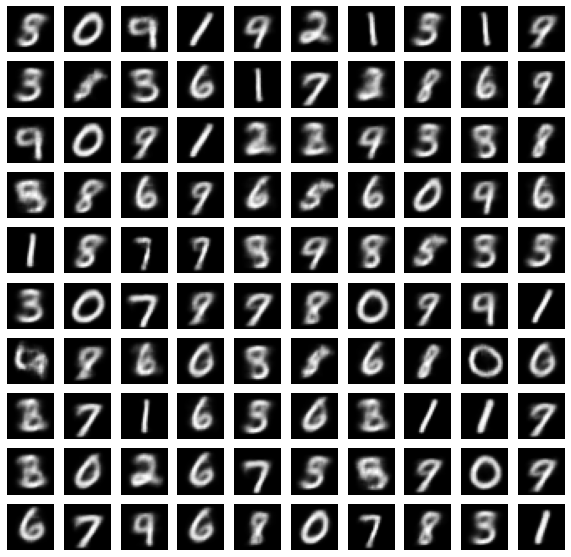

Epoch 1/10
547/547 [==============================] - 6s 10ms/step - loss: 153.4687 - reconstruction_loss: 147.4692 - kl_loss: 5.9236
Epoch 2/10
547/547 [==============================] - 5s 10ms/step - loss: 153.3305 - reconstruction_loss: 147.0379 - kl_loss: 5.9482
Epoch 3/10
547/547 [==============================] - 5s 10ms/step - loss: 152.7208 - reconstruction_loss: 146.6419 - kl_loss: 5.9768
Epoch 4/10
547/547 [==============================] - 5s 9ms/step - loss: 152.1836 - reconstruction_loss: 146.2258 - kl_loss: 6.0154
Epoch 5/10
547/547 [==============================] - 5s 10ms/step - loss: 151.9918 - reconstruction_loss: 145.9317 - kl_loss: 6.0347
Epoch 6/10
547/547 [==============================] - 5s 9ms/step - loss: 151.7196 - reconstruction_loss: 145.6998 - kl_loss: 6.0547
Epoch 7/10
547/547 [==============================] - 5s 10ms/step - loss: 151.4909 - reconstruction_loss: 145.4474 - kl_loss: 6.0572
Epoch 8/10
547/547 [==============================] - 5s 10ms/st

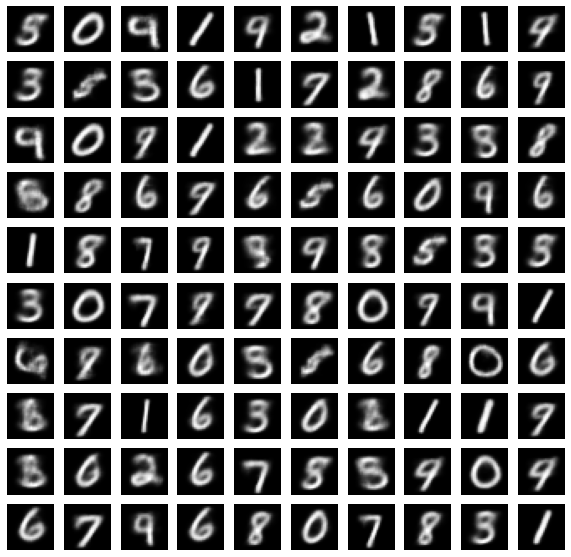

Epoch 1/10
547/547 [==============================] - 5s 10ms/step - loss: 150.6506 - reconstruction_loss: 144.5114 - kl_loss: 6.1338
Epoch 2/10
547/547 [==============================] - 5s 10ms/step - loss: 150.5009 - reconstruction_loss: 144.3153 - kl_loss: 6.1387
Epoch 3/10
547/547 [==============================] - 5s 10ms/step - loss: 150.3958 - reconstruction_loss: 144.1749 - kl_loss: 6.1659
Epoch 4/10
547/547 [==============================] - 5s 10ms/step - loss: 150.3081 - reconstruction_loss: 144.0347 - kl_loss: 6.1693
Epoch 5/10
547/547 [==============================] - 5s 10ms/step - loss: 149.4623 - reconstruction_loss: 143.8375 - kl_loss: 6.1853
Epoch 6/10
547/547 [==============================] - 5s 10ms/step - loss: 149.6997 - reconstruction_loss: 143.5886 - kl_loss: 6.2171
Epoch 7/10
547/547 [==============================] - 5s 10ms/step - loss: 149.5902 - reconstruction_loss: 143.5065 - kl_loss: 6.2095
Epoch 8/10
547/547 [==============================] - 6s 10ms/

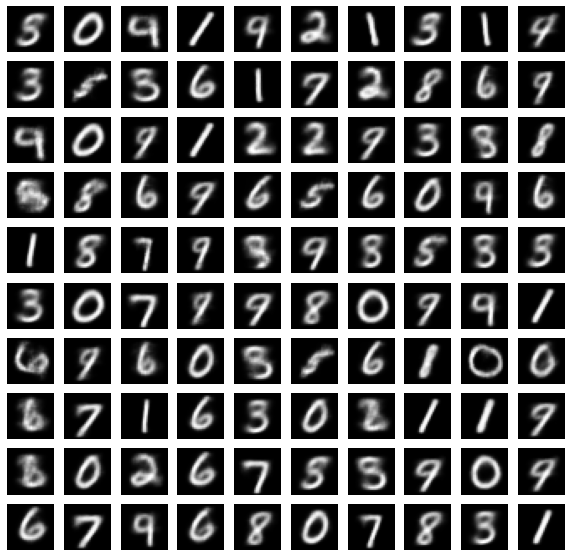

Epoch 1/10
547/547 [==============================] - 6s 11ms/step - loss: 148.9620 - reconstruction_loss: 142.9486 - kl_loss: 6.2580
Epoch 2/10
547/547 [==============================] - 6s 11ms/step - loss: 149.2562 - reconstruction_loss: 142.8808 - kl_loss: 6.2596
Epoch 3/10
547/547 [==============================] - 6s 11ms/step - loss: 149.0785 - reconstruction_loss: 142.8631 - kl_loss: 6.2785
Epoch 4/10
547/547 [==============================] - 6s 11ms/step - loss: 148.6755 - reconstruction_loss: 142.6690 - kl_loss: 6.2794
Epoch 5/10
547/547 [==============================] - 6s 11ms/step - loss: 149.0241 - reconstruction_loss: 142.5001 - kl_loss: 6.2855
Epoch 6/10
547/547 [==============================] - 6s 11ms/step - loss: 148.6553 - reconstruction_loss: 142.5114 - kl_loss: 6.3033
Epoch 7/10
547/547 [==============================] - 6s 11ms/step - loss: 148.4859 - reconstruction_loss: 142.3548 - kl_loss: 6.2941
Epoch 8/10
547/547 [==============================] - 6s 11ms/

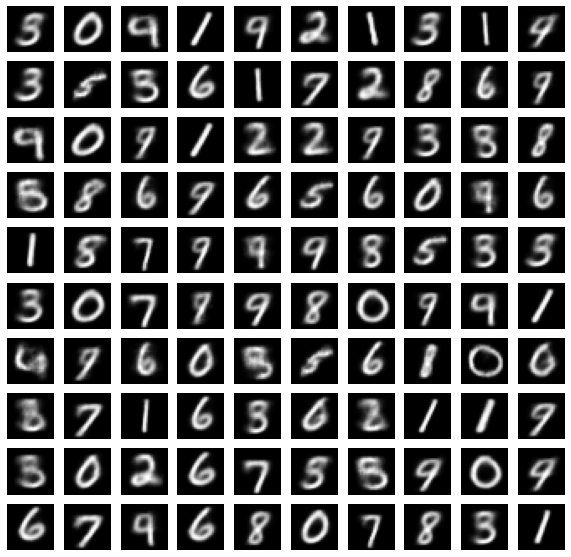

Epoch 1/10
547/547 [==============================] - 6s 11ms/step - loss: 148.3081 - reconstruction_loss: 141.9924 - kl_loss: 6.3518
Epoch 2/10
547/547 [==============================] - 6s 11ms/step - loss: 148.0355 - reconstruction_loss: 141.9247 - kl_loss: 6.3344
Epoch 3/10
547/547 [==============================] - 6s 11ms/step - loss: 148.2266 - reconstruction_loss: 141.8448 - kl_loss: 6.3603
Epoch 4/10
547/547 [==============================] - 6s 10ms/step - loss: 147.8102 - reconstruction_loss: 141.7439 - kl_loss: 6.3458
Epoch 5/10
547/547 [==============================] - 6s 10ms/step - loss: 148.2807 - reconstruction_loss: 141.6382 - kl_loss: 6.3602
Epoch 6/10
547/547 [==============================] - 6s 10ms/step - loss: 148.1107 - reconstruction_loss: 141.6791 - kl_loss: 6.3691
Epoch 7/10
547/547 [==============================] - 6s 11ms/step - loss: 147.8743 - reconstruction_loss: 141.5527 - kl_loss: 6.3766
Epoch 8/10
547/547 [==============================] - 6s 11ms/

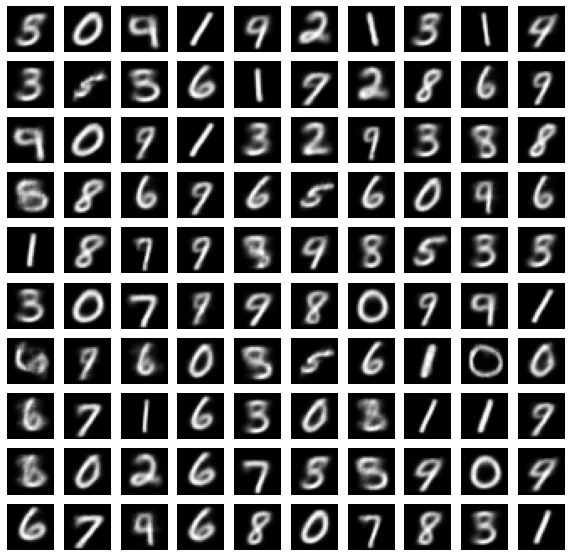

In [21]:
history = vae.fit(mnist_digits, epochs=10, batch_size=128)
loss1 = history.history['loss']
x_pred = vae.decoder.predict(vae.encoder.predict(mnist_digits[0:100])[2])
plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10,10 * i + j + 1)
    plt.imshow(x_pred[10 * i + j].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
history = vae.fit(mnist_digits, epochs=10, batch_size=128)
loss1 += history.history['loss']
x_pred = vae.decoder.predict(vae.encoder.predict(mnist_digits[0:100])[2])
plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10,10 * i + j + 1)
    plt.imshow(x_pred[10 * i + j].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
history = vae.fit(mnist_digits, epochs=10, batch_size=128)
loss1 += history.history['loss']
x_pred = vae.decoder.predict(vae.encoder.predict(mnist_digits[0:100])[2])
plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10,10 * i + j + 1)
    plt.imshow(x_pred[10 * i + j].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
history = vae.fit(mnist_digits, epochs=10, batch_size=128)
loss1 += history.history['loss']
x_pred = vae.decoder.predict(vae.encoder.predict(mnist_digits[0:100])[2])
plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10,10 * i + j + 1)
    plt.imshow(x_pred[10 * i + j].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
history = vae.fit(mnist_digits, epochs=10, batch_size=128)
loss1 += history.history['loss']
x_pred = vae.decoder.predict(vae.encoder.predict(mnist_digits[0:100])[2])
plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10,10 * i + j + 1)
    plt.imshow(x_pred[10 * i + j].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

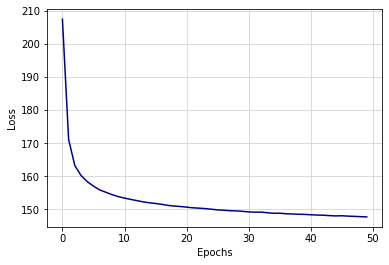

In [22]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss1, 'darkblue')
plt.grid(c='lightgrey')
plt.show()

Now, we plot clusters of data in the latent space. We can make predictions on the validation set using the encoder network. This has the effect of translating the images from the 784-dimensional input space into the 2-dimensional latent space. When we color-code those translated data points according to their known digit class, we can see how the digits cluster together

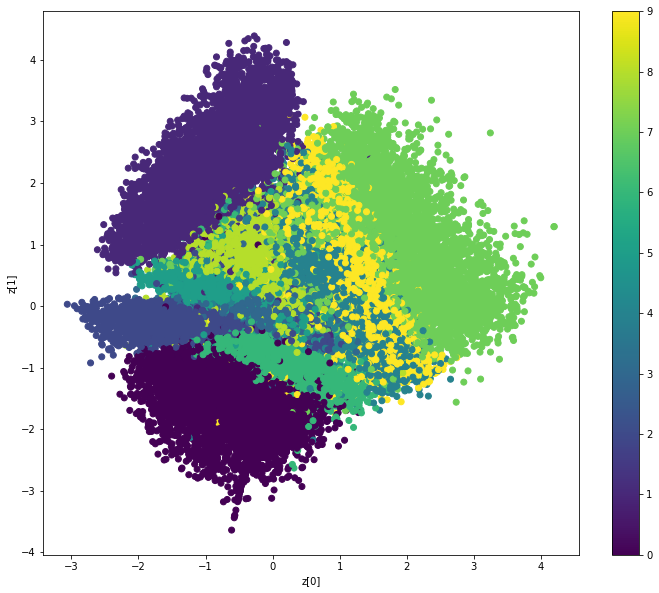

In [23]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(vae, x_train, y_train)

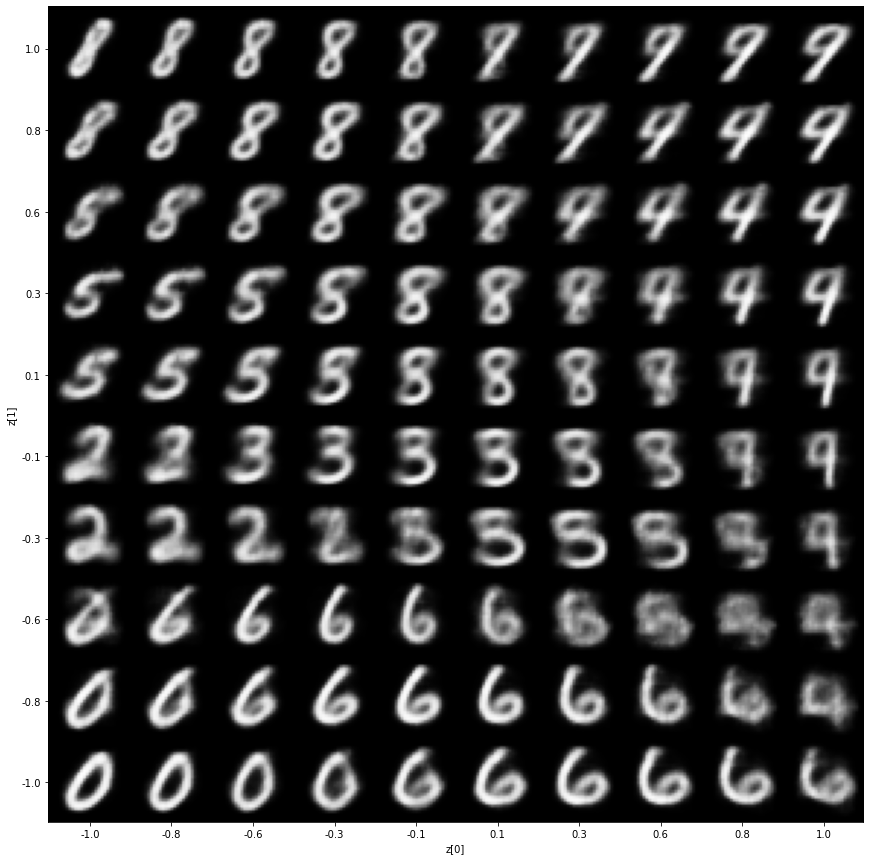

In [24]:
plot_latent_space(vae)

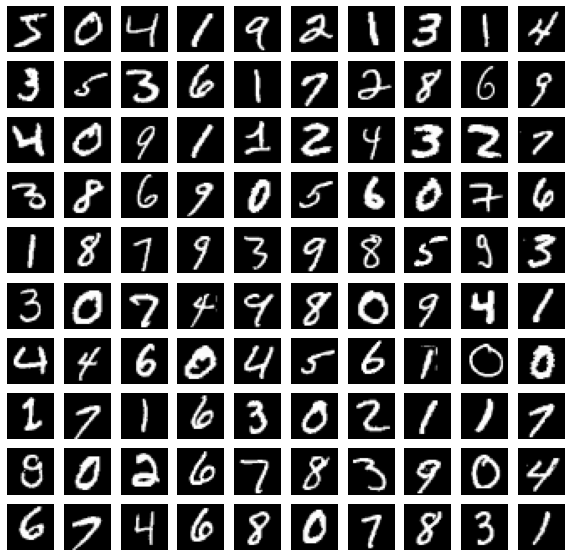

In [25]:
plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10,10 * i + j + 1)
    plt.imshow(mnist_digits[10 * i + j].squeeze(), cmap='gray')
    plt.axis('off')

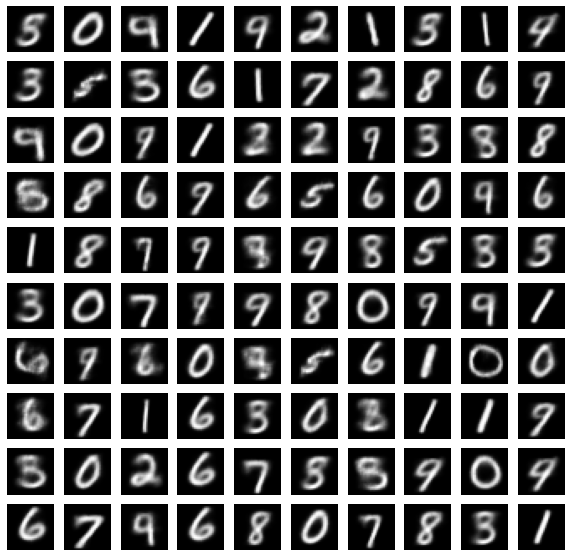

In [26]:
x_pred = vae.decoder.predict(vae.encoder.predict(mnist_digits[0:100])[2])
plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10,10 * i + j + 1)
    plt.imshow(x_pred[10 * i + j].squeeze(), cmap='gray')
    plt.axis('off')

## Conditional VAE

## Parameter Initialization

In [27]:
batch_size = 100
learning_rate = 1e-3
max_epoch = 40
device = torch.device("cuda")
num_workers = 5
load_epoch = -1
generate = True

## Model Definition
In this part we define the model and use code and theory in the paper to implement the conditional autoencoder.

In [28]:
class Model(nn.Module):
    def __init__(self,latent_size=2,num_classes=10):
        super(Model,self).__init__()
        self.latent_size = latent_size
        self.num_classes = num_classes

        # For encode
        self.conv1 = nn.Conv2d(2, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(4*4*32,300)
        self.mu = nn.Linear(300, self.latent_size)
        self.logvar = nn.Linear(300, self.latent_size)

        # For decoder
        self.linear2 = nn.Linear(self.latent_size + self.num_classes, 300)
        self.linear3 = nn.Linear(300,4*4*32)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=5,stride=2)
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2)
        self.conv5 = nn.ConvTranspose2d(1, 1, kernel_size=4)

    def encoder(self,x,y):
        y = torch.argmax(y, dim=1).reshape((y.shape[0],1,1,1))
        y = torch.ones(x.shape).to(device)*y
        t = torch.cat((x,y),dim=1)
        
        t = F.relu(self.conv1(t))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))
        
        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(device)
        return eps*std + mu

    def unFlatten(self, x):
        return x.reshape((x.shape[0], 32, 4, 4))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = F.relu(self.conv5(t))
        return t
        
    def forward(self, x, y):
        mu, logvar = self.encoder(x,y)
        z = self.reparameterize(mu,logvar)
        # Class conditioning
        z = torch.cat((z, y.float()), dim=1)
        pred = self.decoder(z)
        return pred, mu, logvar

Now, we write a function to plot and save images of prediction and input.

In [29]:
def plot(epoch, pred, y,name='test_'):
    if not os.path.isdir('./images'):
        os.mkdir('./images')
    fig = plt.figure(figsize=(16,16))
    for i in range(6):
        ax = fig.add_subplot(3,2,i+1)
        ax.imshow(pred[i,0],cmap='gray')
        ax.axis('off')
        ax.title.set_text(str(y[i]))
    plt.savefig("./images/{}epoch_{}.jpg".format(name, epoch))
    plt.figure(figsize=(10,10))
    plt.imsave("./images/pred_{}.jpg".format(epoch), pred[0,0], cmap='gray')
    plt.close()

A fnction is defined to clculate loss of model.

In [30]:
def loss_function(x, pred, mu, logvar):
    recon_loss = F.mse_loss(pred, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, kld

Train and test methods are written using pytorch library.

In [31]:
def train(epoch, model, train_loader, optim):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    for i,(x,y) in enumerate(train_loader):
        try:
            label = np.zeros((x.shape[0], 10))
            label[np.arange(x.shape[0]), y] = 1
            label = torch.tensor(label)
            optim.zero_grad()   
            pred, mu, logvar = model(x.to(device),label.to(device))  
            recon_loss, kld = loss_function(x.to(device),pred, mu, logvar)
            loss = recon_loss + kld
            loss.backward()
            optim.step()
            total_loss += loss.cpu().data.numpy()*x.shape[0]
            reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
            kld_loss += kld.cpu().data.numpy()*x.shape[0]
            if i == 0:
                print("Gradients")
                for name,param in model.named_parameters():
                    if "bias" in name:
                        print(name,param.grad[0],end=" ")
                    else:
                        print(name,param.grad[0,0],end=" ")
                    print()
        except Exception as e:
            traceback.print_exe()
            torch.cuda.empty_cache()
            continue
    reconstruction_loss /= len(train_loader.dataset)
    kld_loss /= len(train_loader.dataset)
    total_loss /= len(train_loader.dataset)
    return total_loss, kld_loss,reconstruction_loss

In [32]:
def test(epoch, model, test_loader):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    with torch.no_grad():
        for i,(x,y) in enumerate(test_loader):
            try:
                label = np.zeros((x.shape[0], 10))
                label[np.arange(x.shape[0]), y] = 1
                label = torch.tensor(label)
                pred, mu, logvar = model(x.to(device),label.to(device))
                recon_loss, kld = loss_function(x.to(device),pred, mu, logvar)
                loss = recon_loss + kld
                total_loss += loss.cpu().data.numpy()*x.shape[0]
                reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
                kld_loss += kld.cpu().data.numpy()*x.shape[0]
                if i == 0:
                    plot(epoch, pred.cpu().data.numpy(), y.cpu().data.numpy())
            except Exception as e:
                traceback.print_exe()
                torch.cuda.empty_cache()
                continue
    reconstruction_loss /= len(test_loader.dataset)
    kld_loss /= len(test_loader.dataset)
    total_loss /= len(test_loader.dataset)
    return total_loss, kld_loss,reconstruction_loss        

We also, write a function to generate images by getting input from lateent space. This function uses the plot function that we wrote previously.

In [33]:
def generate_image(epoch,z, y, model):
    with torch.no_grad():
        label = np.zeros((y.shape[0], 10))
        label[np.arange(z.shape[0]), y] = 1
        label = torch.tensor(label)
        pred = model.decoder(torch.cat((z.to(device),label.float().to(device)), dim=1))
        plot(epoch, pred.cpu().data.numpy(), y.cpu().data.numpy(),name='Eval_')
        print("data Plotted")

It is also required to write a data loader for this problem.

In [34]:
def load_data():
    transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=transform),batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=transform),batch_size=batch_size, num_workers=num_workers, shuffle=True)
    return train_loader, test_loader

In [35]:
def save_model(model, epoch):
    if not os.path.isdir("./checkpoints"):
        os.mkdir("./checkpoints")
    file_name = './checkpoints/model_{}.pt'.format(epoch)
    torch.save(model.state_dict(), file_name)

Now, we train and test the data.


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

dataloader created


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

model created
Gradients
conv1.weight tensor([[ 0.0025,  0.0006, -0.0004, -0.0037, -0.0029],
        [ 0.0039, -0.0015, -0.0055, -0.0046, -0.0096],
        [-0.0004, -0.0040, -0.0101, -0.0057, -0.0107],
        [ 0.0004, -0.0019,  0.0020,  0.0016, -0.0011],
        [ 0.0031,  0.0068,  0.0052,  0.0051,  0.0034]], device='cuda:0') 
conv1.bias tensor(0.0010, device='cuda:0') 
conv2.weight tensor([[ 4.1057e-03,  2.5807e-03,  2.1439e-03,  6.1023e-05, -2.4244e-03],
        [ 1.3127e-03,  3.1019e-03,  2.9597e-03,  2.4418e-03, -2.4097e-04],
        [ 8.7576e-04,  1.1181e-03,  6.3852e-03,  3.1442e-03, -2.1029e-03],
        [ 2.4352e-03,  5.2980e-03,  1.9667e-03, -2.2220e-04, -2.8193e-03],
        [ 4.7034e-03,  7.2080e-03, -3.2128e-03,  4.9370e-04,  2.2364e-03]],
       device='cuda:0') 
conv2.bias tensor(0.7947, device='cuda:0') 
linear1.weight tensor(0., device='cuda:0') 
linear1.bias tensor(0., device='cuda:0') 
mu.weight tensor(0., device='cuda:0') 
mu.bias tensor(20.5027, device='cuda:0') 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Gradients
conv1.weight tensor([[ 5.6737, 12.5369, 16.0721, 12.3173,  2.5276],
        [ 6.9549, 17.6204, 23.9366, 15.4004,  6.5886],
        [17.8738, 29.3139, 34.8872, 23.6939, 13.1420],
        [23.2672, 31.2917, 35.7341, 22.0091,  9.0520],
        [21.9374, 24.8817, 20.4560, 10.6089, -1.7545]], device='cuda:0') 
conv1.bias tensor(1.0145, device='cuda:0') 
conv2.weight tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0') 
conv2.bias tensor(0., device='cuda:0') 
linear1.weight tensor(0., device='cuda:0') 
linear1.bias tensor(6.5508, device='cuda:0') 
mu.weight tensor(-26.4850, device='cuda:0') 
mu.bias tensor(-16.6609, device='cuda:0') 
logvar.weight tensor(0.7009, device='cuda:0') 
logvar.bias tensor(-5.2303, device='cuda:0') 
linear2.weight tensor(-2.9261, device='cuda:0') 
linear2.bias tensor(5.7380, device='cuda:0') 
linear3.weight tensor(0., device='cuda:0') 
linear3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


data Plotted
Epoch: 10/40 Train loss: 3037.007772216797, Train KLD: 338.6998393249512, Train Reconstruction Loss:2698.307930501302
Epoch: 10/40 Test loss: 2722.5912231445313, Test KLD: 327.28973266601565, Test Reconstruction Loss:2722.5912231445313
Gradients
conv1.weight tensor([[ 5.3357,  8.0612,  4.1611, -1.1479, -5.2612],
        [ 7.3729,  2.1848,  1.6241, -0.6988, -2.1518],
        [ 8.4214,  4.0187,  5.7335,  5.1297,  2.8016],
        [ 6.7376,  4.6531,  4.1307,  1.6950,  1.3953],
        [ 4.7440,  5.4044,  0.2171, -2.9384, -6.7731]], device='cuda:0') 
conv1.bias tensor(2.8160, device='cuda:0') 
conv2.weight tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0') 
conv2.bias tensor(0., device='cuda:0') 
linear1.weight tensor(0., device='cuda:0') 
linear1.bias tensor(-4.2368, device='cuda:0') 
mu.weight tensor(38.2003, device='cuda:0') 
mu.bias tensor(241.0128, device='

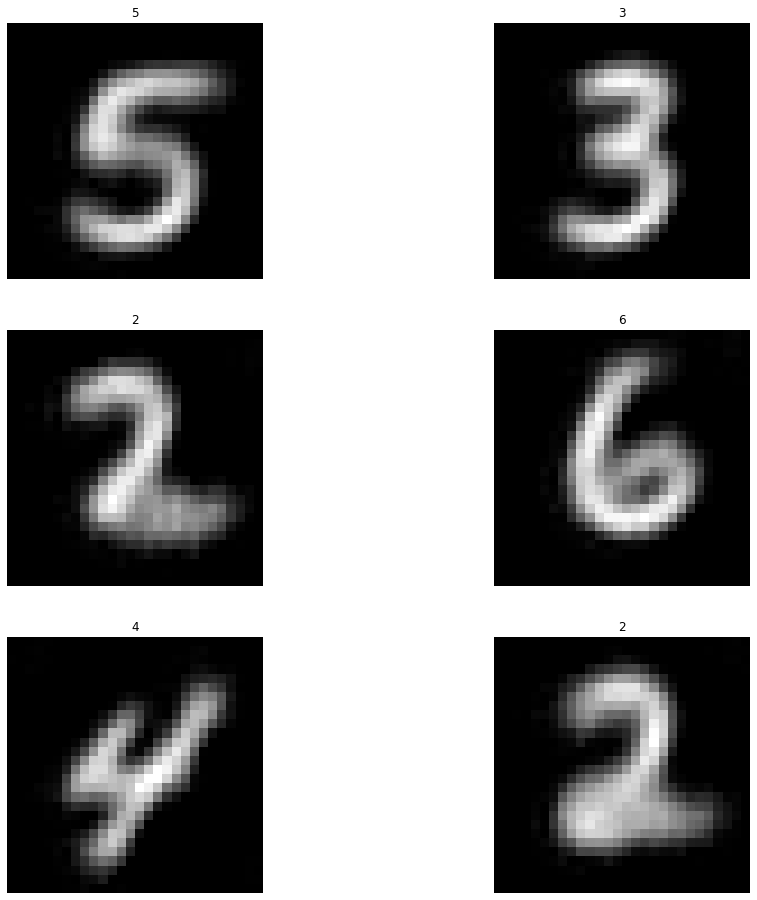

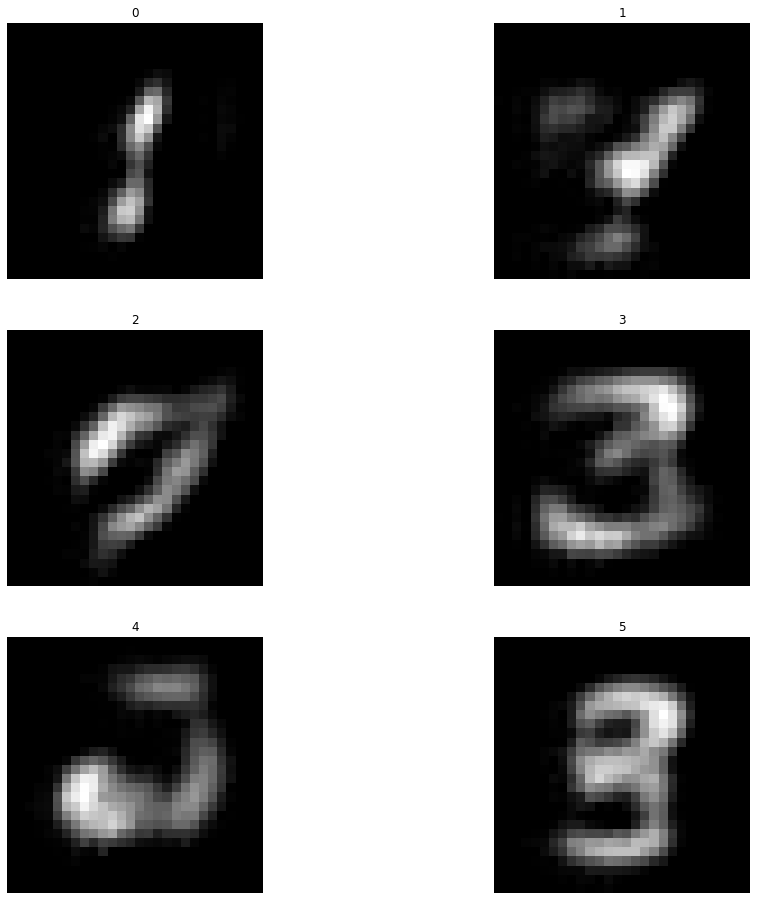

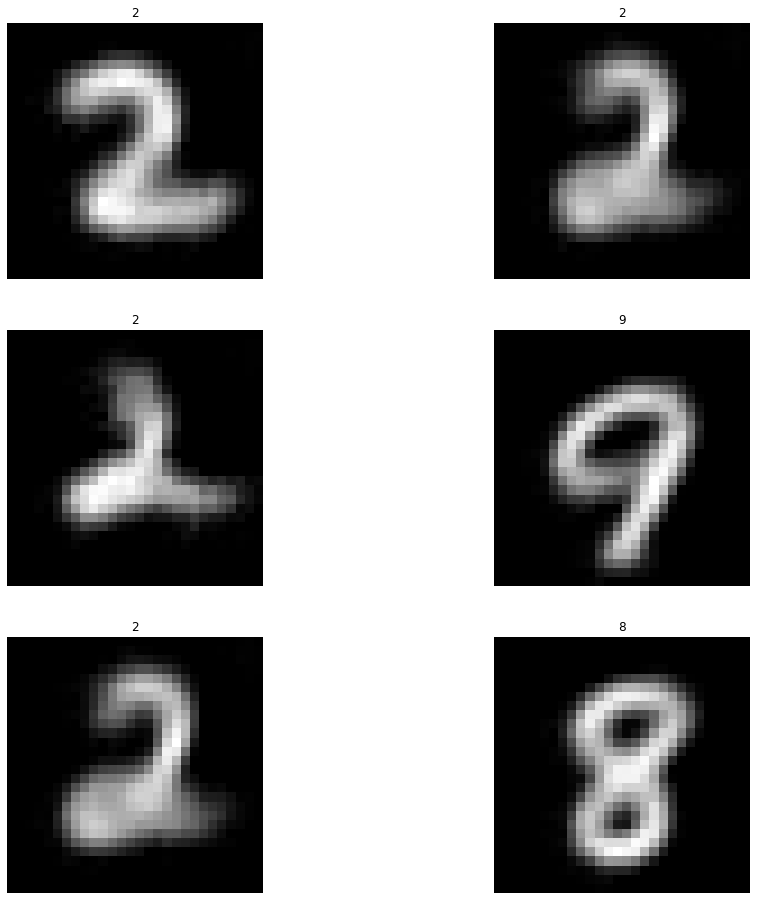

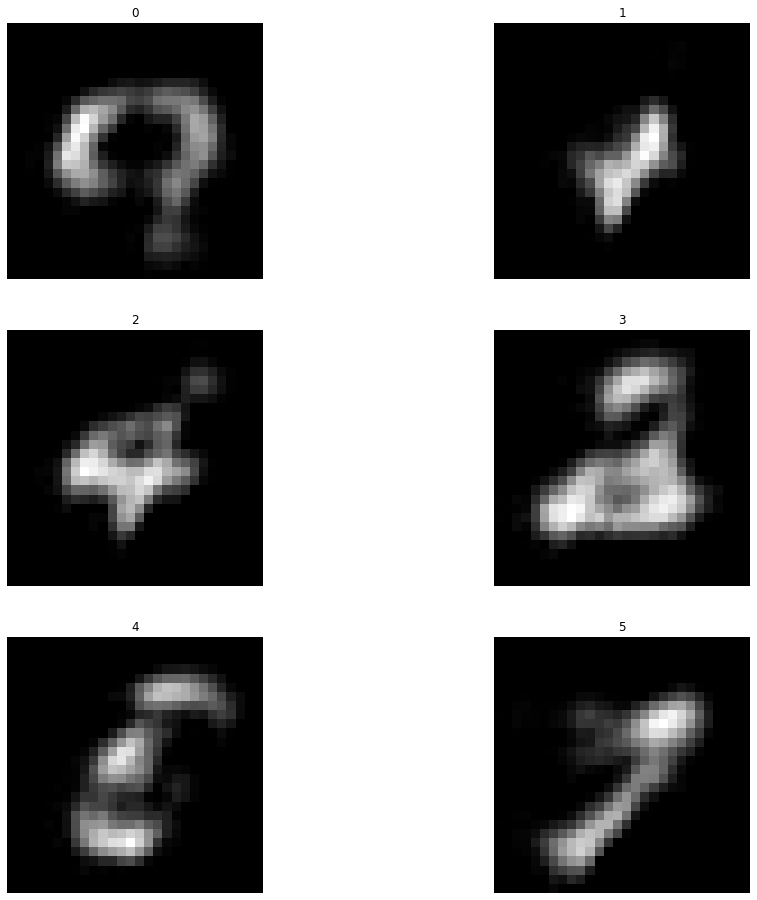

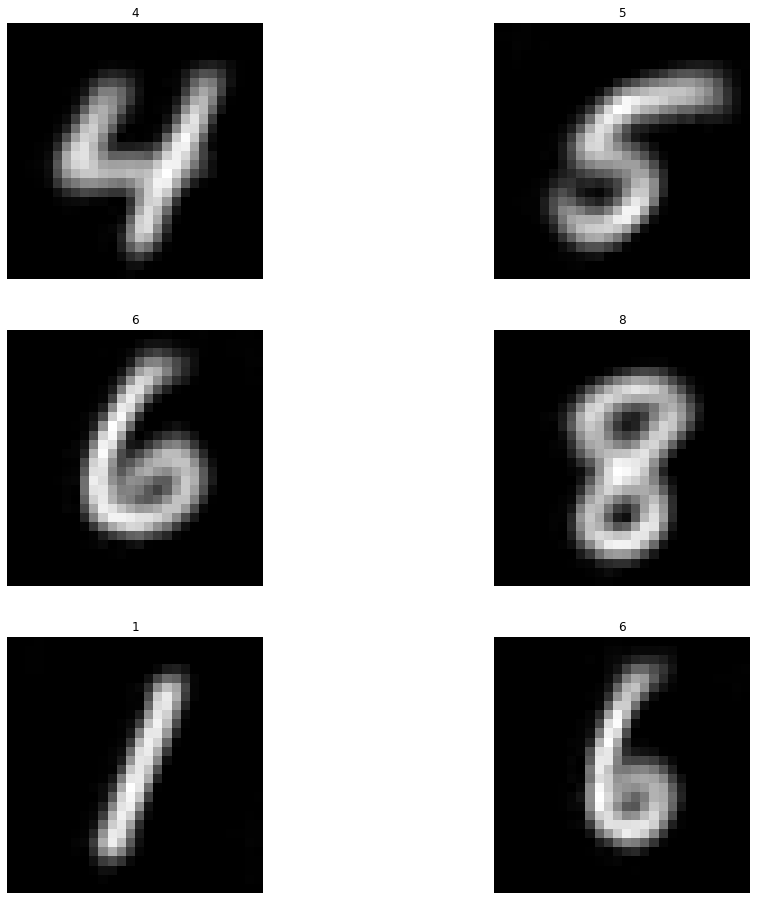

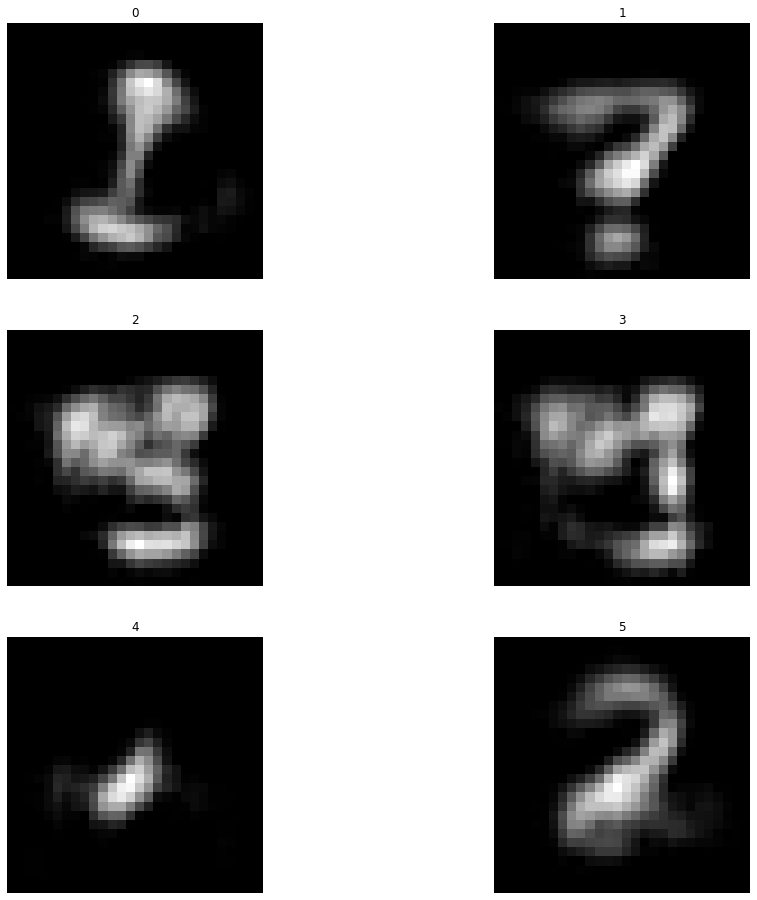

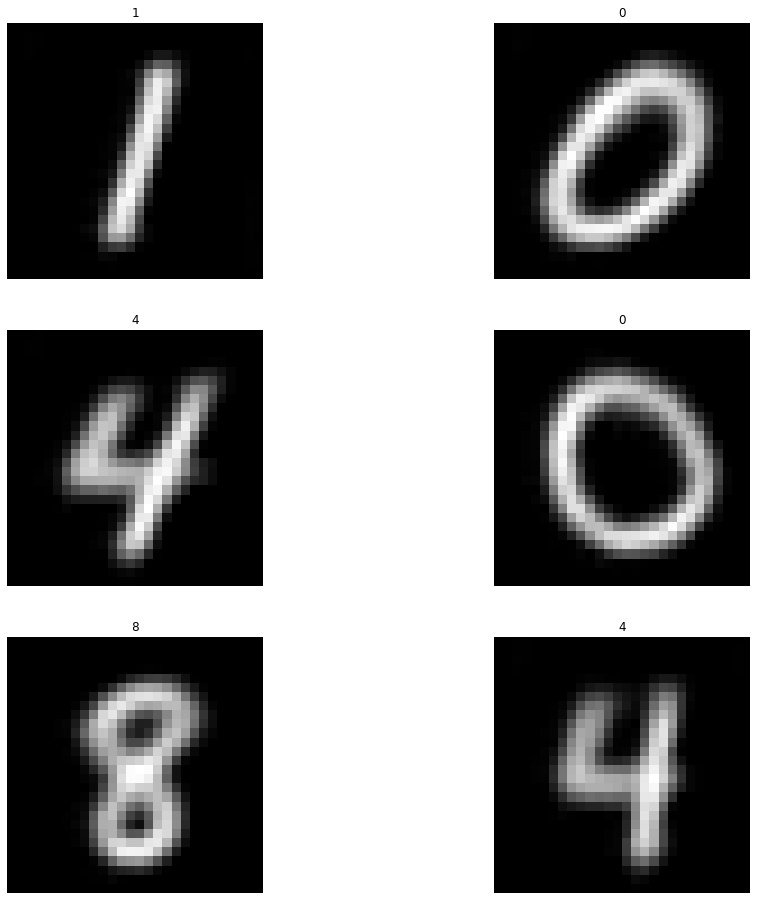

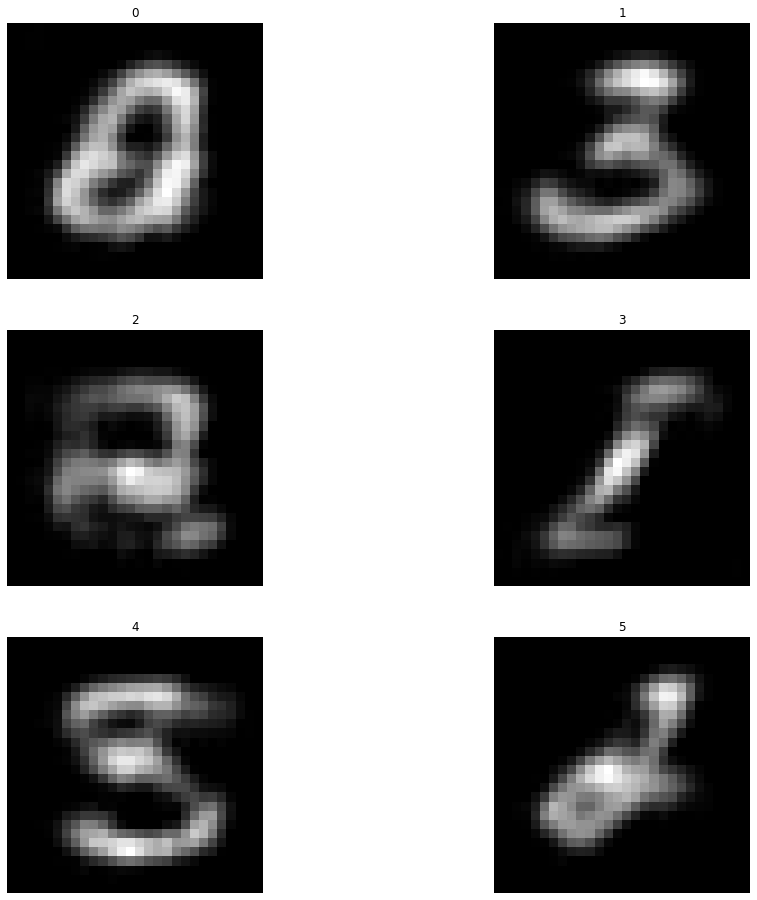

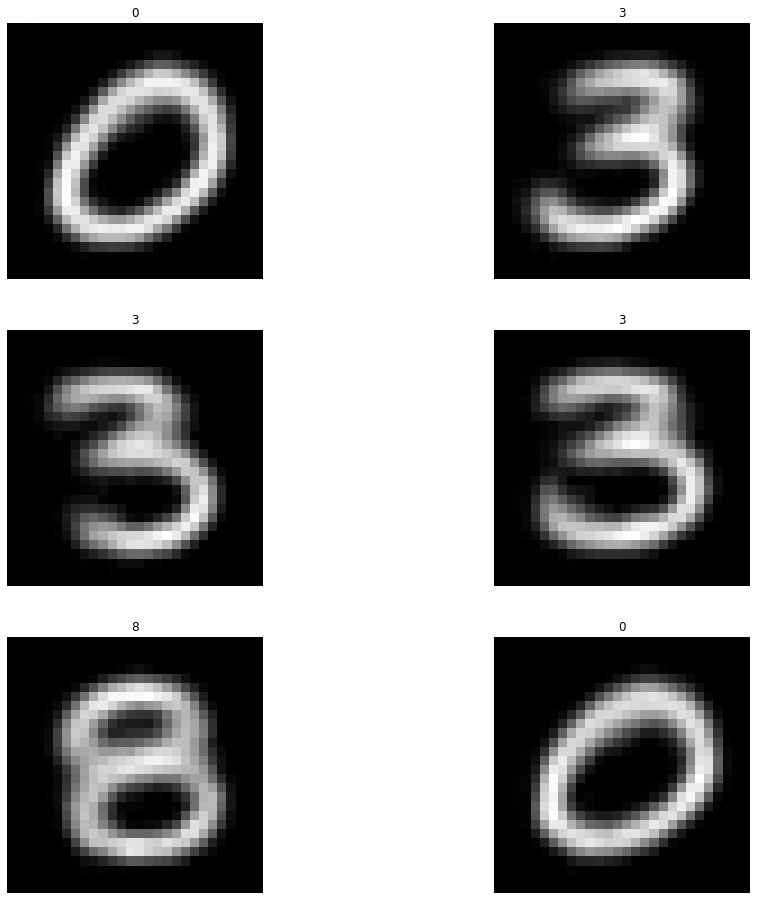

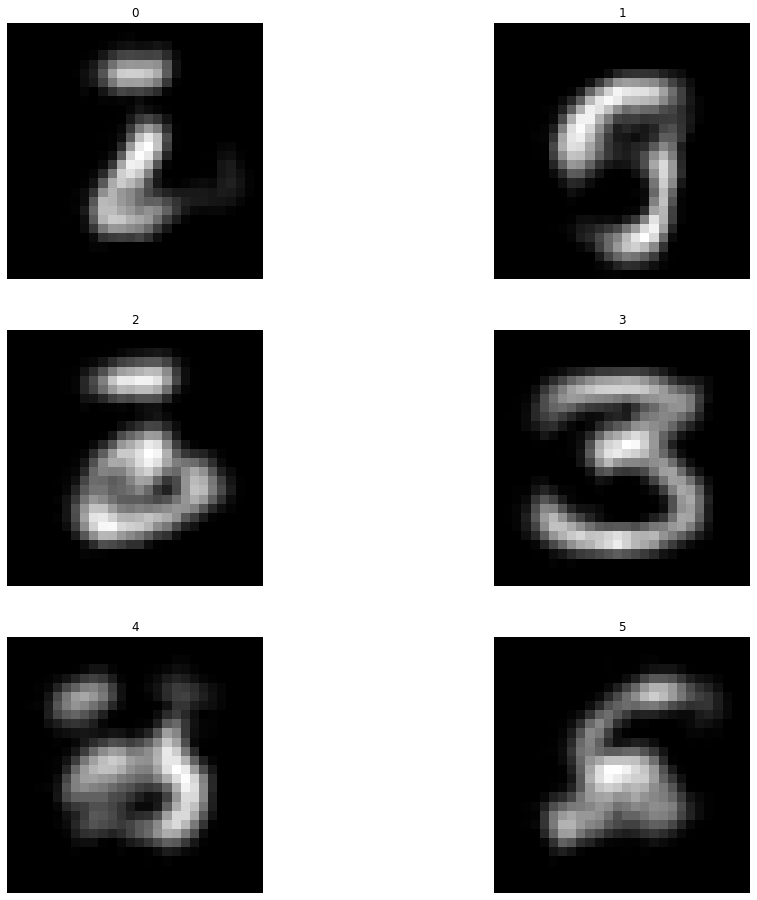

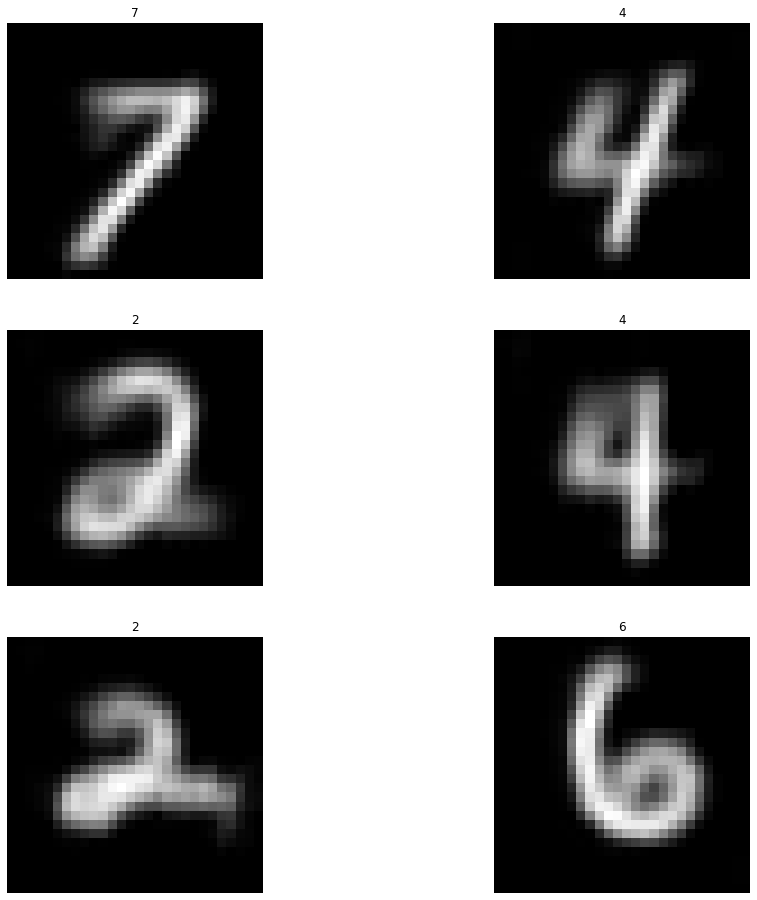

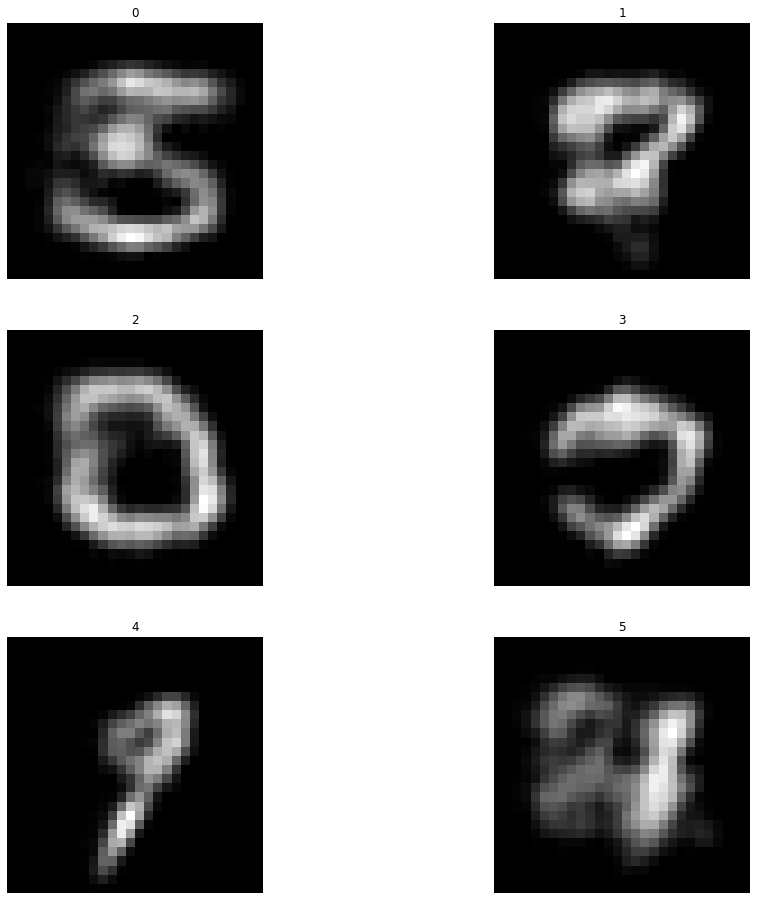

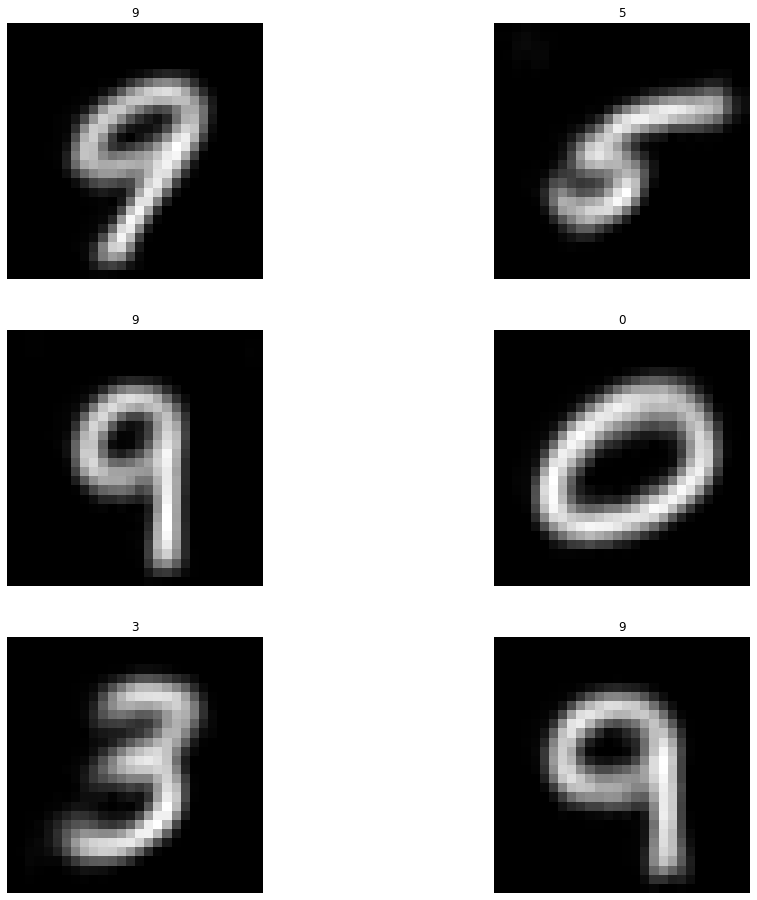

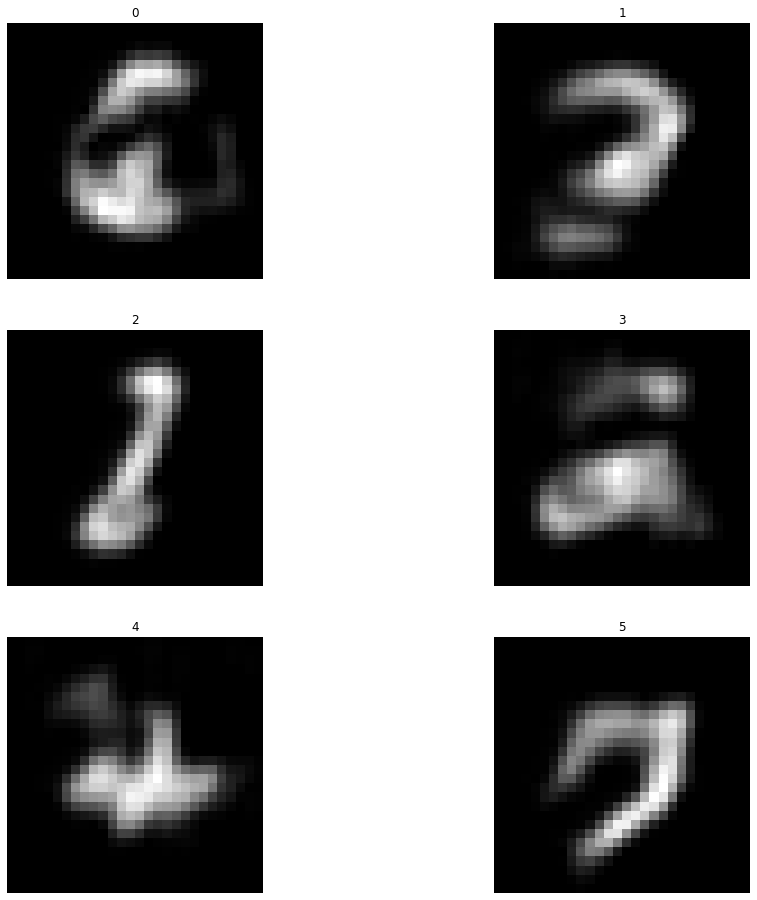

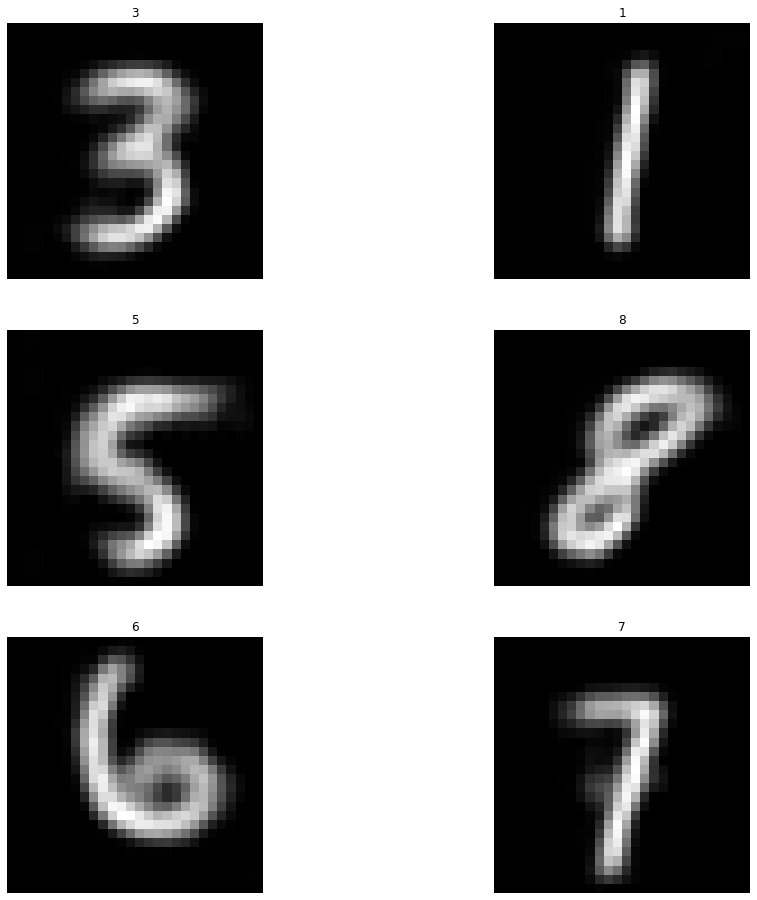

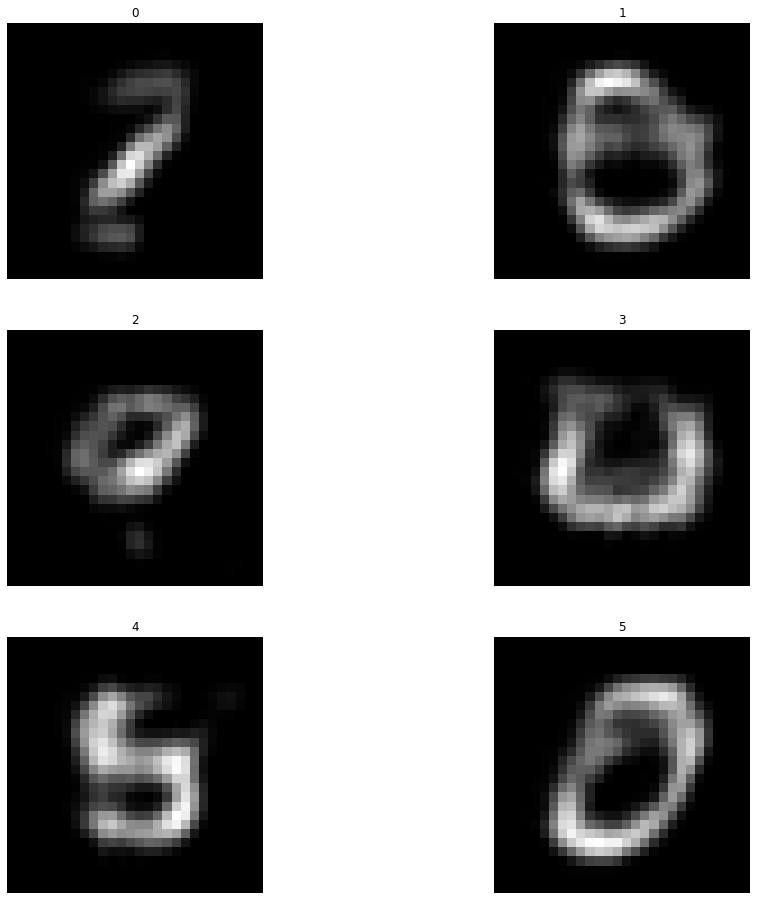

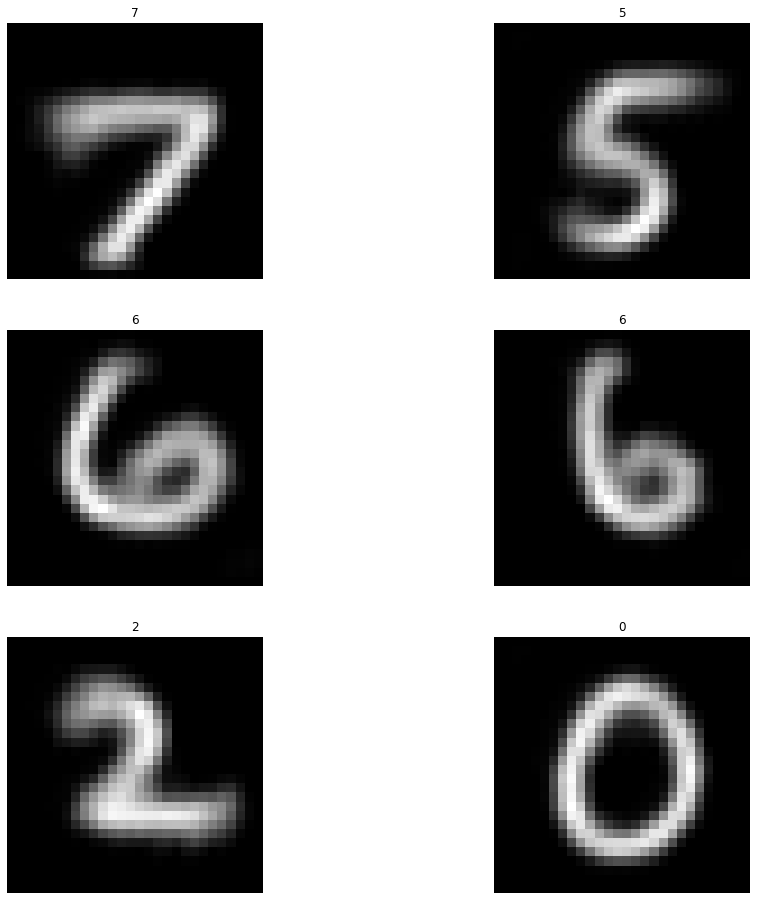

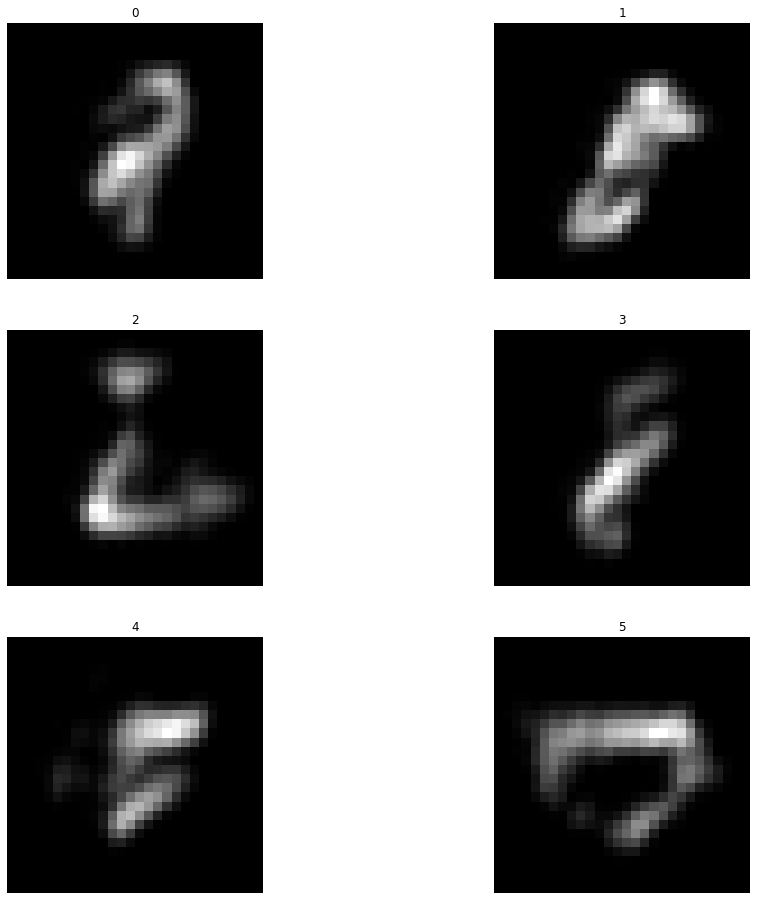

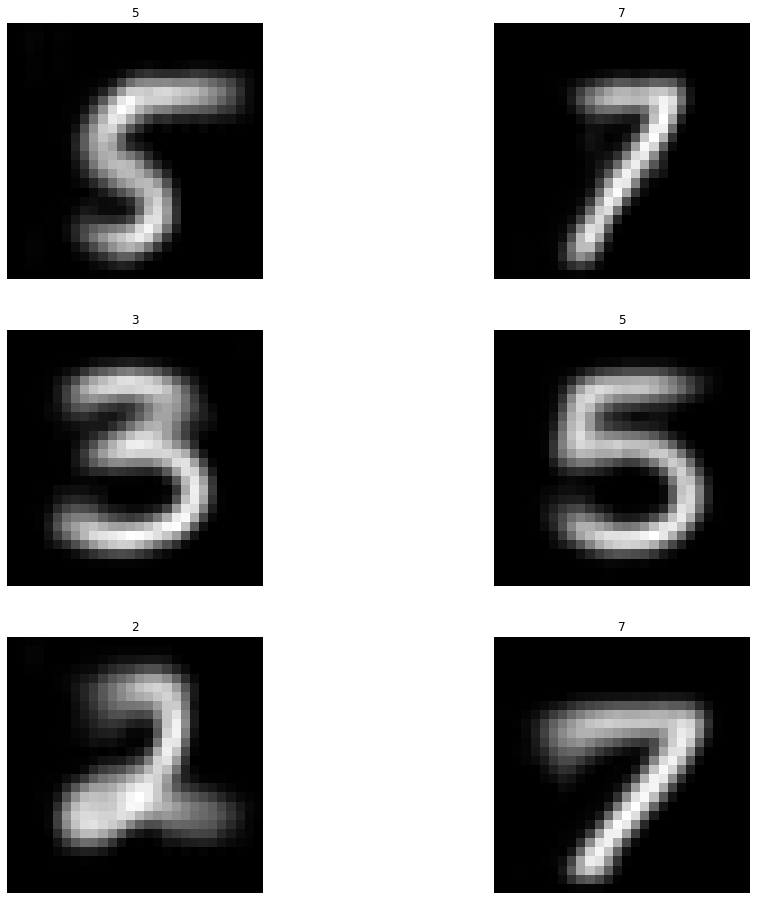

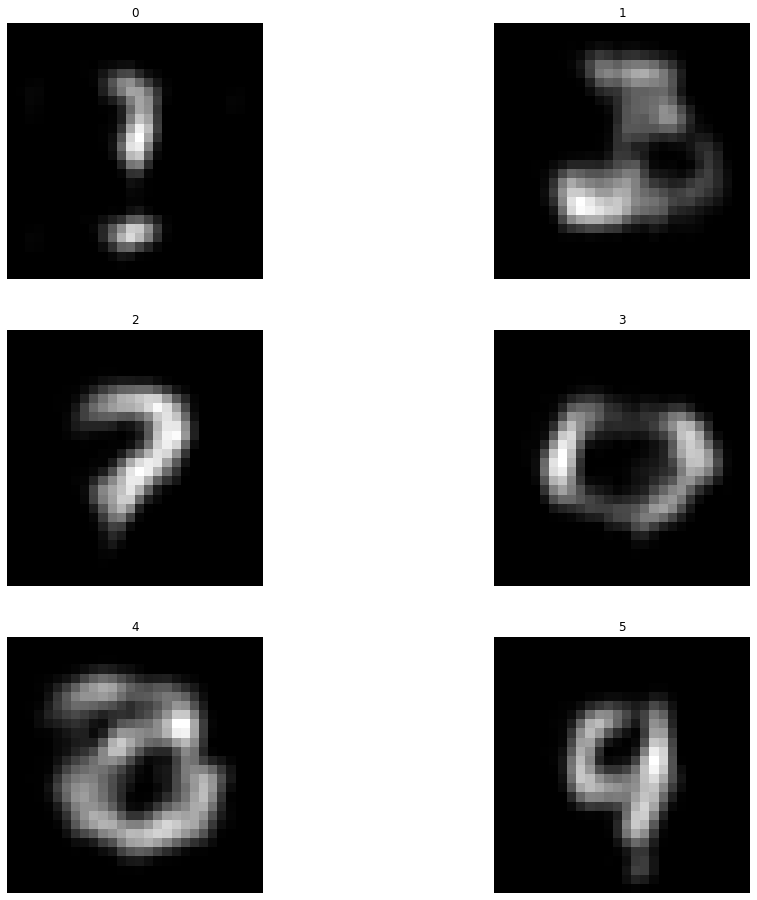

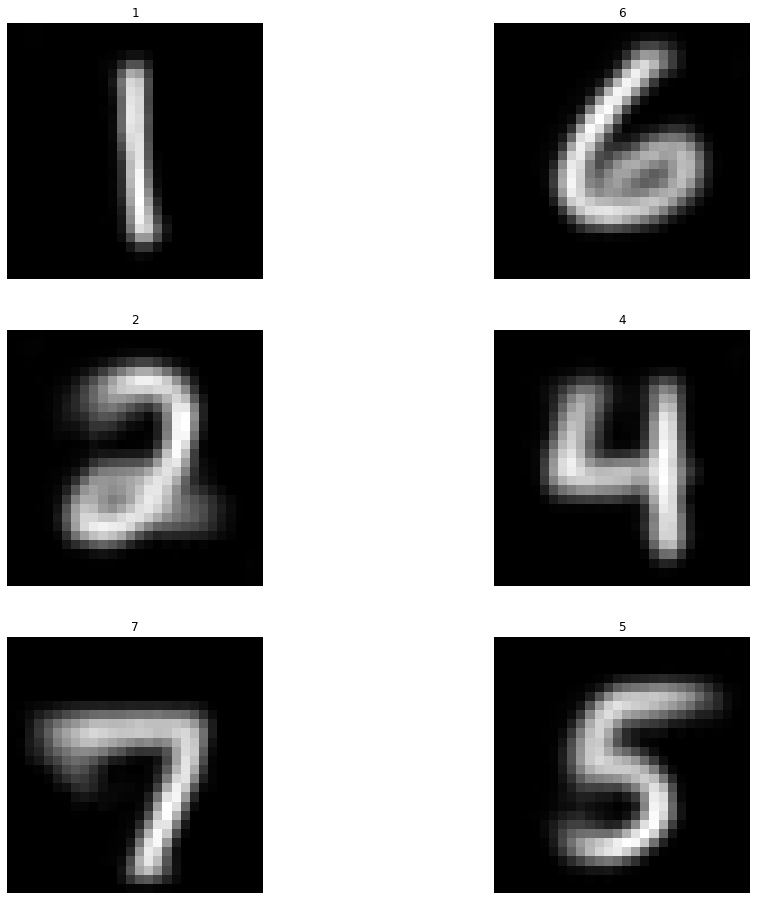

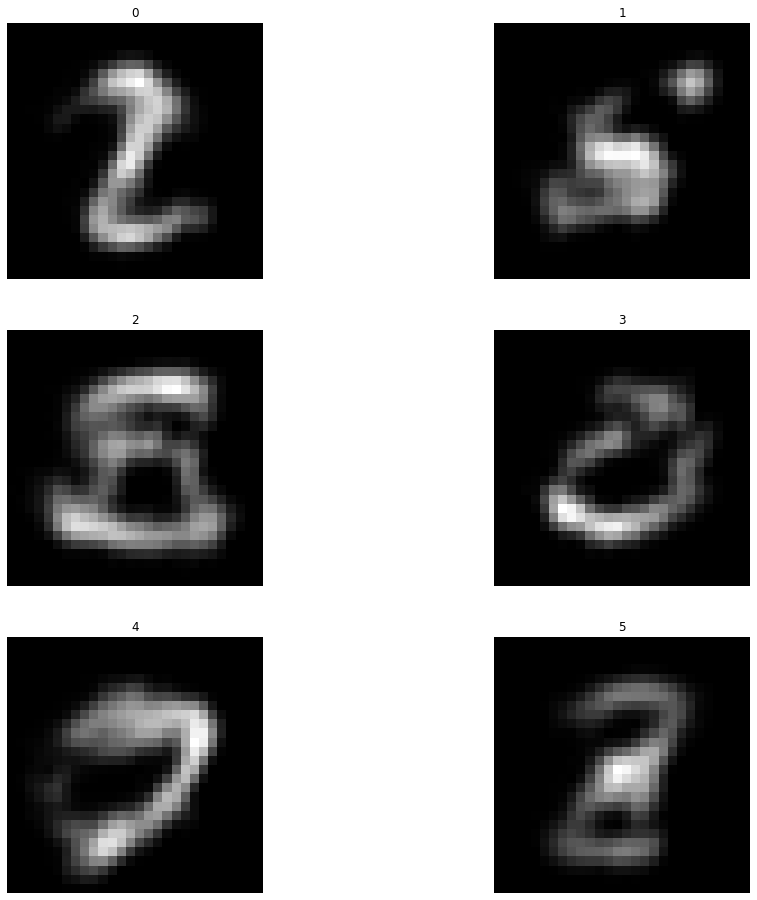

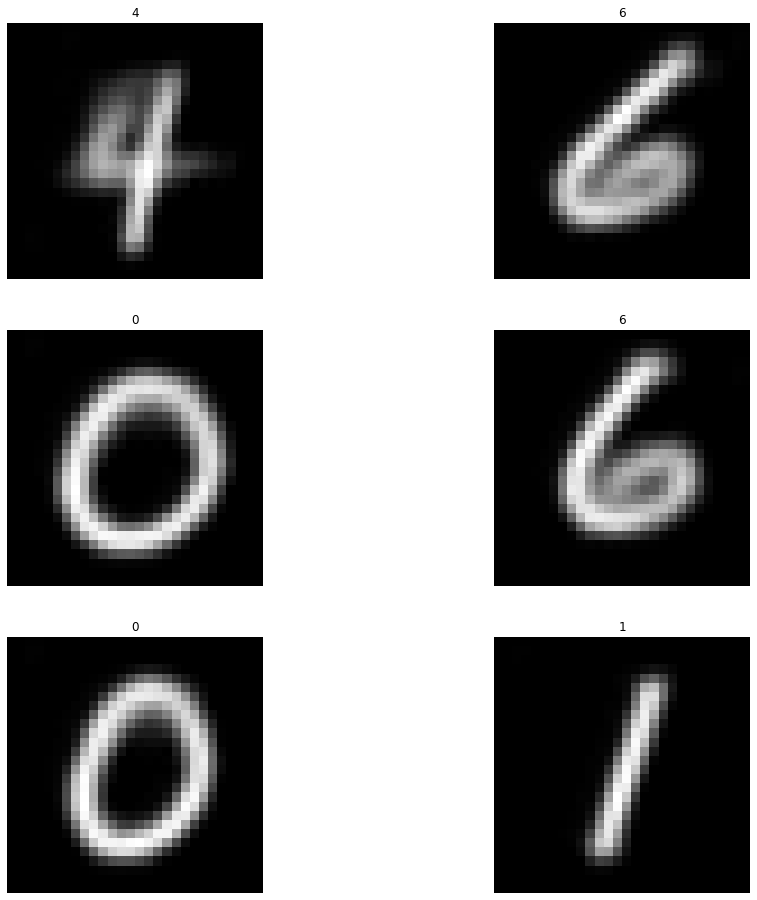

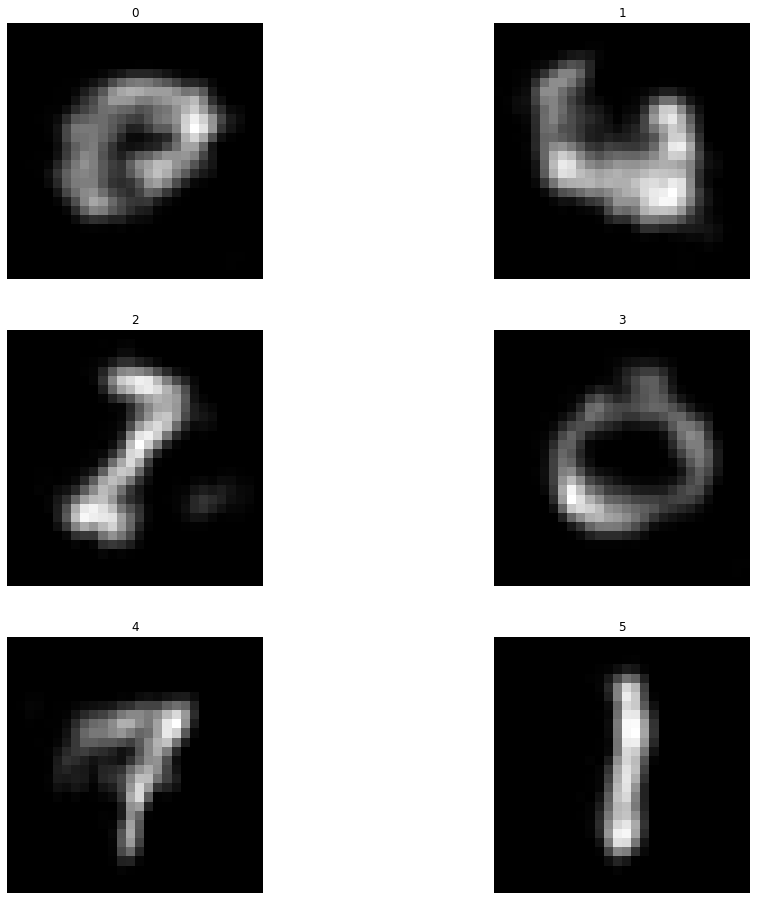

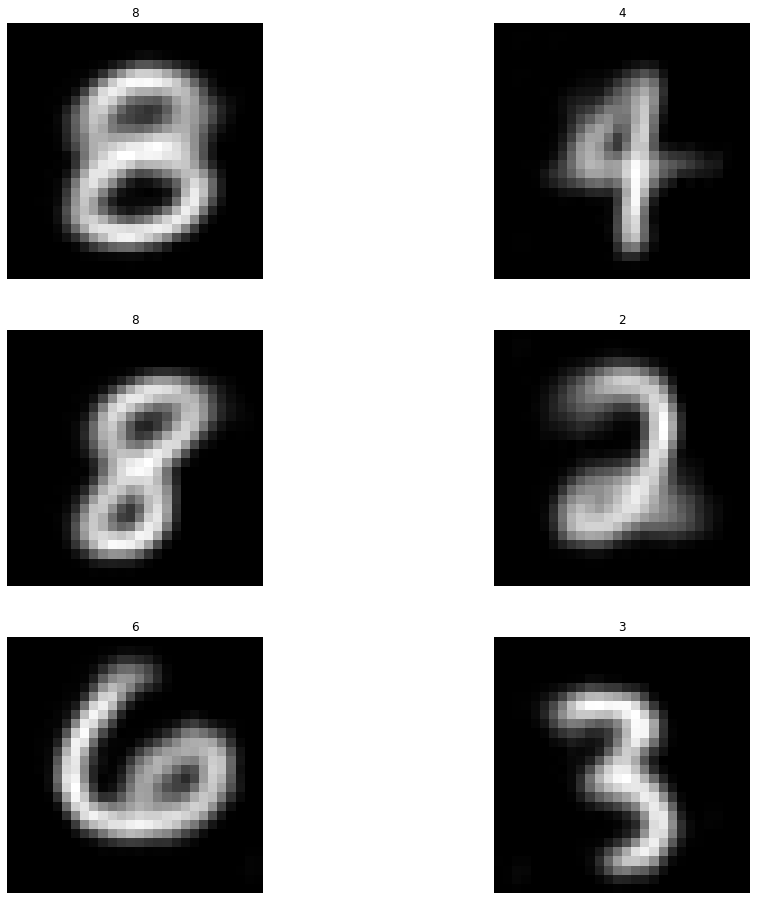

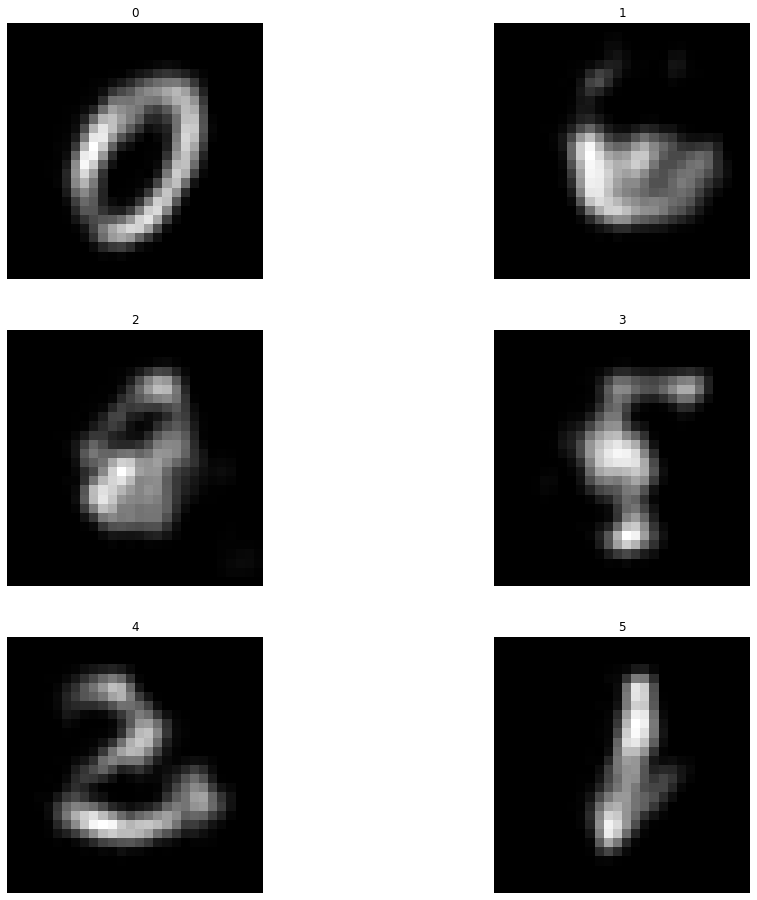

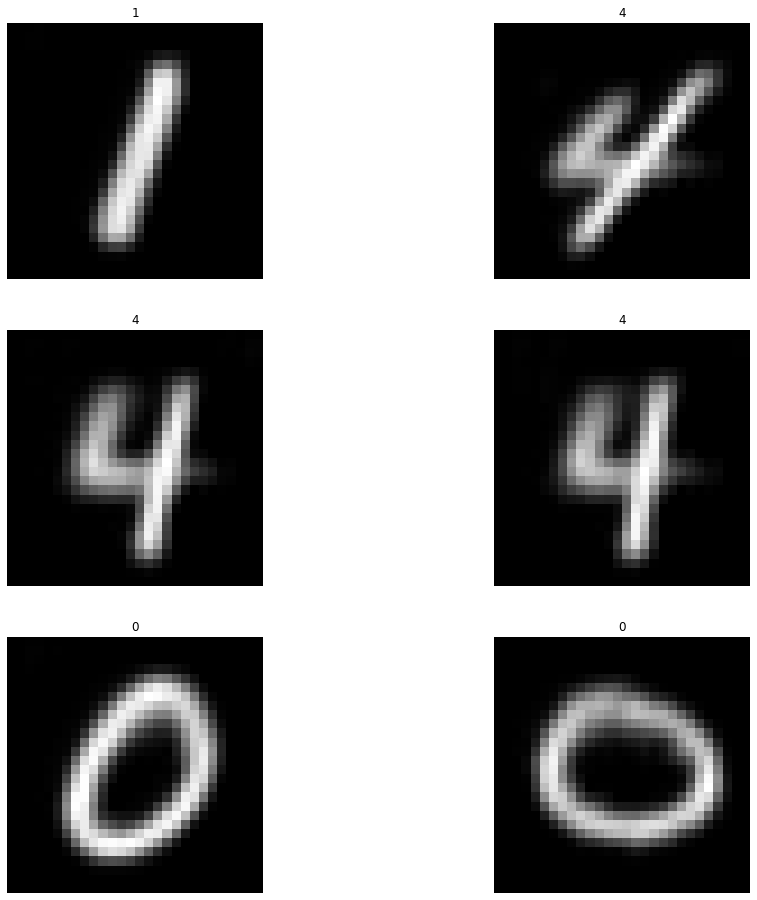

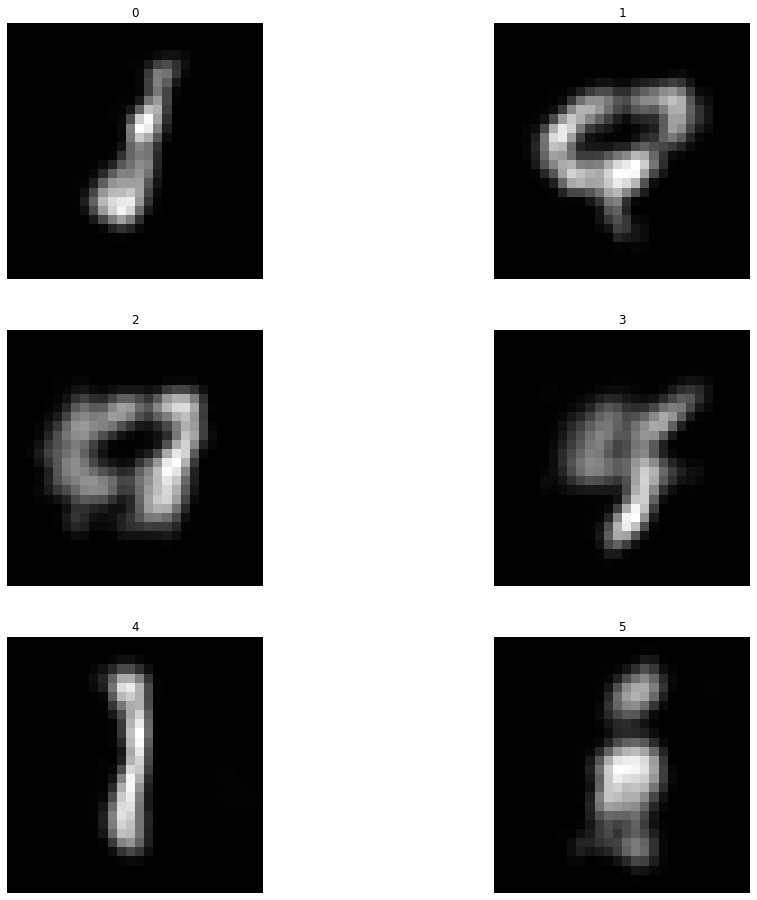

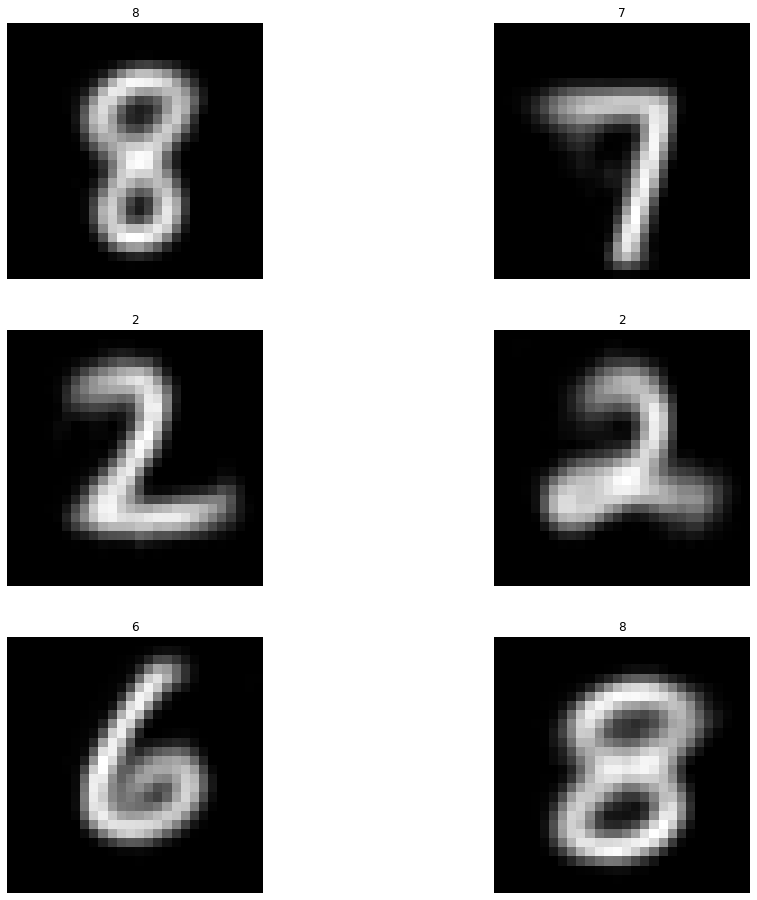

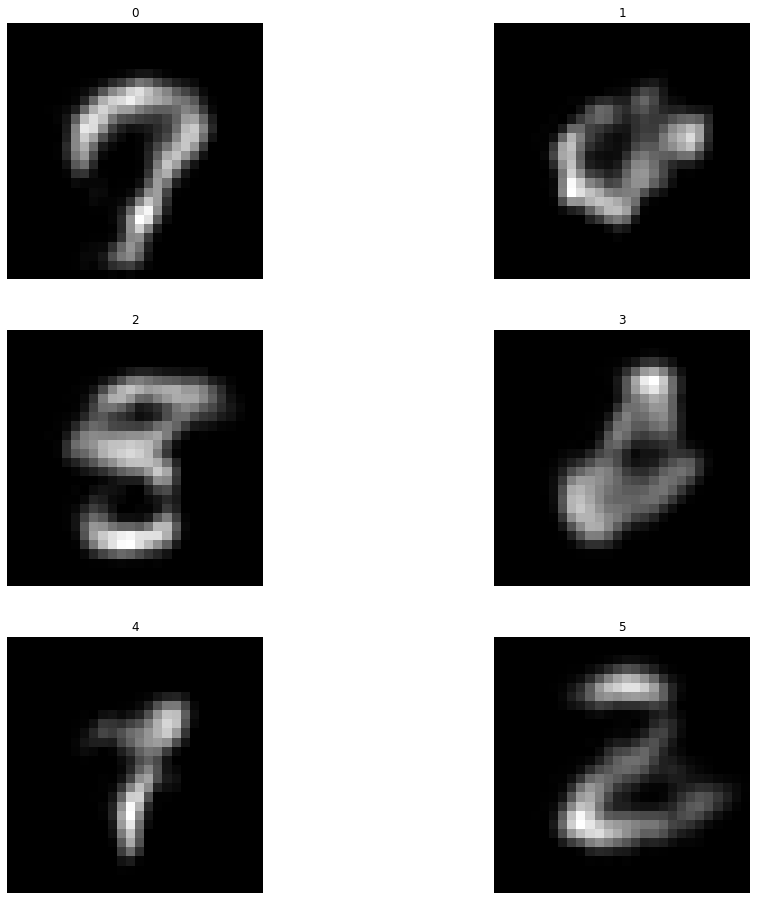

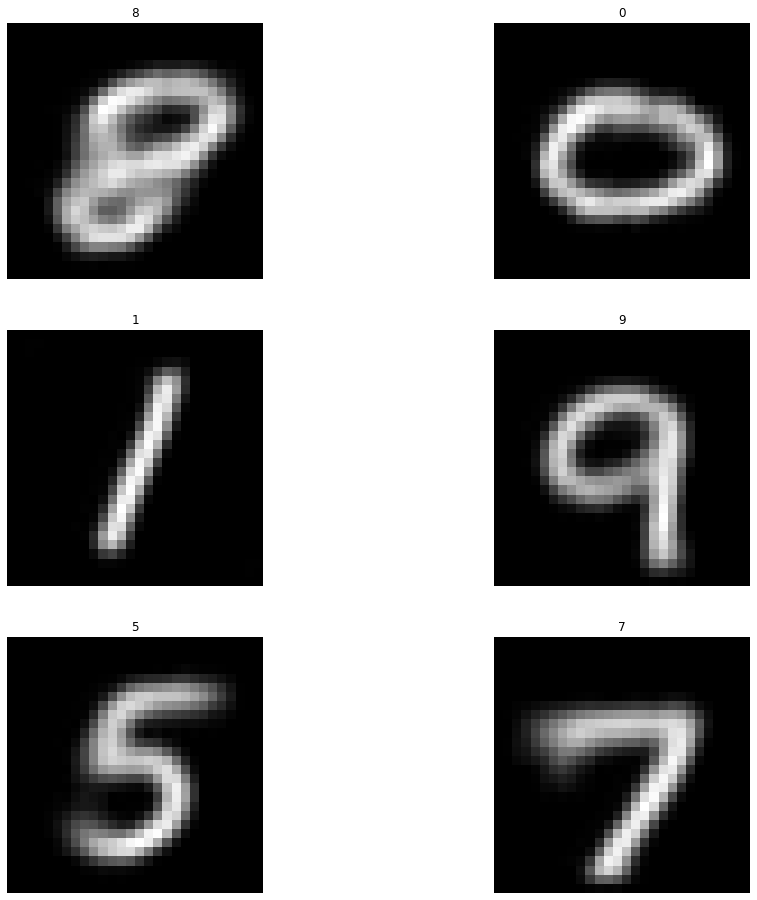

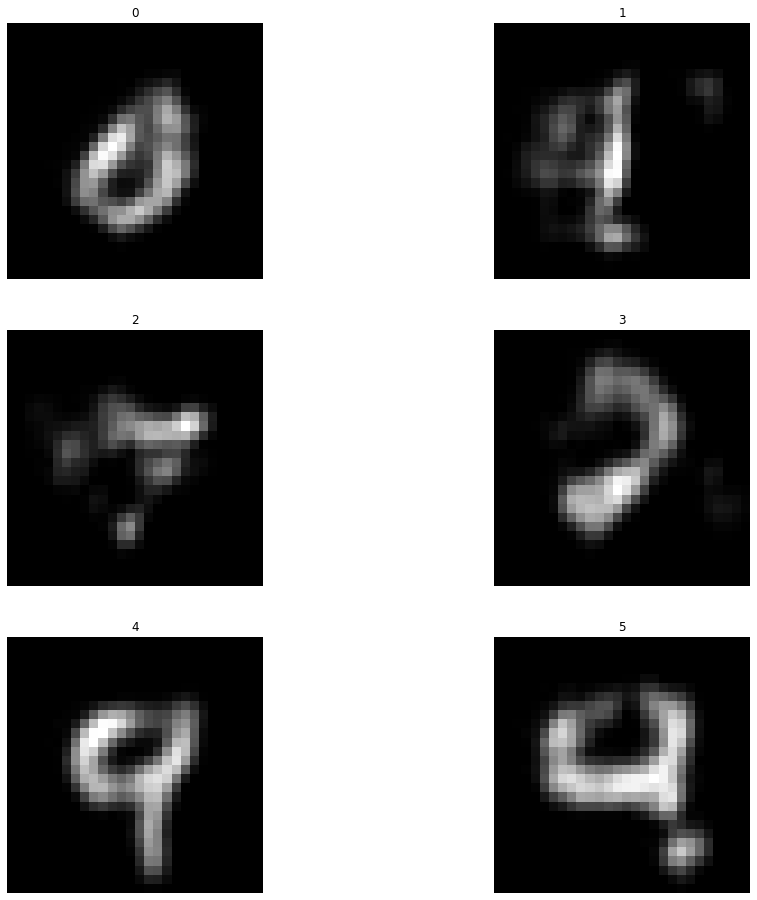

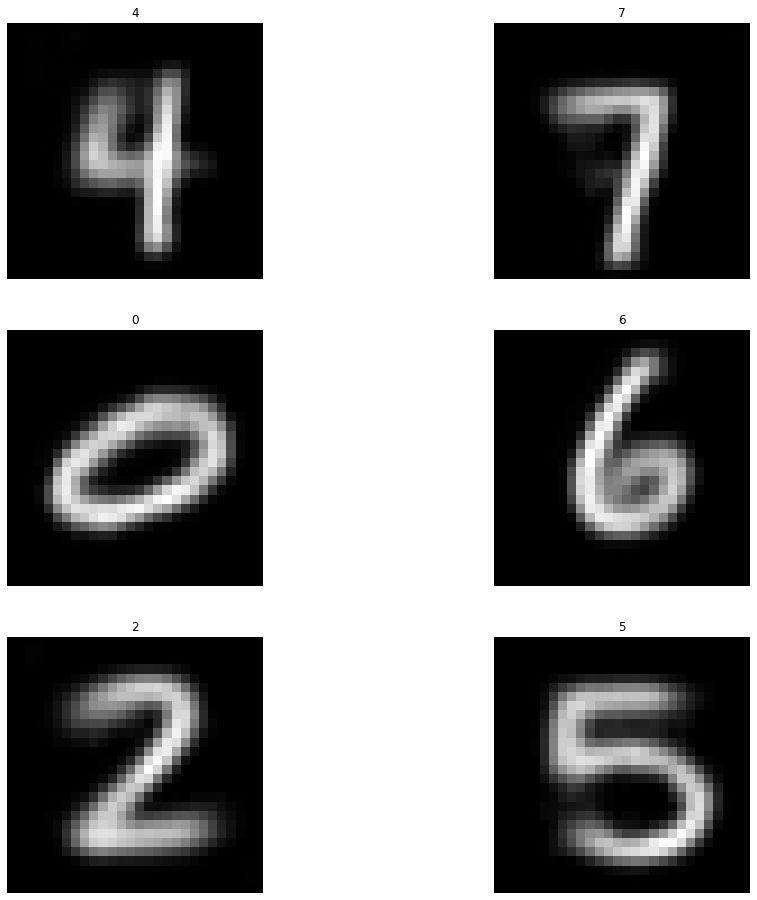

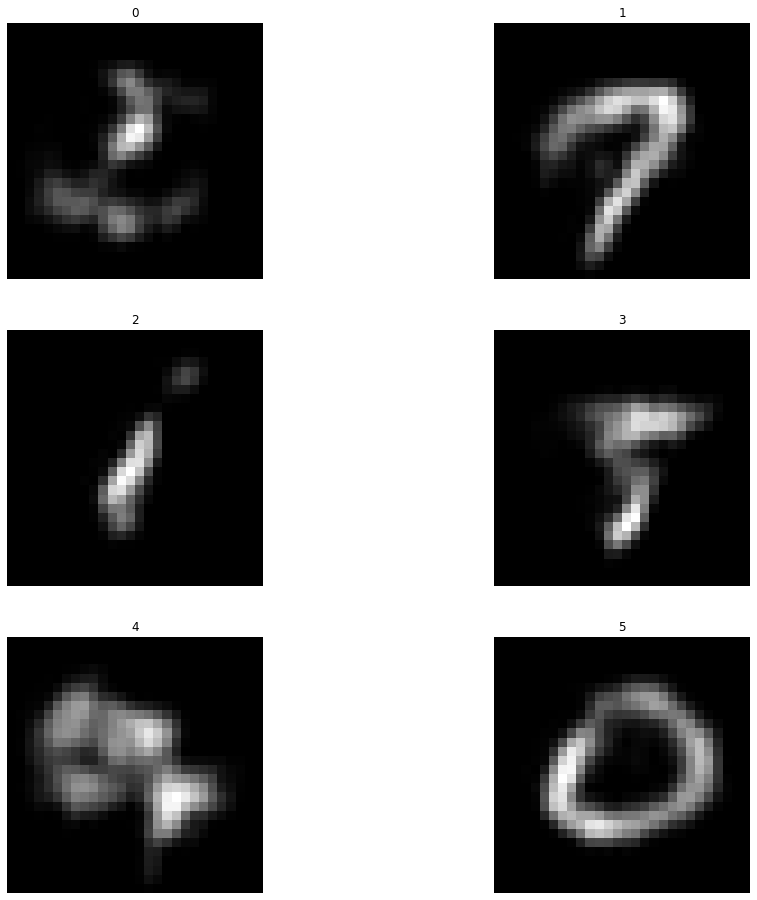

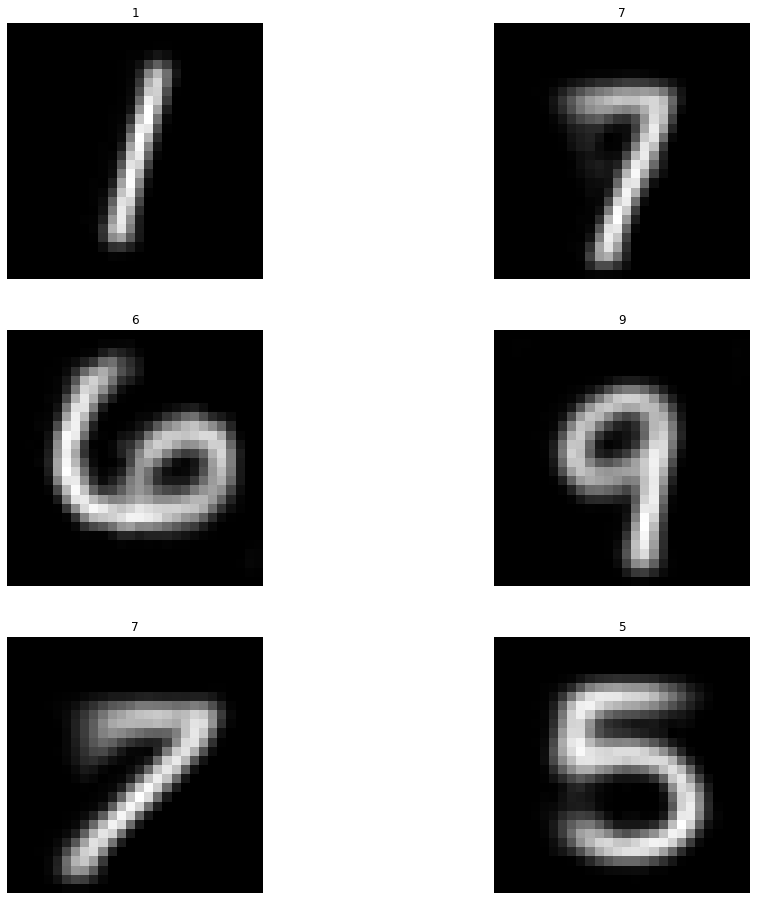

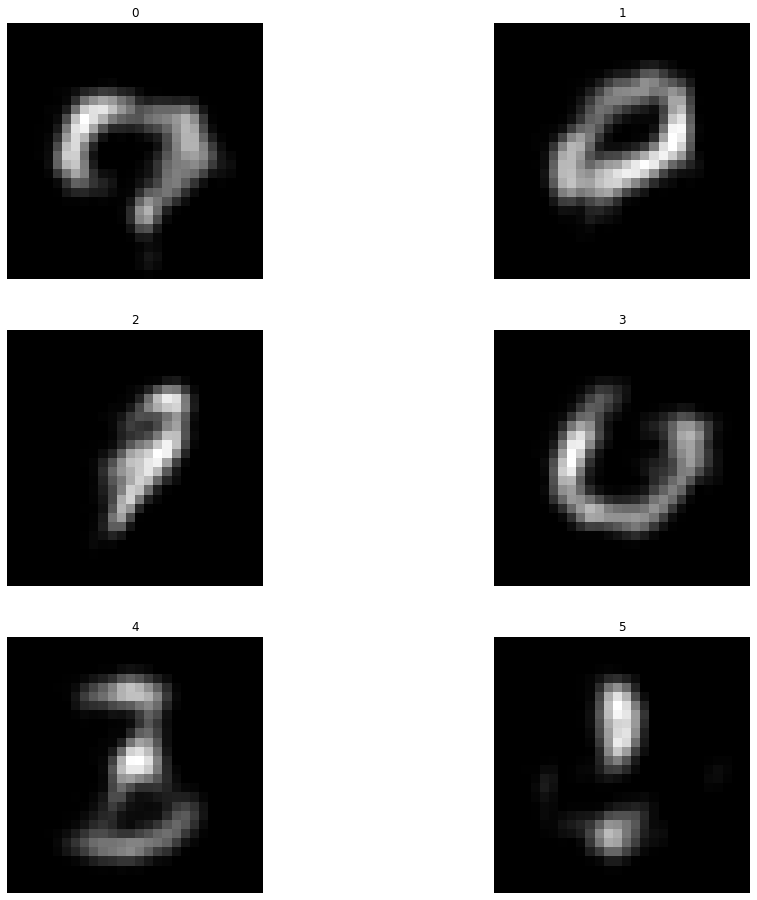

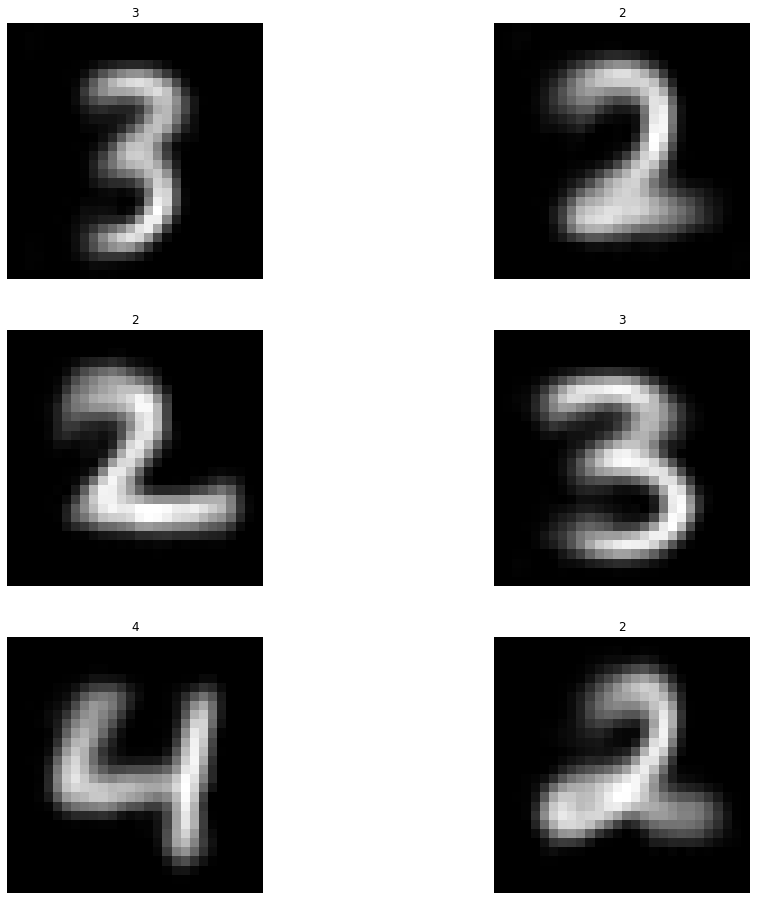

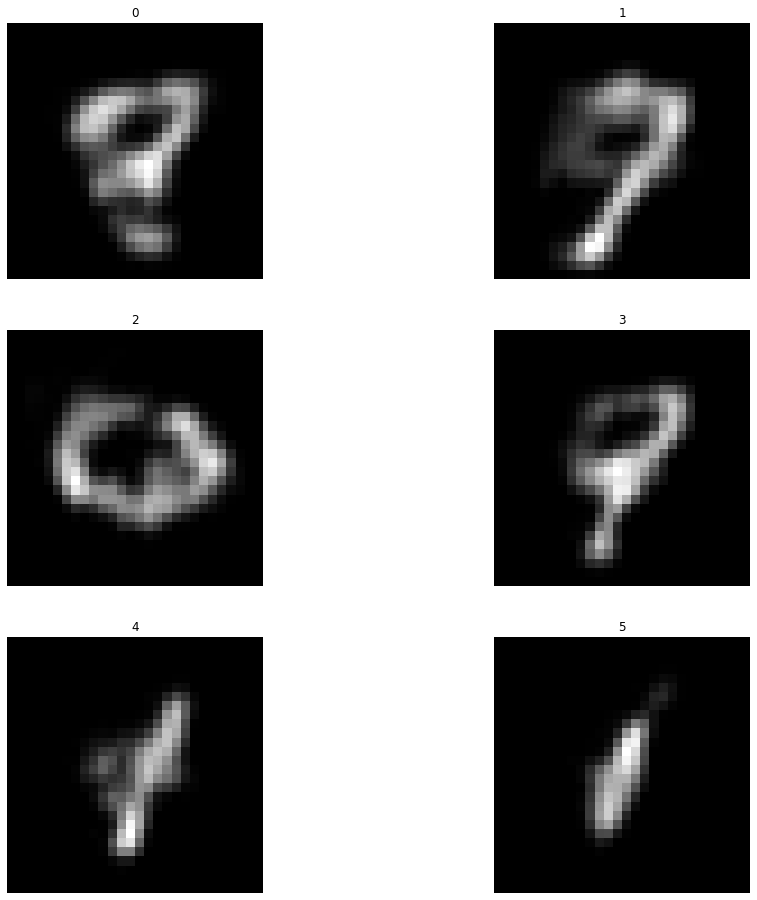

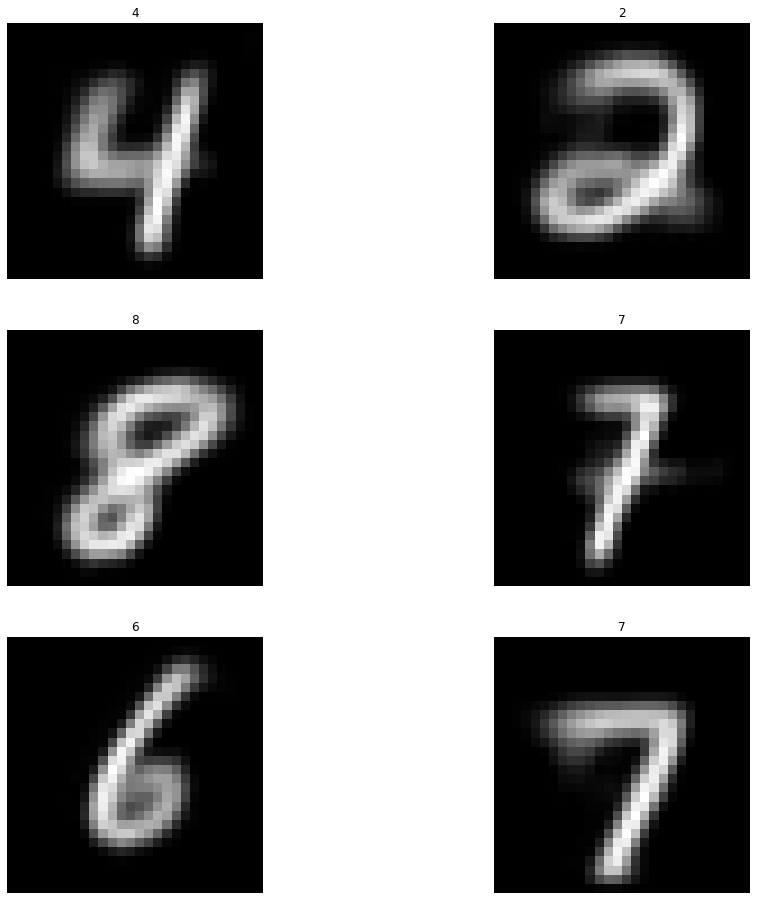

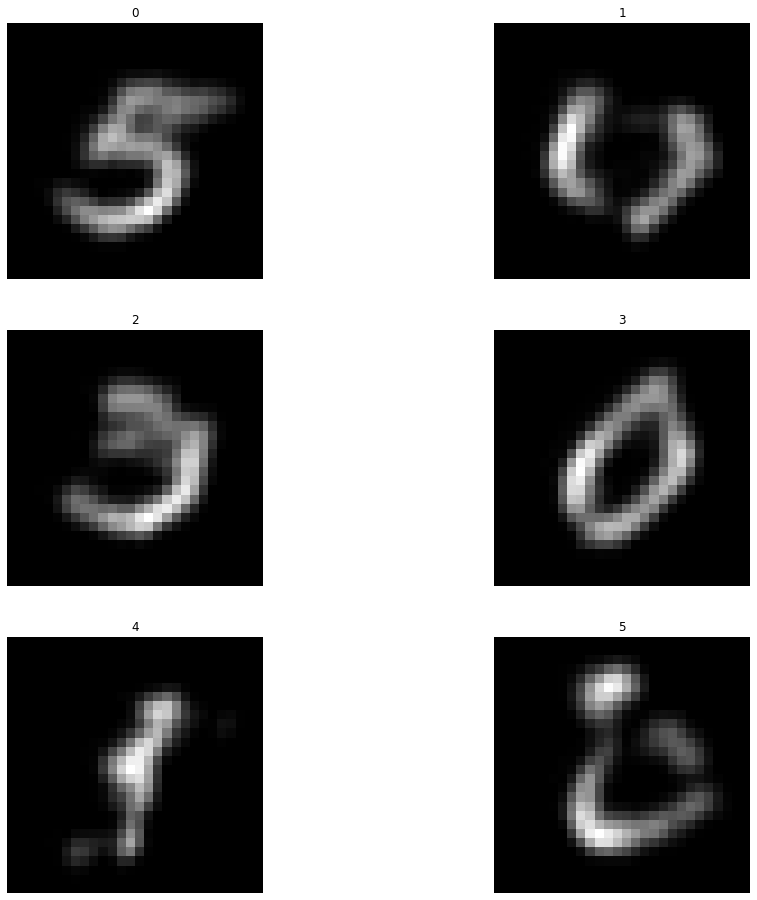

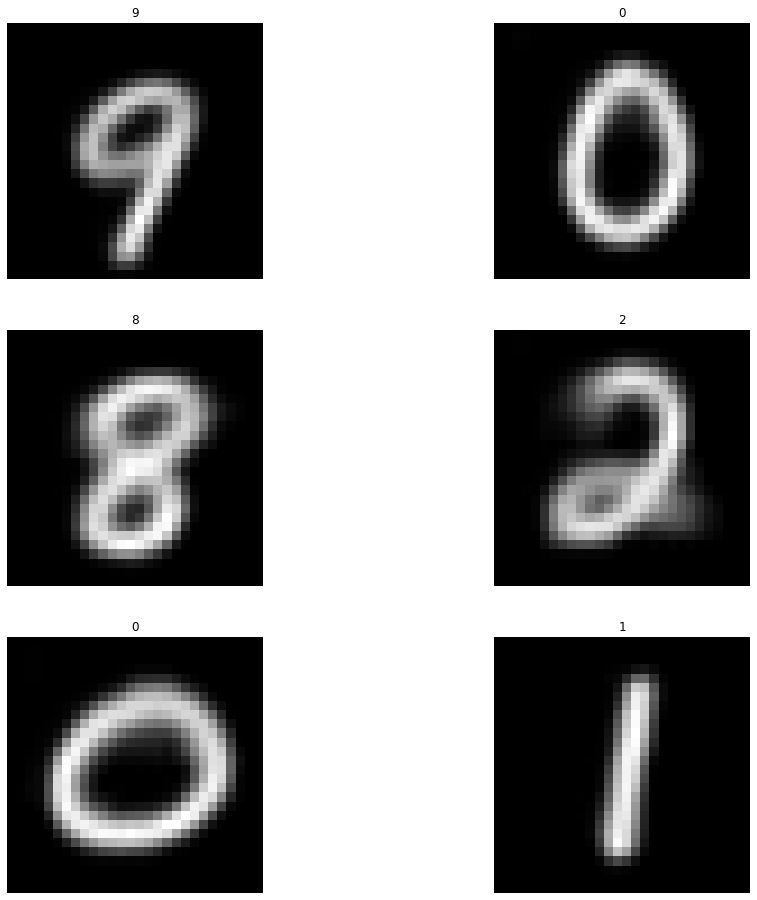

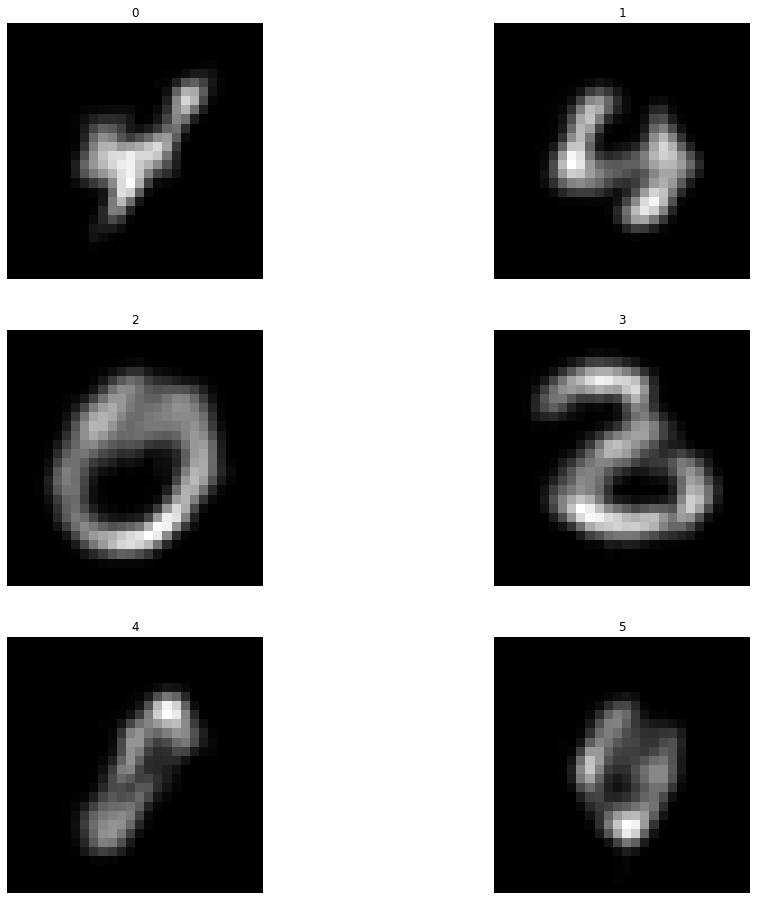

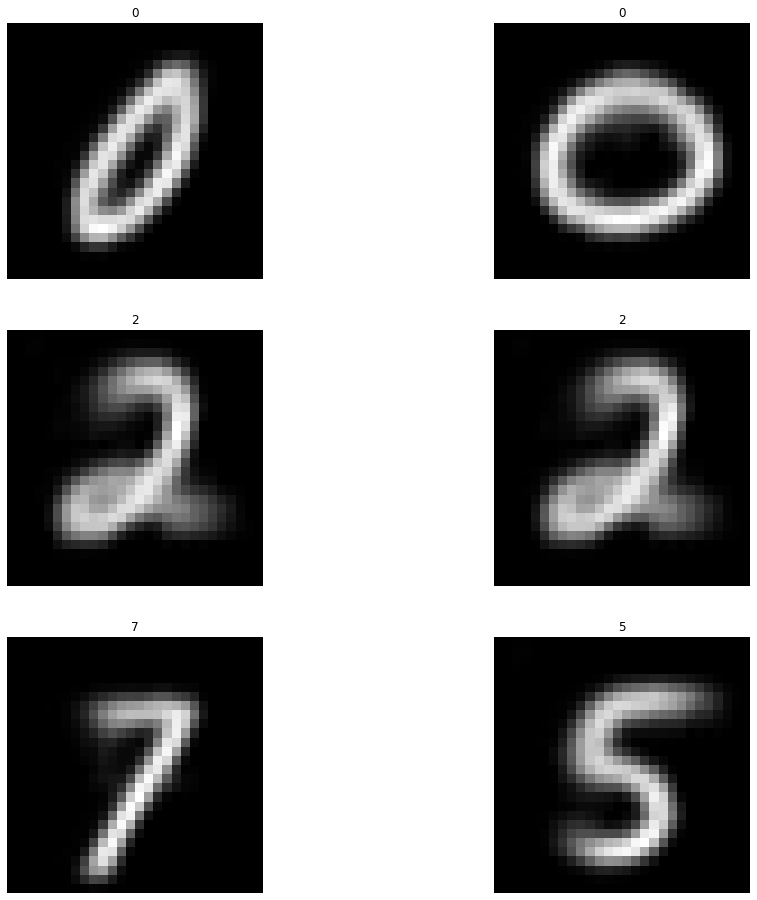

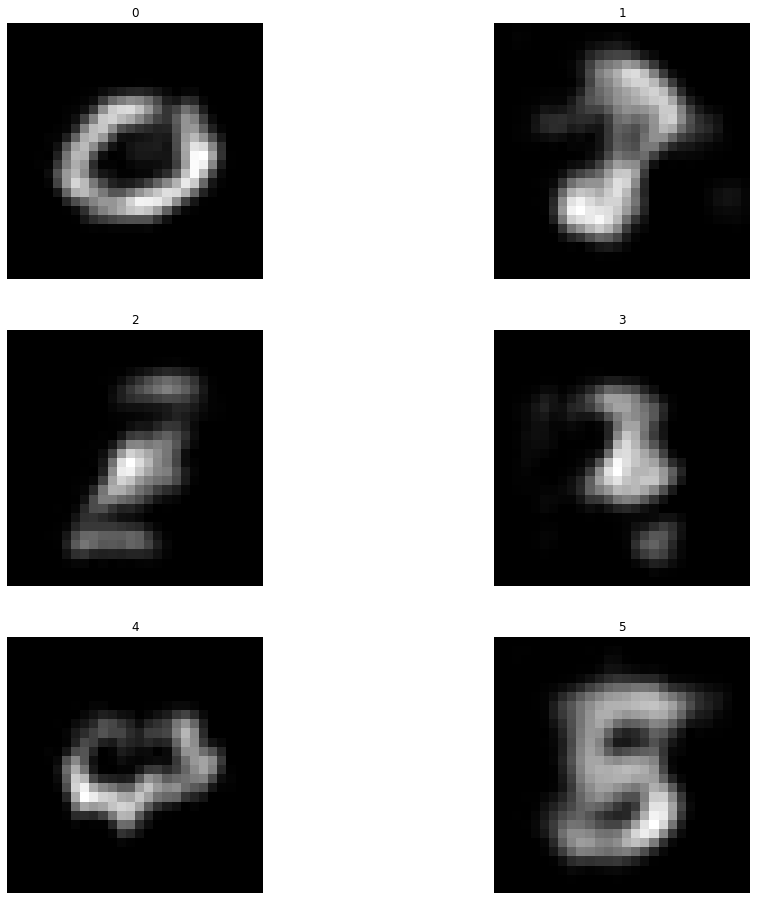

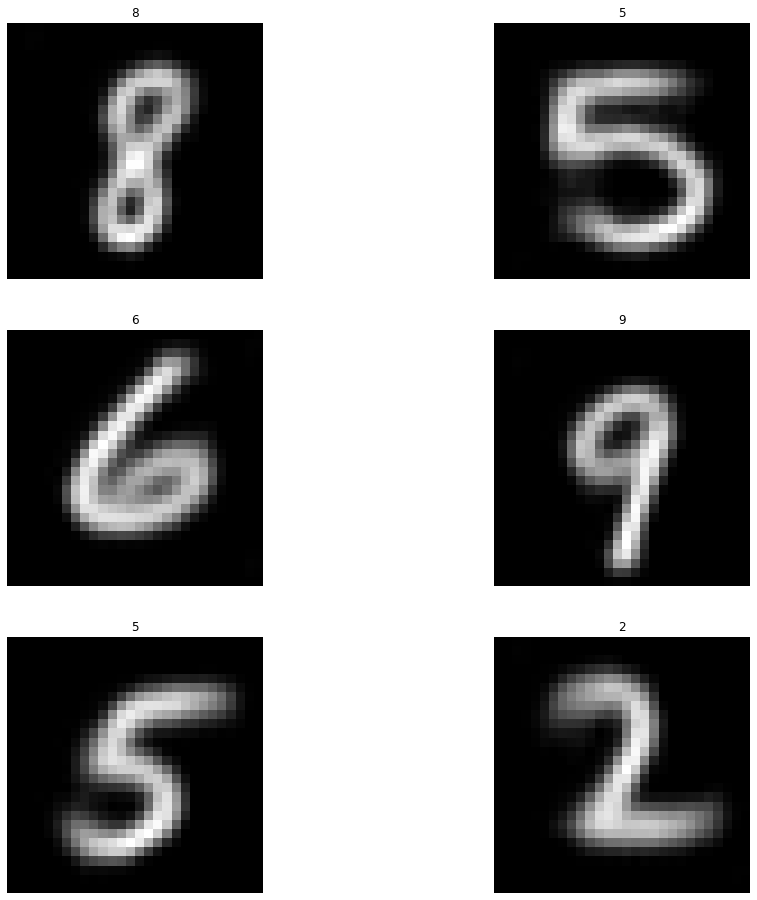

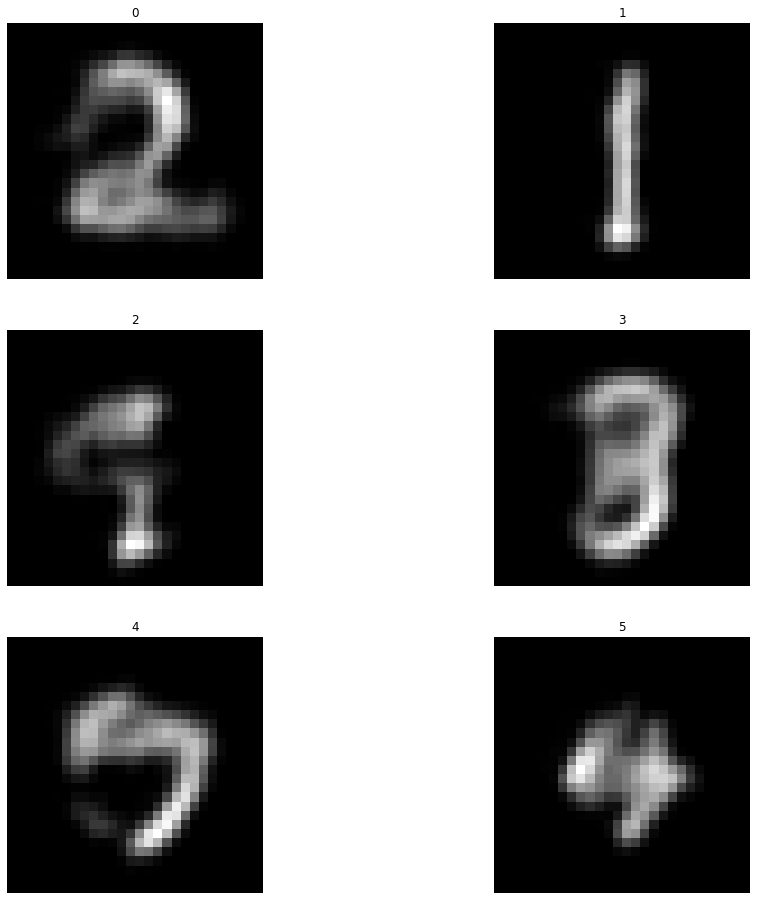

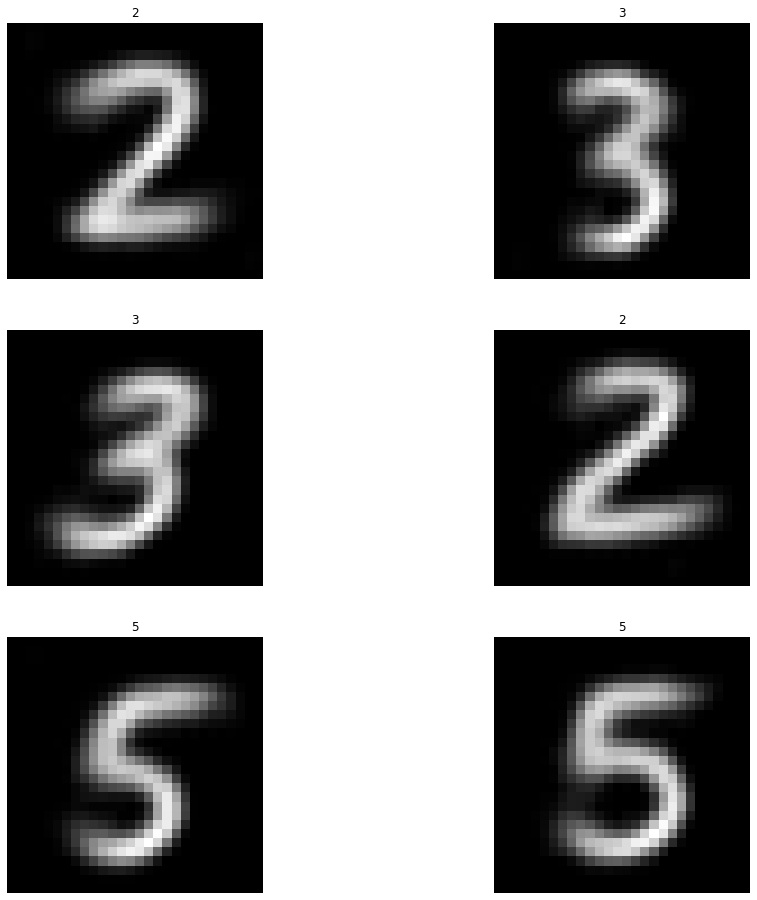

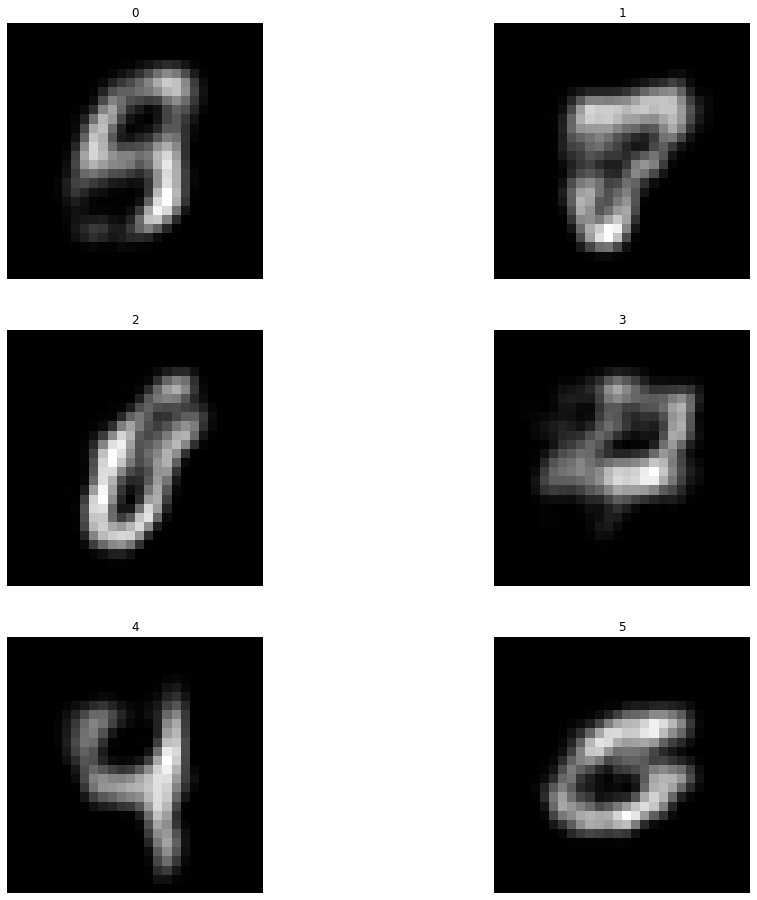

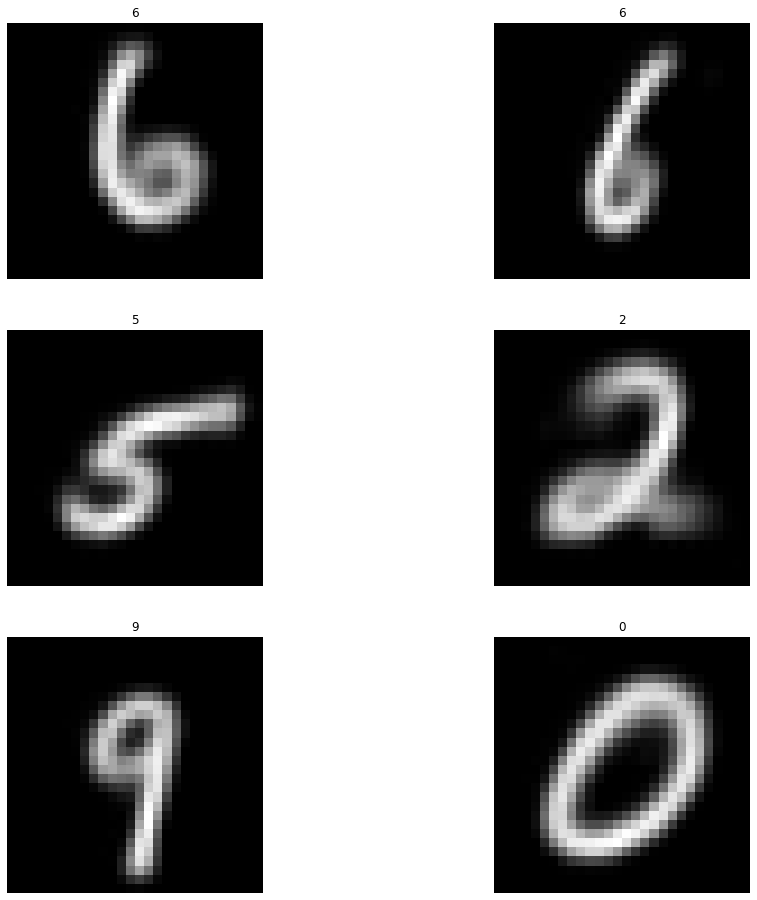

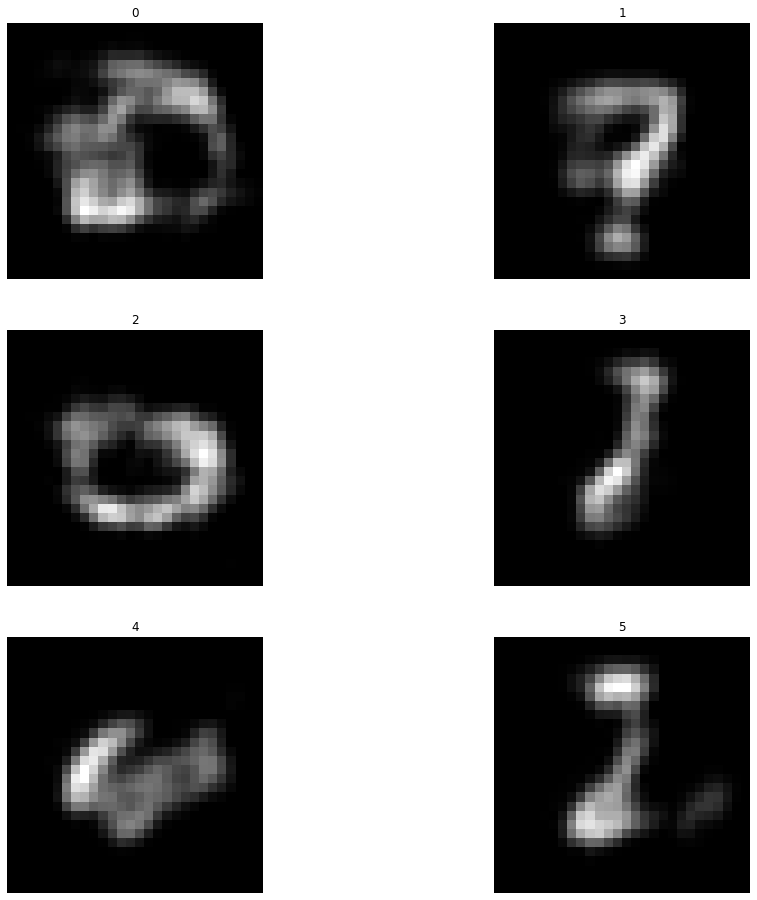

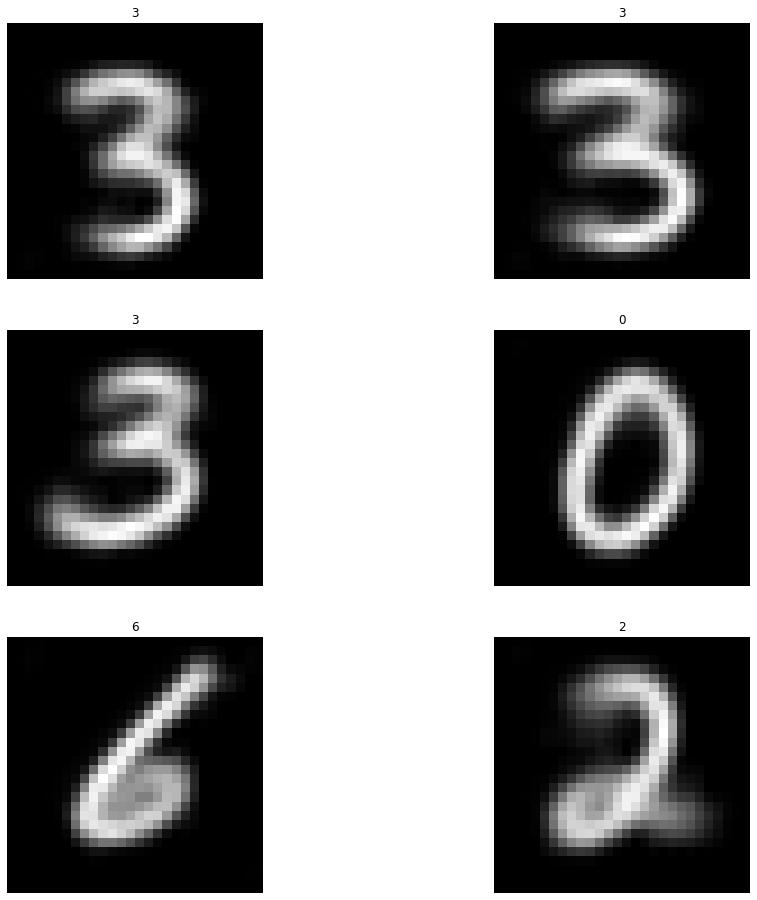

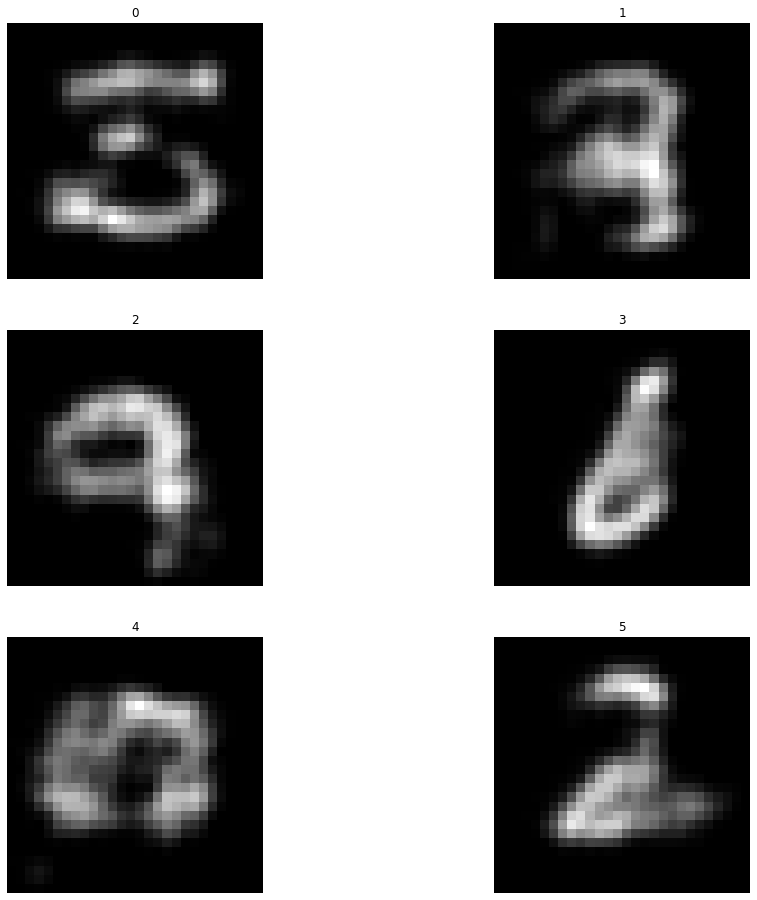

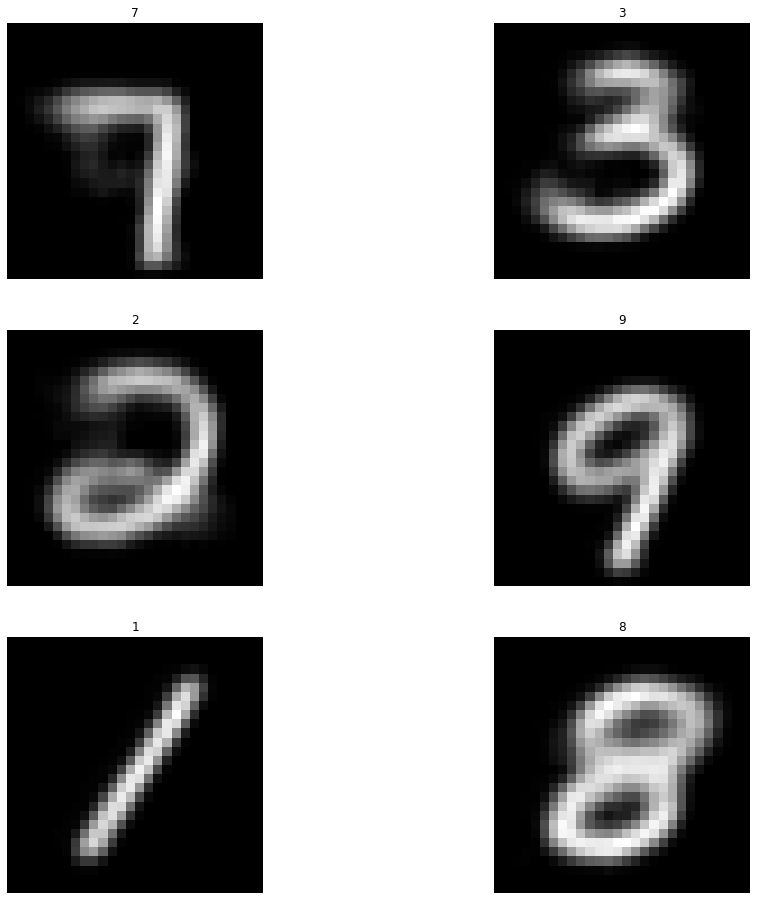

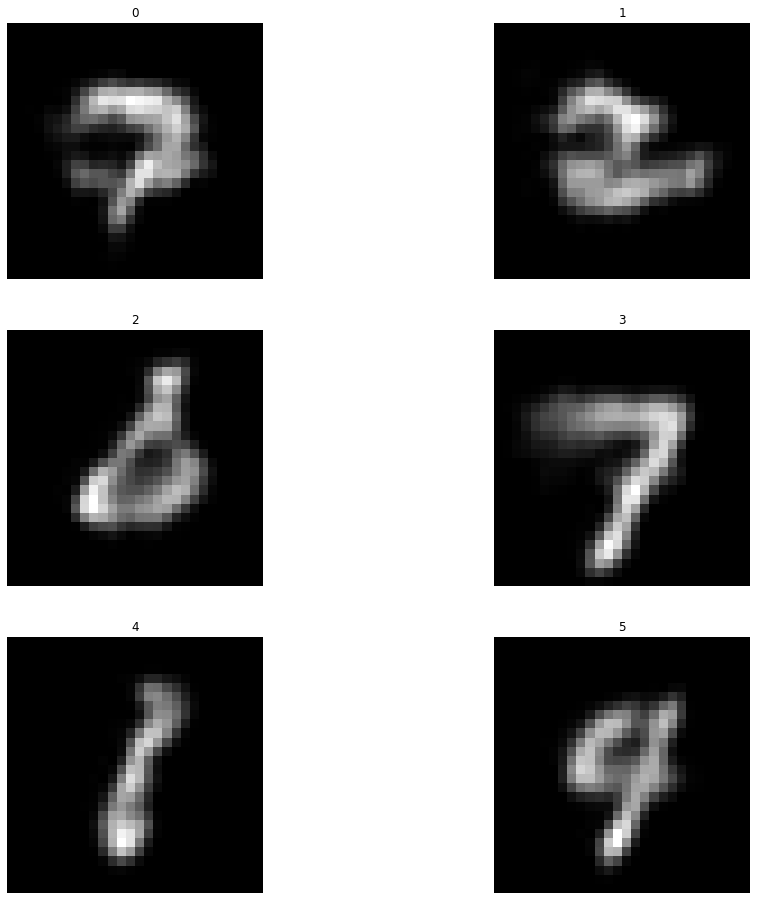

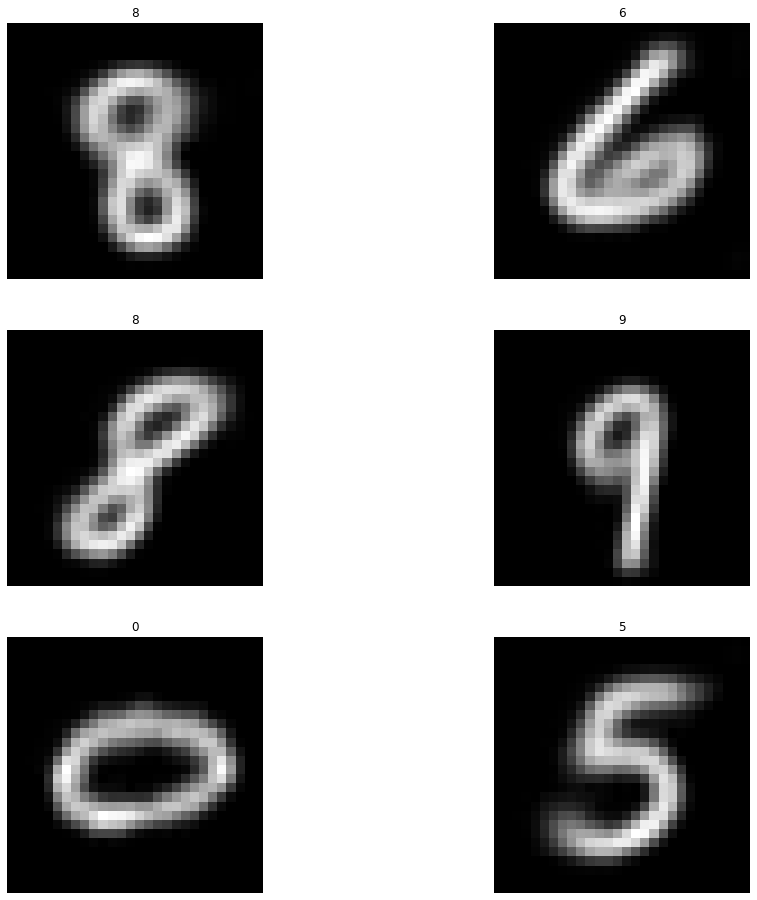

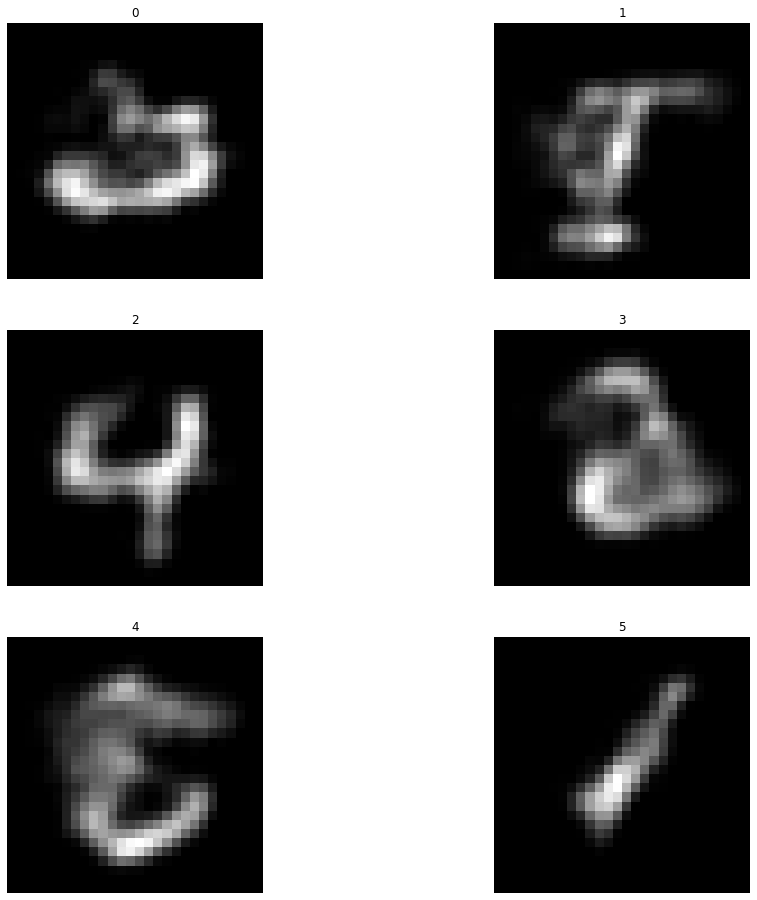

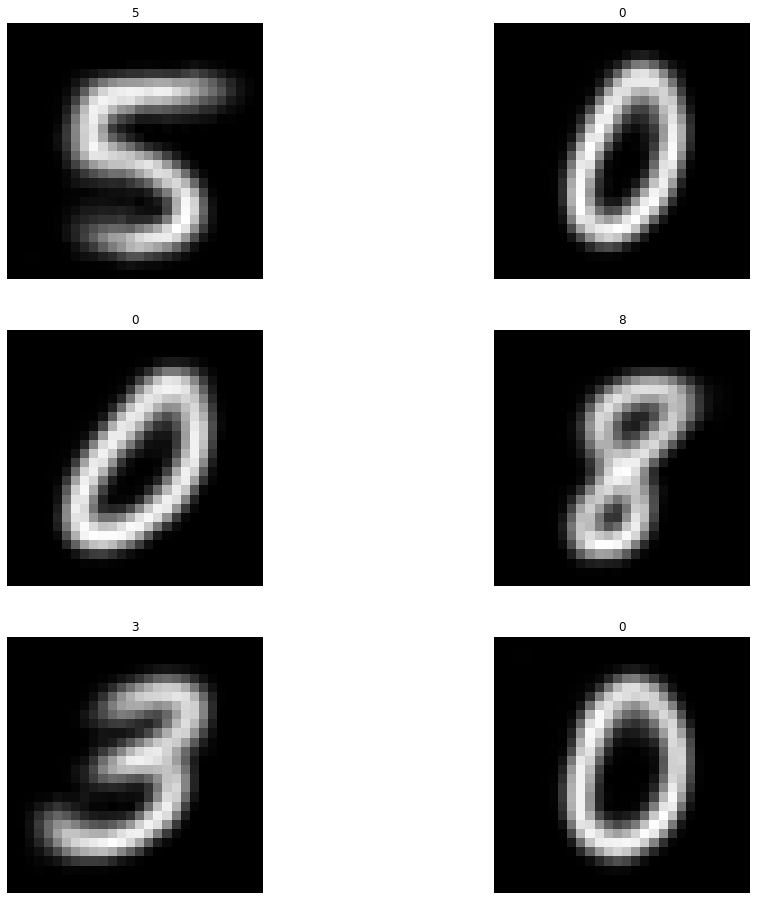

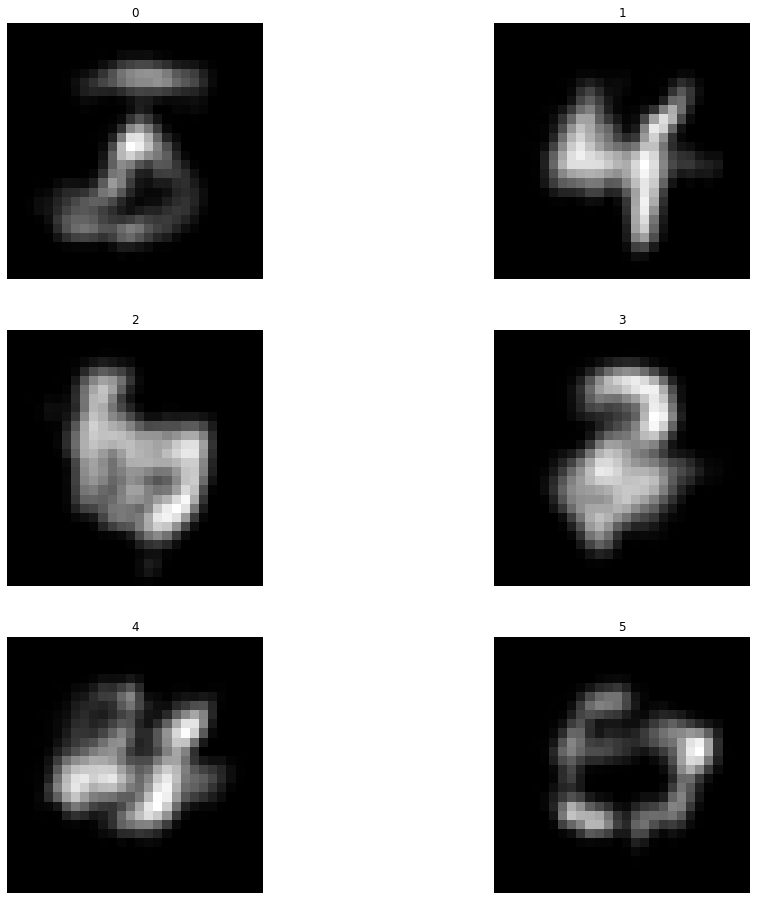

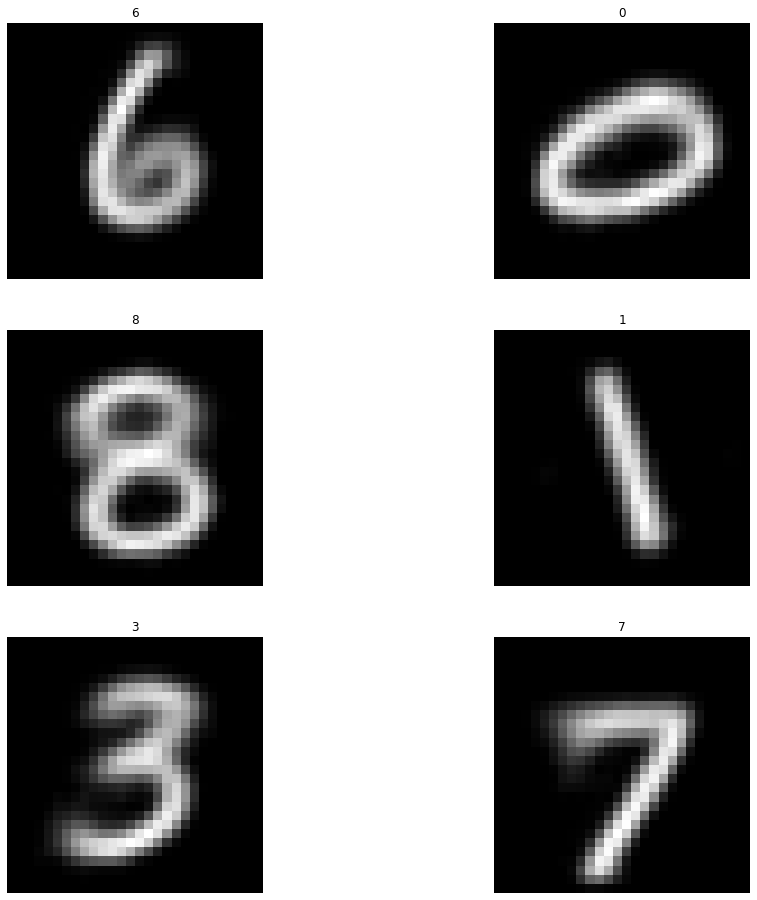

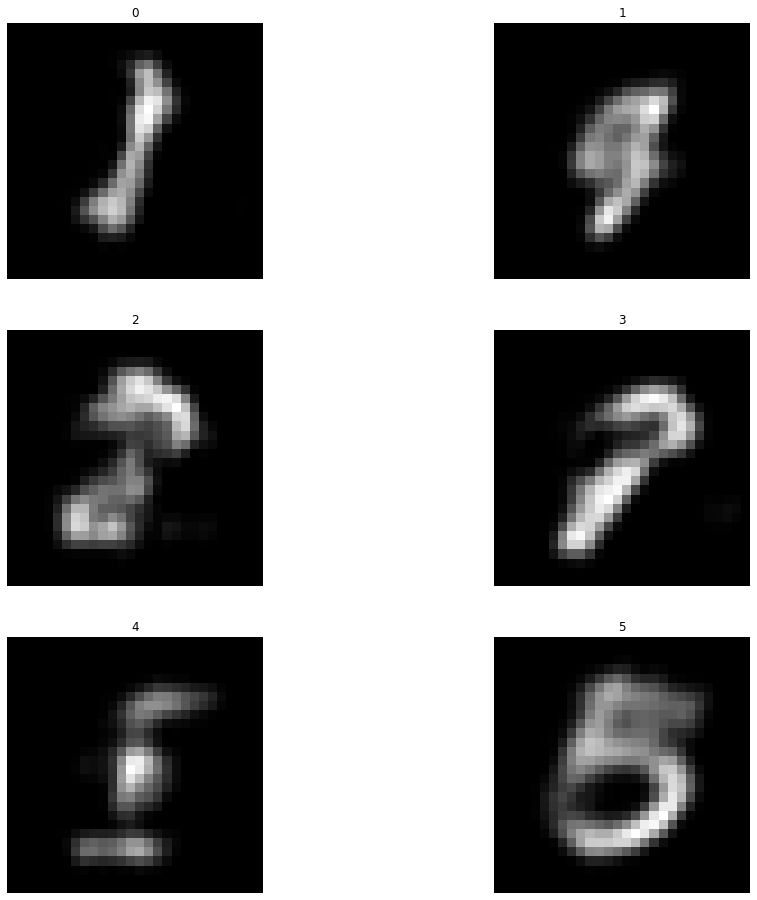

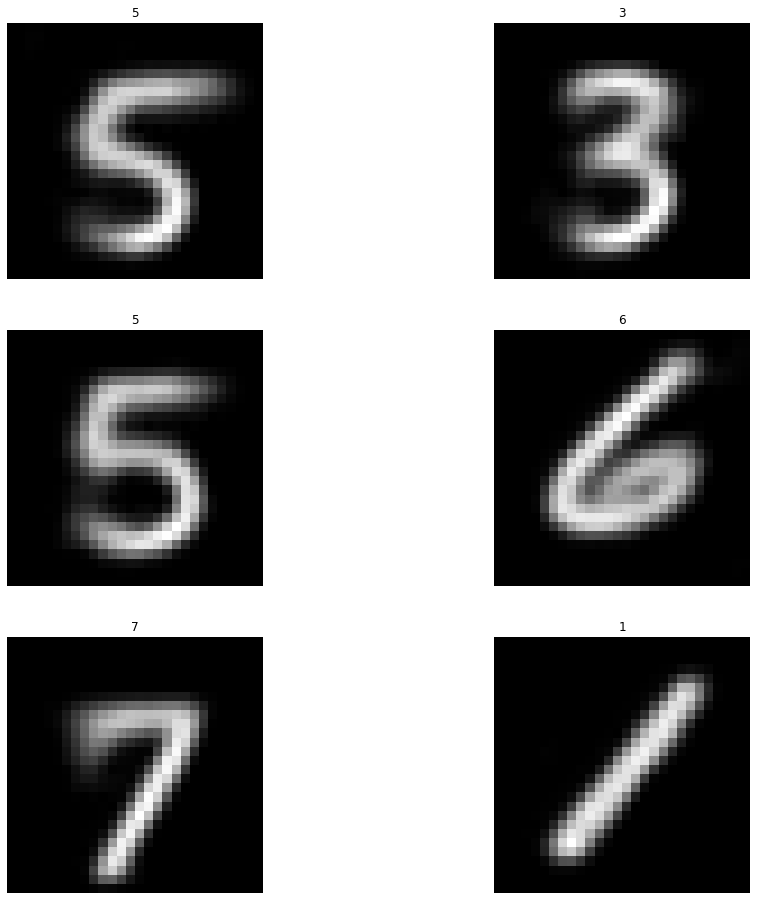

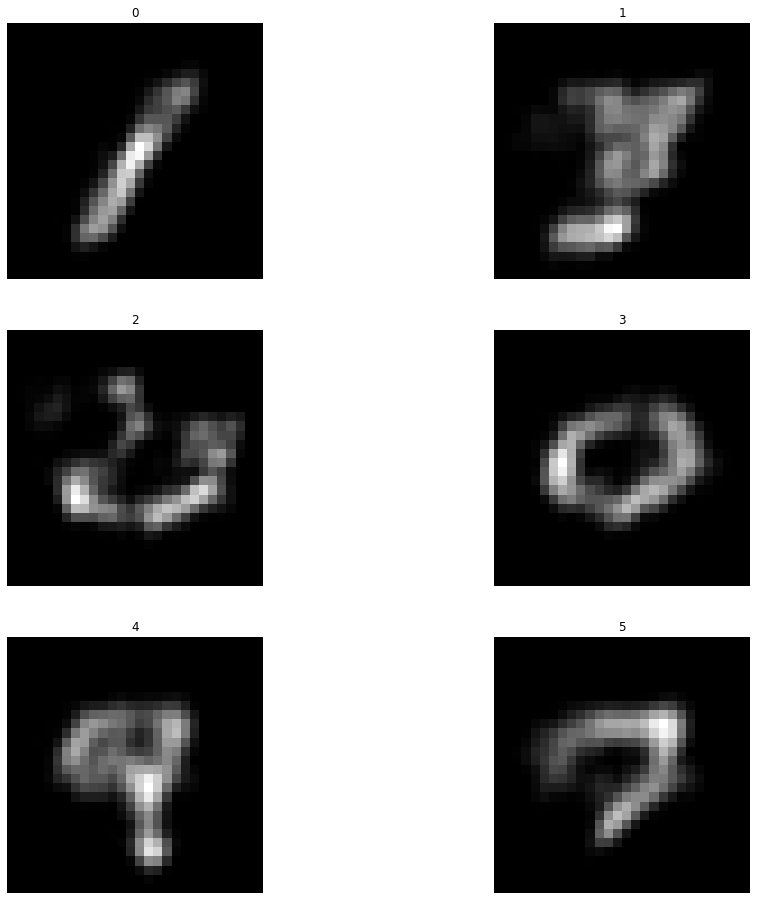

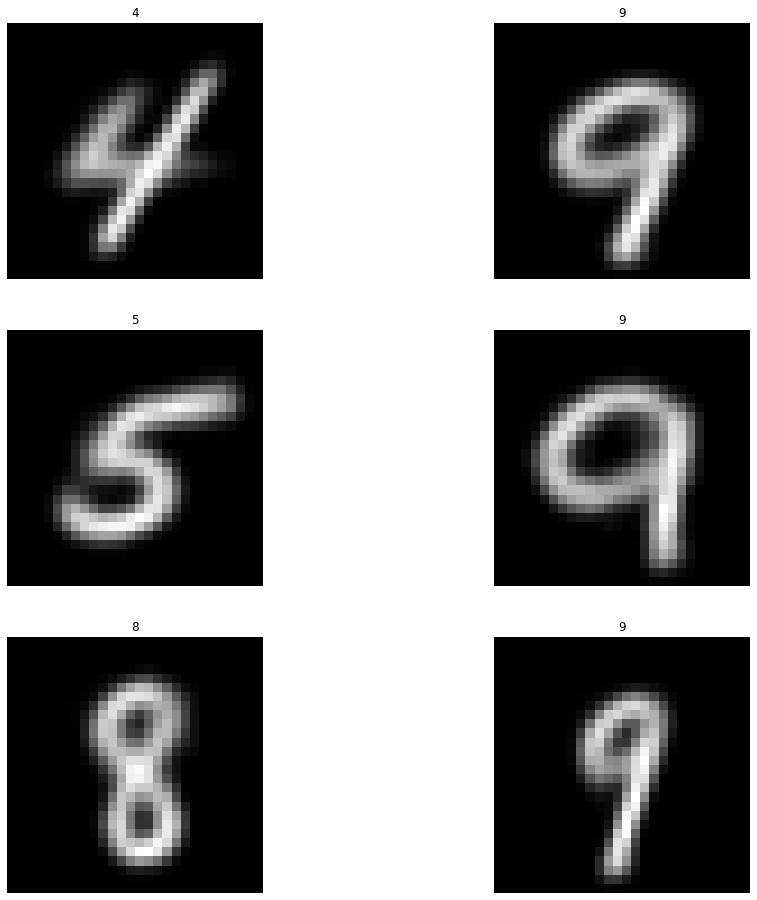

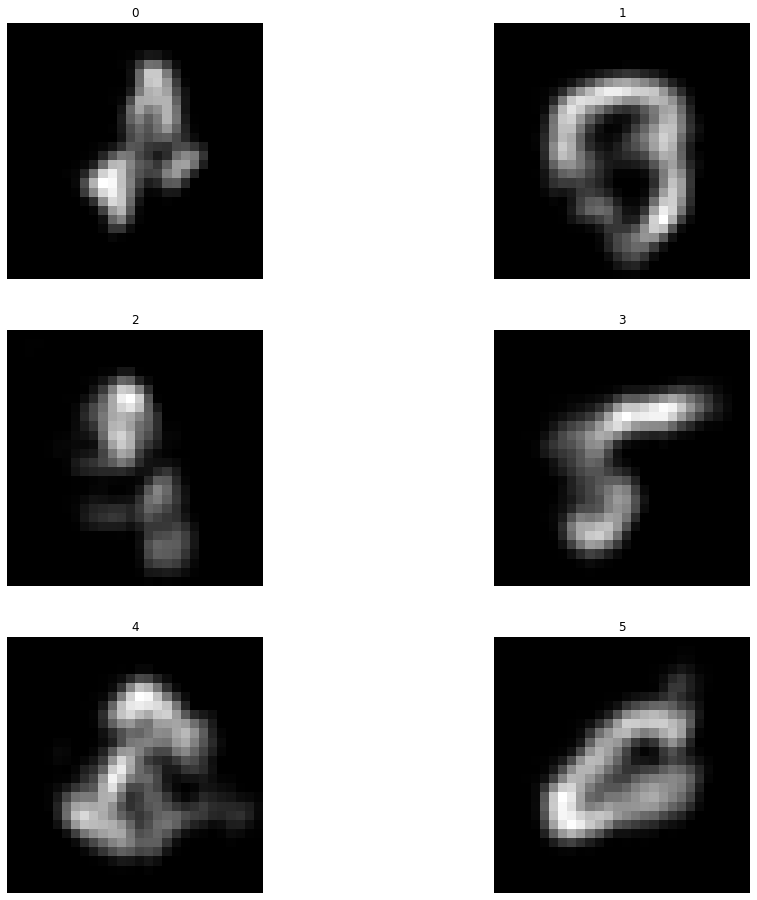

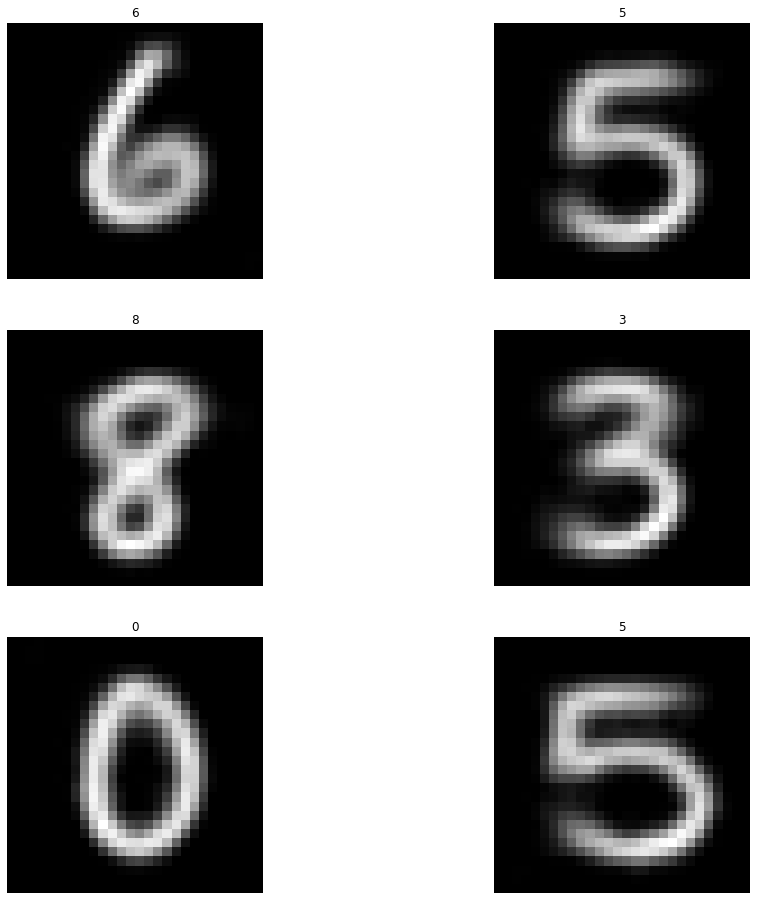

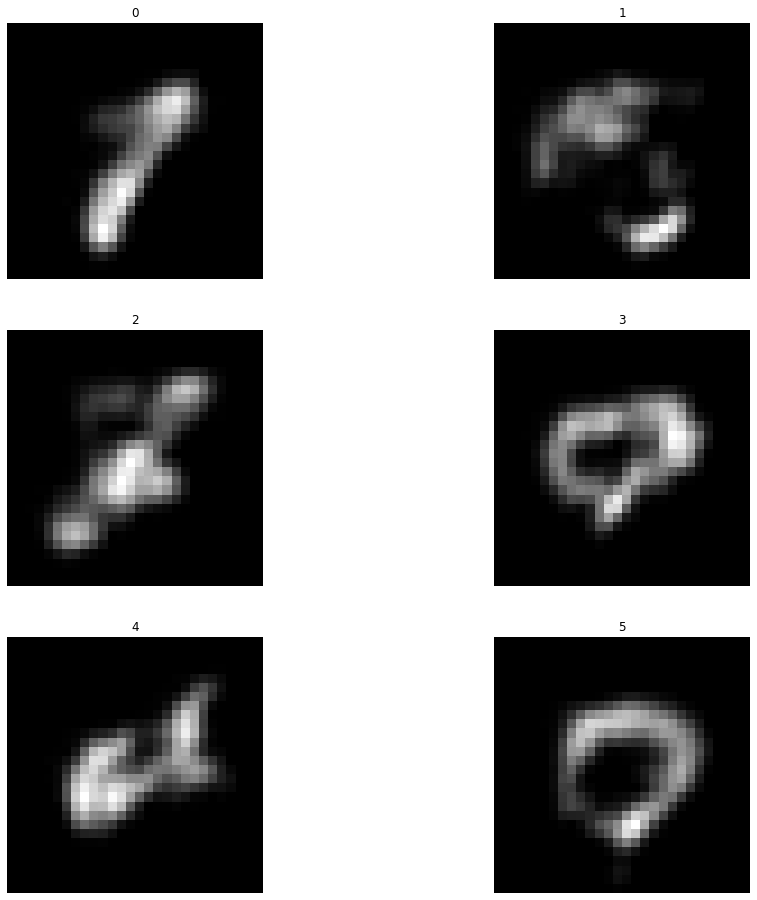

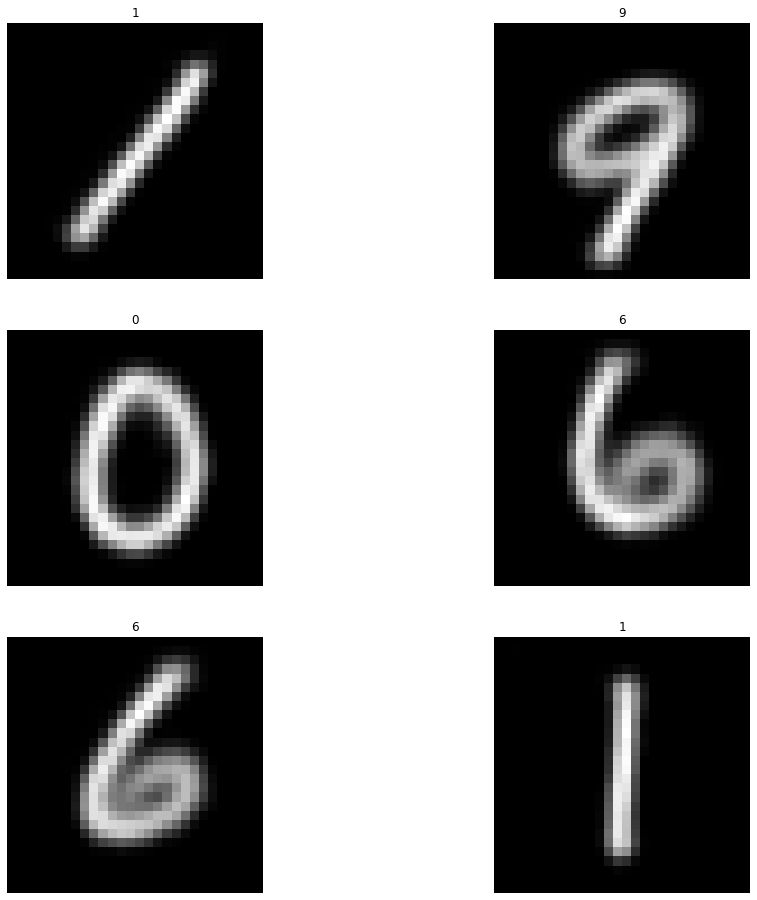

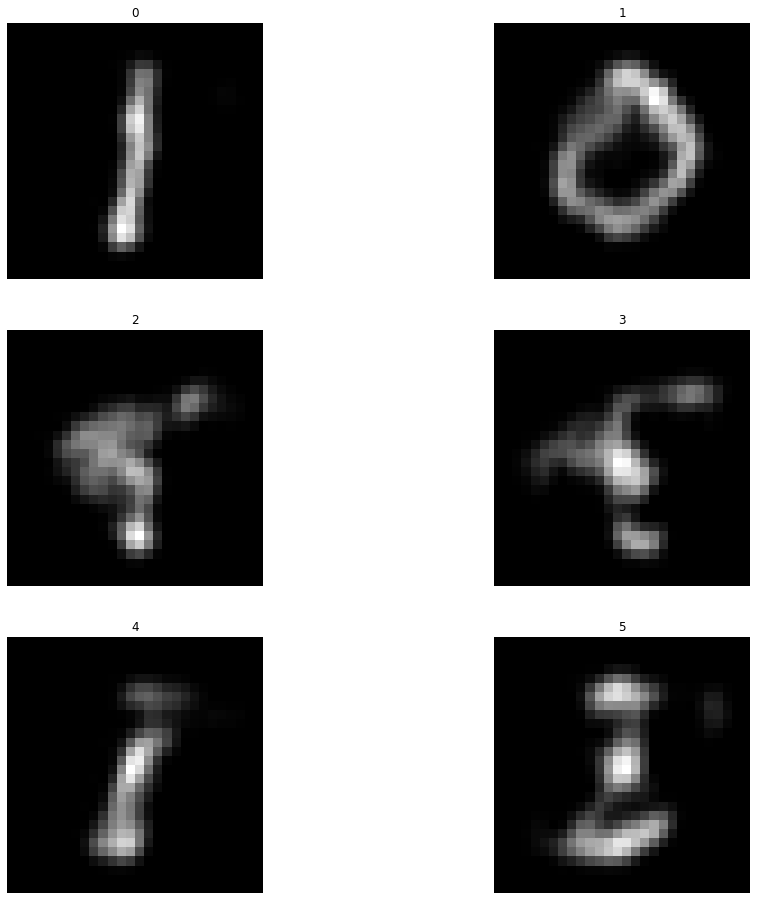

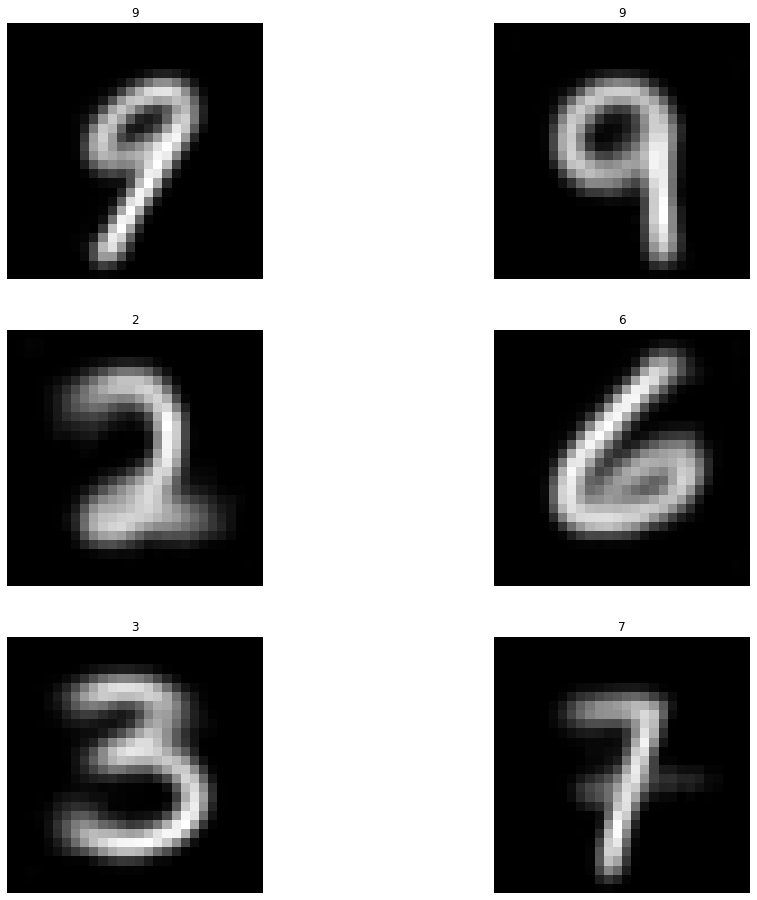

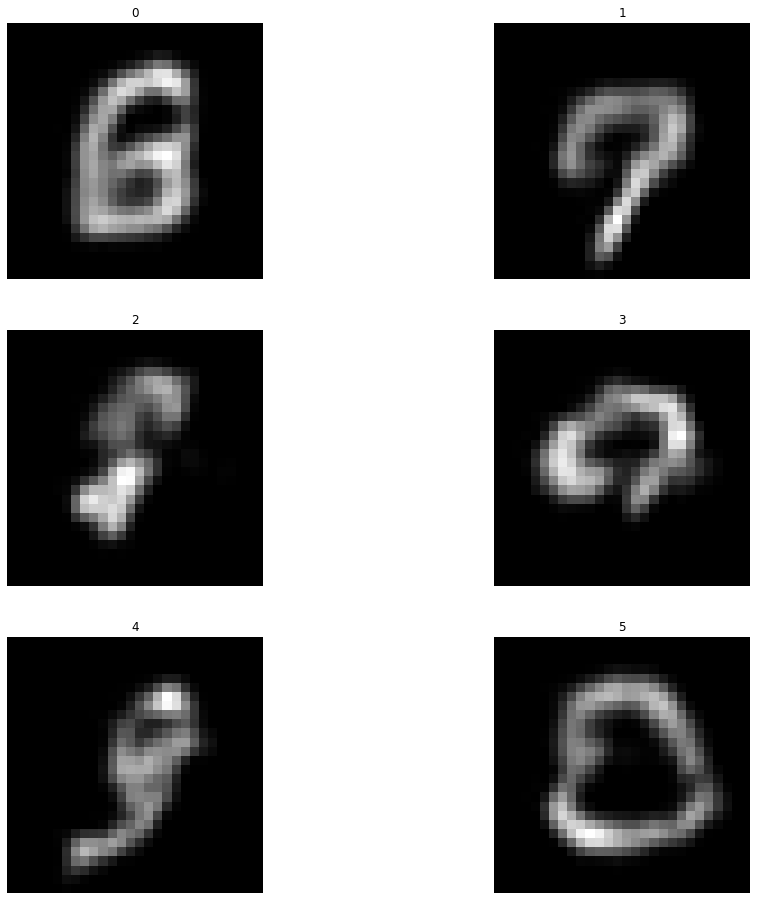

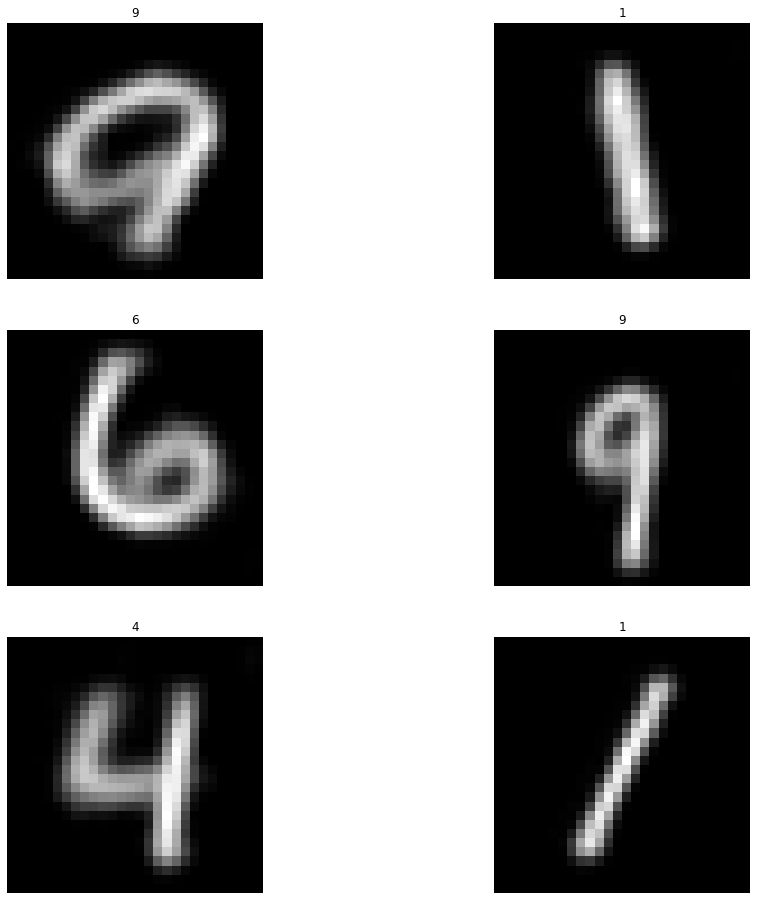

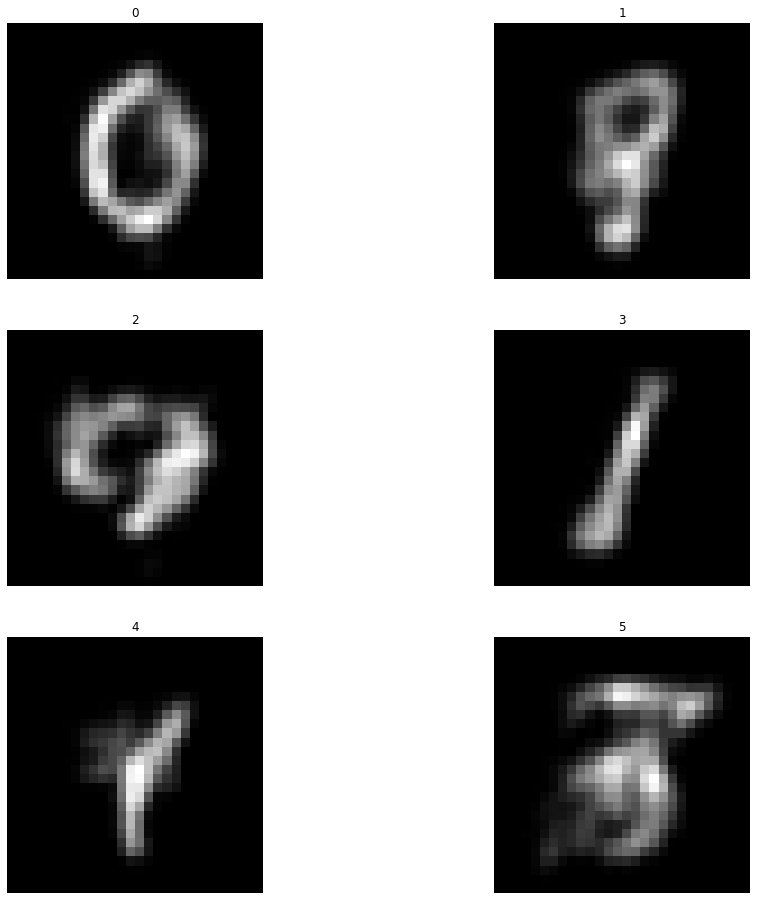

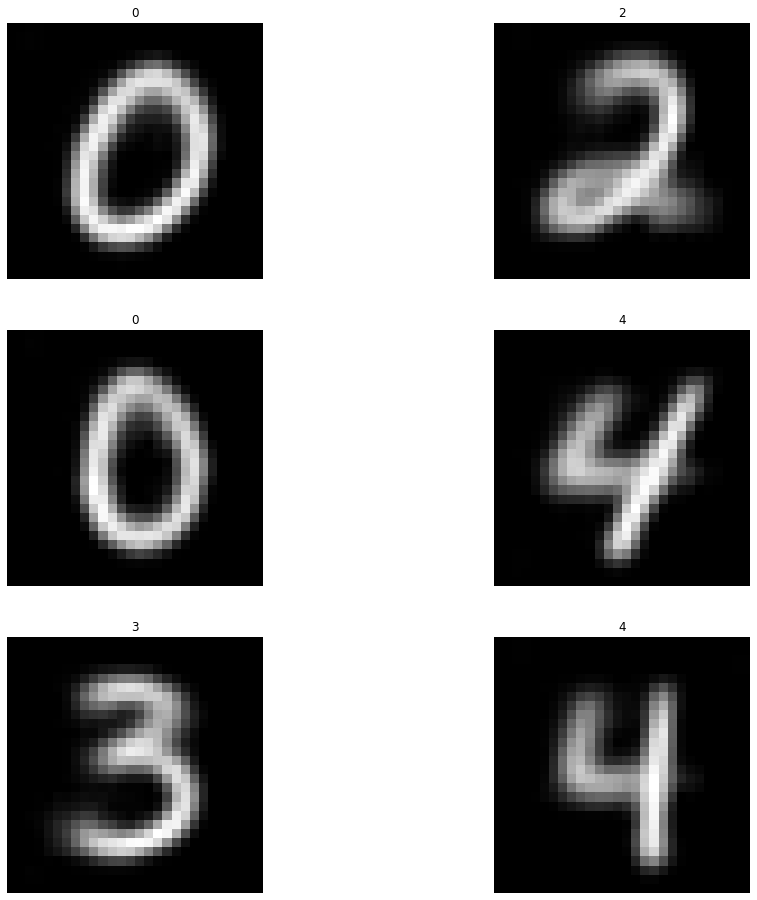

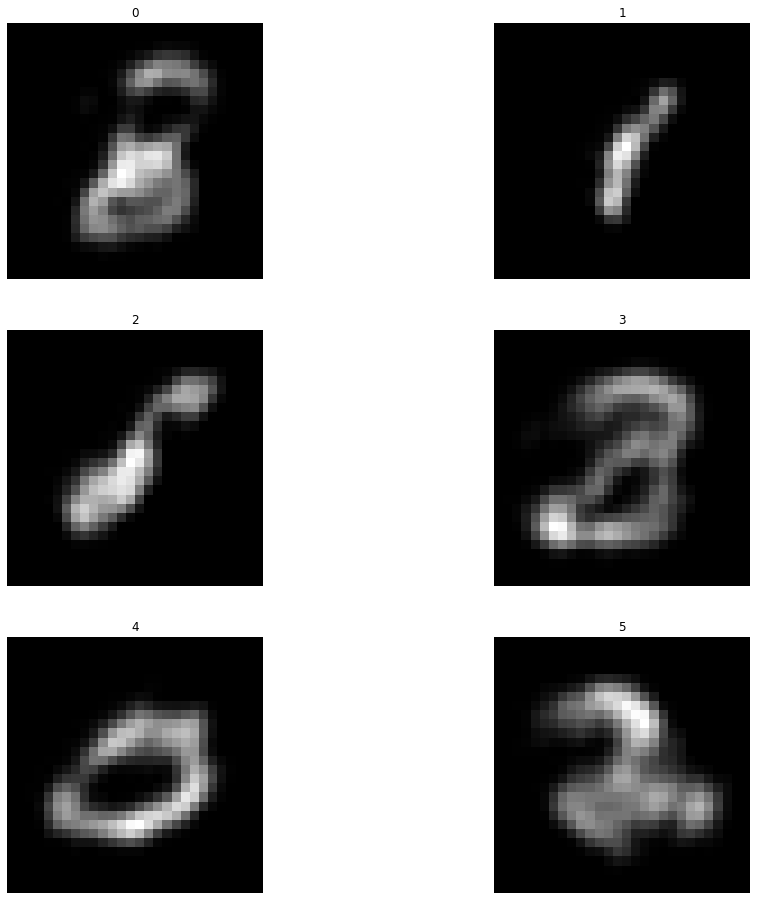

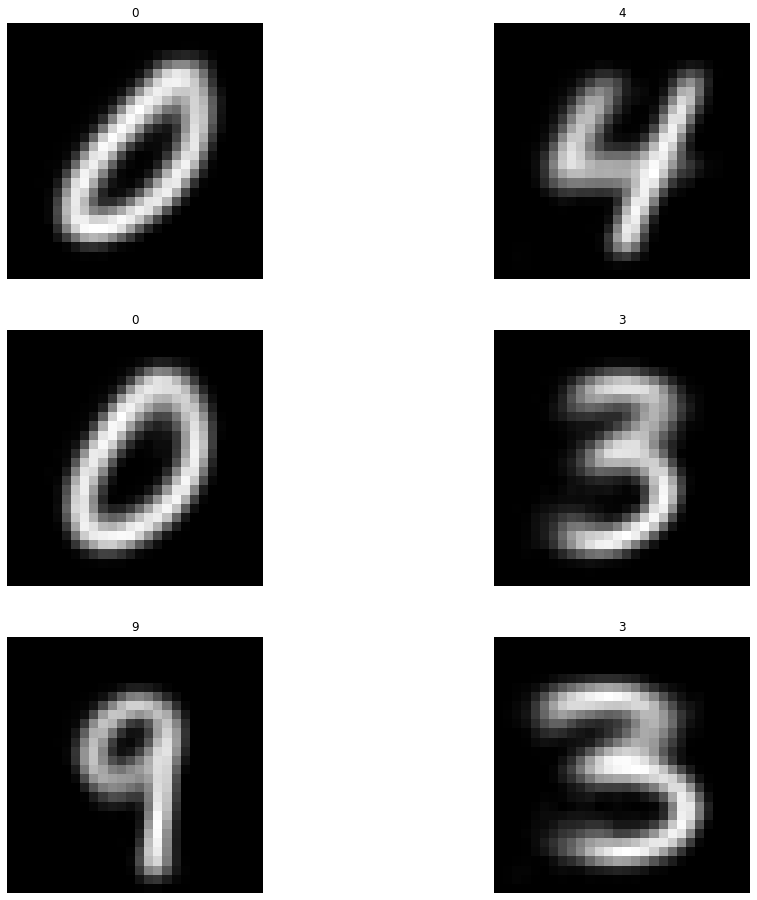

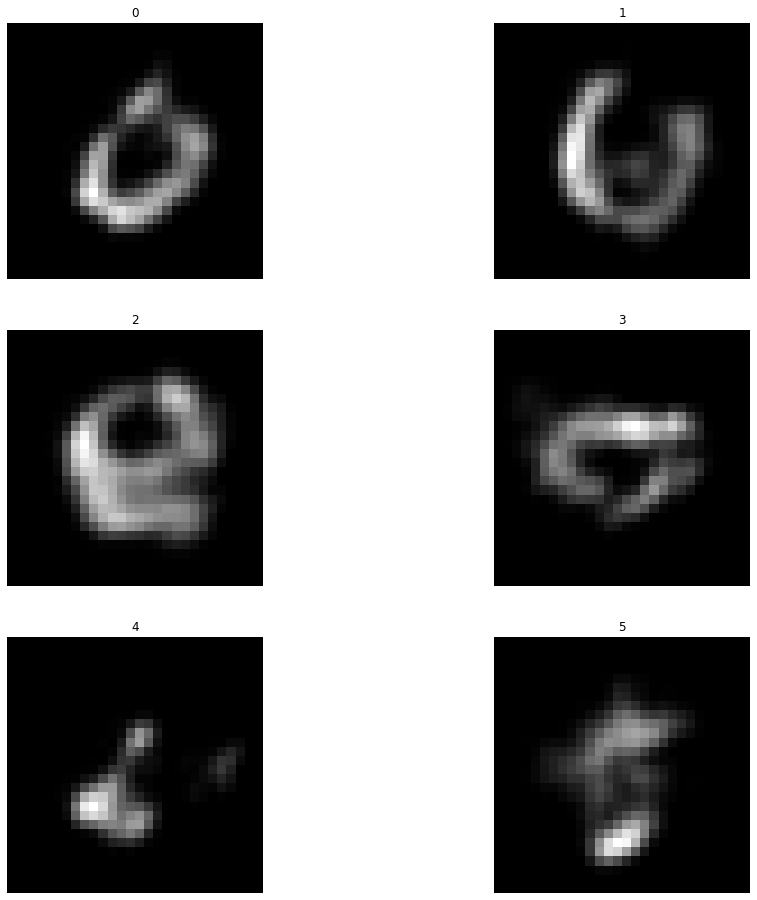

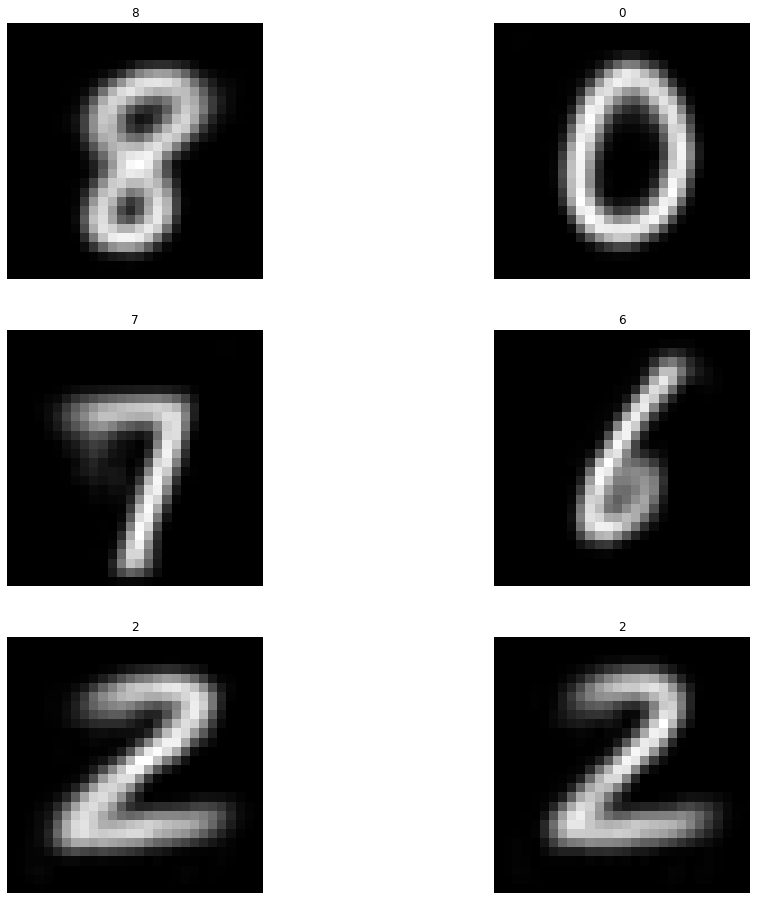

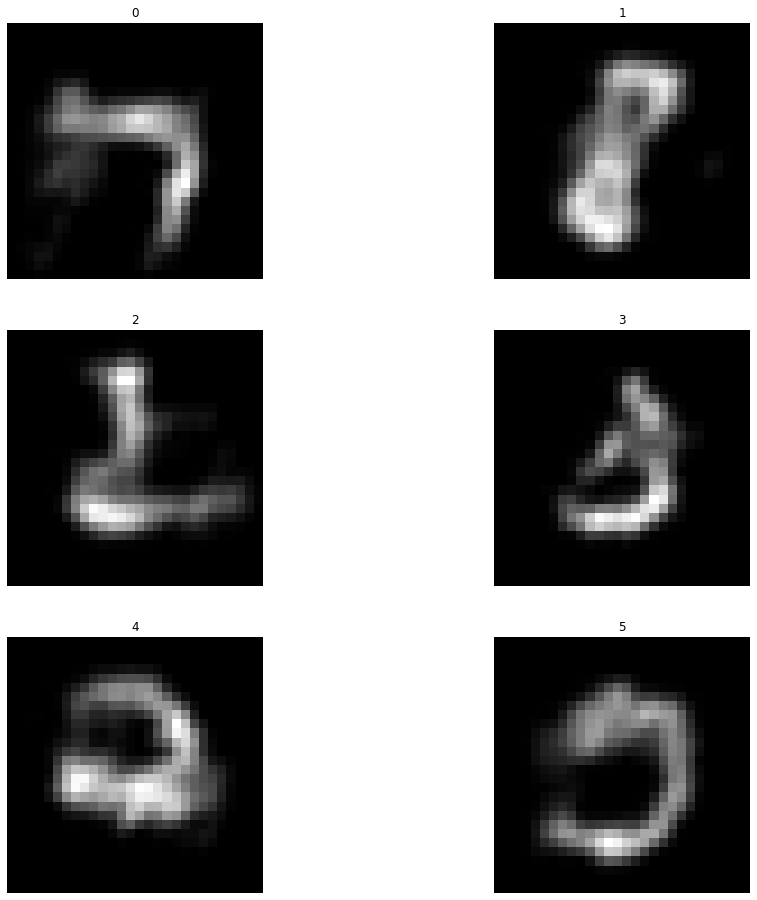

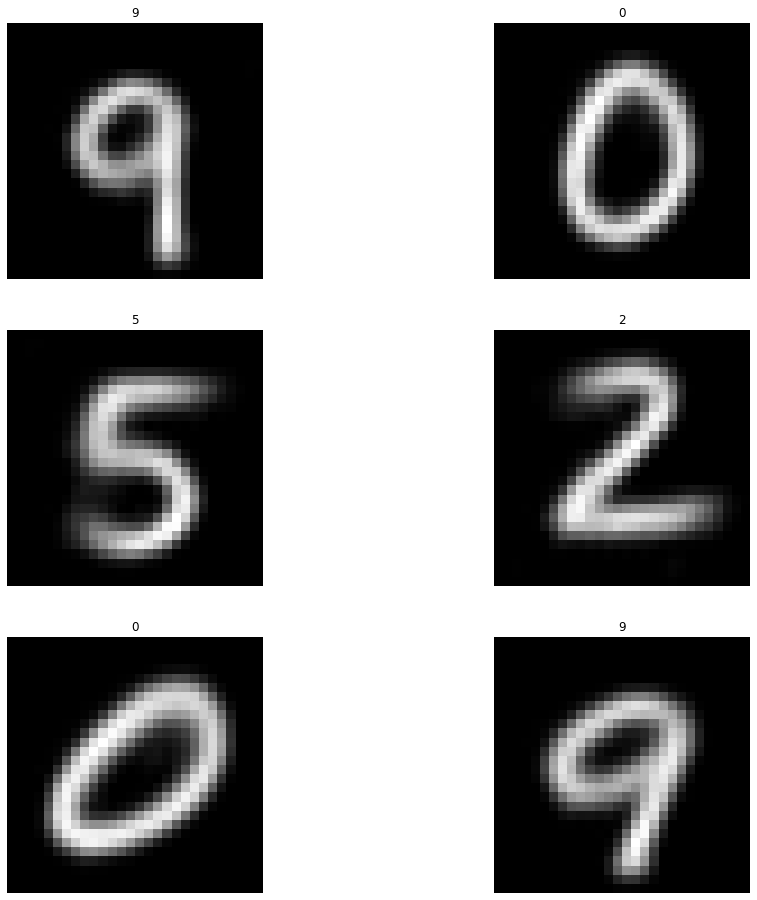

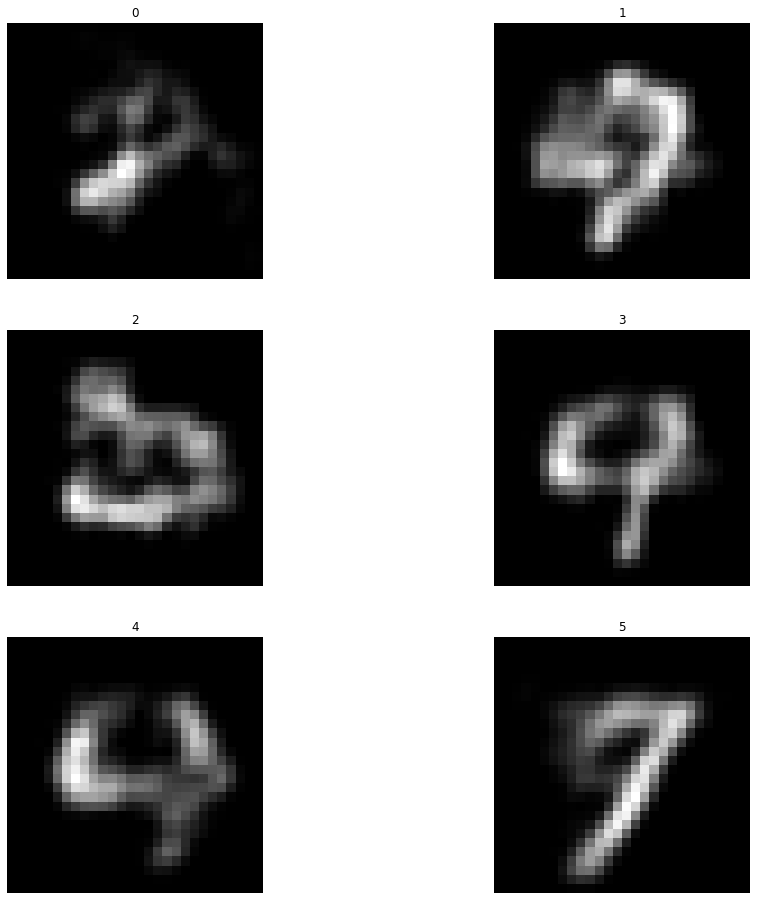

In [36]:
if __name__ == "__main__":
    train_loader, test_loader = load_data()
    print("dataloader created")
    model = Model().to(device)
    print("model created")
    if load_epoch > 0:
        model.load_state_dict(torch.load('./checkpoints/model_{}.pt'.format(load_epoch), map_location=torch.device('cpu')))
        print("model {} loaded".format(load_epoch))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    train_loss_list = []
    test_loss_list = []
    for i in range(load_epoch+1, max_epoch):
        model.train()
        train_total, train_kld, train_loss = train(i, model, train_loader, optimizer)
        with torch.no_grad():
            model.eval()
            test_total, test_kld, test_loss = test(i, model, test_loader)
            if generate:
                z = torch.randn(6, 32).to(device)
                y = torch.tensor([1,2,3,4,5,6]) - 1
                generate_image(i,z, y, model) 
        print("Epoch: {}/{} Train loss: {}, Train KLD: {}, Train Reconstruction Loss:{}".format(i, max_epoch,train_total, train_kld, train_loss))
        print("Epoch: {}/{} Test loss: {}, Test KLD: {}, Test Reconstruction Loss:{}".format(i, max_epoch, test_loss, test_kld, test_loss))
        save_model(model, i)
        train_loss_list.append([train_total, train_kld, train_loss])
        test_loss_list.append([test_total, test_kld, test_loss])
        np.save("train_loss", np.array(train_loss_list))
        np.save("test_loss", np.array(test_loss_list))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([28, 28])


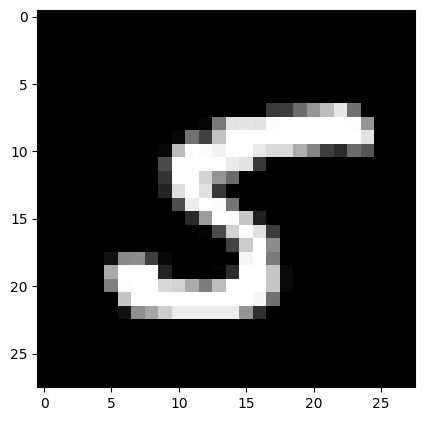

In [37]:
i, (example_data, exaple_target) = next(enumerate(test_loader))
print(example_data[0,0].shape)
plt.figure(figsize=(5,5), dpi=100)
plt.imsave("example.jpg", example_data[0,0], cmap='gray',  dpi=1000)
plt.imshow(example_data[0,0], cmap='gray')
plt.show()

In [38]:
test_loss_list

[[3361.841572265625, 262.5421578979492, 3099.299411621094],
 [3233.2925805664063, 295.67553344726565, 2937.6170556640627],
 [3150.440769042969, 328.88812957763673, 2821.5526416015623],
 [3130.582590332031, 324.5017645263672, 2806.080832519531],
 [3117.2114306640624, 320.72644500732423, 2796.484990234375],
 [3083.8723217773436, 319.59398651123047, 2764.2783349609376],
 [3076.780163574219, 327.8931872558594, 2748.886979980469],
 [3068.396884765625, 327.75062377929686, 2740.6462646484374],
 [3055.2123095703123, 323.94920043945314, 2731.263112792969],
 [3044.1924096679686, 335.62227813720705, 2708.570126953125],
 [3049.880954589844, 327.28973266601565, 2722.5912231445313],
 [3032.683857421875, 334.2295227050781, 2698.4543359375],
 [3031.64056640625, 337.22017639160157, 2694.420388183594],
 [3028.04189453125, 332.830221862793, 2695.2116552734374],
 [3033.3476953125, 341.1331149291992, 2692.2145703125],
 [3043.021982421875, 362.98299530029294, 2680.038986816406],
 [3012.620847167969, 332.612

dataloader created
model created


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Gradients
conv1.weight tensor([[ 0.0004,  0.0039,  0.0060, -0.0130, -0.0116],
        [ 0.0062,  0.0134,  0.0099, -0.0045, -0.0103],
        [ 0.0112,  0.0047, -0.0008, -0.0040, -0.0109],
        [ 0.0133,  0.0011, -0.0100, -0.0134, -0.0147],
        [-0.0005, -0.0077, -0.0129, -0.0172, -0.0101]], device='cuda:0') 
conv1.bias tensor(-0.0051, device='cuda:0') 
conv2.weight tensor([[-0.0031, -0.0014,  0.0015,  0.0136,  0.0047],
        [-0.0019,  0.0051, -0.0019,  0.0066,  0.0084],
        [ 0.0069,  0.0038, -0.0063,  0.0099,  0.0116],
        [ 0.0145, -0.0087, -0.0065,  0.0098,  0.0062],
        [ 0.0085, -0.0102, -0.0069,  0.0021,  0.0023]], device='cuda:0') 
conv2.bias tensor(-0.0075, device='cuda:0') 
linear1.weight tensor(0.0001, device='cuda:0') 
linear1.bias tensor(0.0166, device='cuda:0') 
mu.weight tensor(-0.0030, device='cuda:0') 
mu.bias tensor(21.8296, device='cuda:0') 
logvar.weight tensor(-0.0010, device='cuda:0') 
logvar.bias tensor(0.2150, device='cuda:0') 
linear2.weigh

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Gradients
conv1.weight tensor([[-0.5023, -0.0910,  1.5363,  2.3969,  0.7463],
        [-0.0803,  0.3666,  2.3300,  2.7863,  1.0542],
        [-0.4898,  0.1774,  1.8998,  2.8604,  1.1913],
        [ 0.3462,  1.8064,  3.6510,  4.4581,  3.1883],
        [ 1.0481,  1.9815,  2.8265,  3.0612,  4.4248]], device='cuda:0') 
conv1.bias tensor(14.6399, device='cuda:0') 
conv2.weight tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0') 
conv2.bias tensor(0., device='cuda:0') 
linear1.weight tensor(0., device='cuda:0') 
linear1.bias tensor(-16.6116, device='cuda:0') 
mu.weight tensor(-43.8025, device='cuda:0') 
mu.bias tensor(-205.5257, device='cuda:0') 
logvar.weight tensor(-4.3099, device='cuda:0') 
logvar.bias tensor(-8.5030, device='cuda:0') 
linear2.weight tensor(-19.9319, device='cuda:0') 
linear2.bias tensor(-11.6097, device='cuda:0') 
linear3.weight tensor(0.4450, device='cuda:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


data Plotted
Epoch: 10/40 Train loss: 3104.8010986328127, Train KLD: 337.7931694539388, Train Reconstruction Loss:2767.0079252115884
Epoch: 10/40 Test loss: 2775.476916503906, Test KLD: 331.66318939208986, Test Reconstruction Loss:2775.476916503906
Gradients
conv1.weight tensor([[ 1.4654, -1.1428, -1.0220, -0.3435,  3.8047],
        [ 0.1575, -1.2823,  2.3723,  7.8814,  8.6875],
        [ 0.5691,  3.2816,  5.2946, 11.0537, 11.4146],
        [ 2.3155,  5.1211,  6.5140, 13.6707, 14.1046],
        [-1.7978,  5.0153,  5.4845, 11.6963, 11.9347]], device='cuda:0') 
conv1.bias tensor(-1.1877, device='cuda:0') 
conv2.weight tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0') 
conv2.bias tensor(0., device='cuda:0') 
linear1.weight tensor(0., device='cuda:0') 
linear1.bias tensor(0.8266, device='cuda:0') 
mu.weight tensor(13.7426, device='cuda:0') 
mu.bias tensor(-24.8352, device='

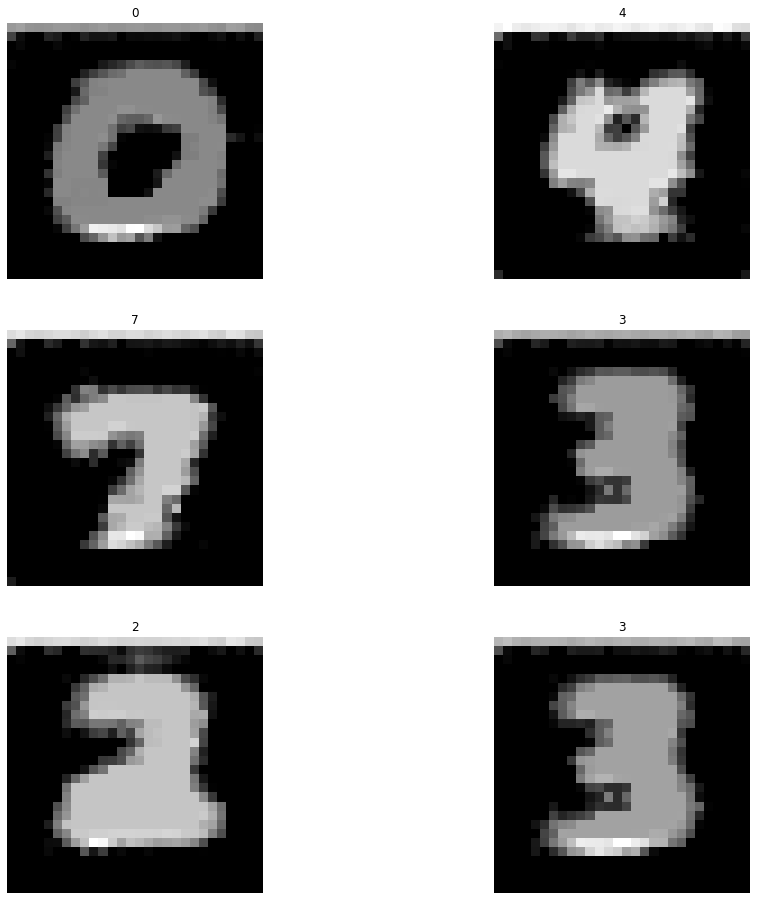

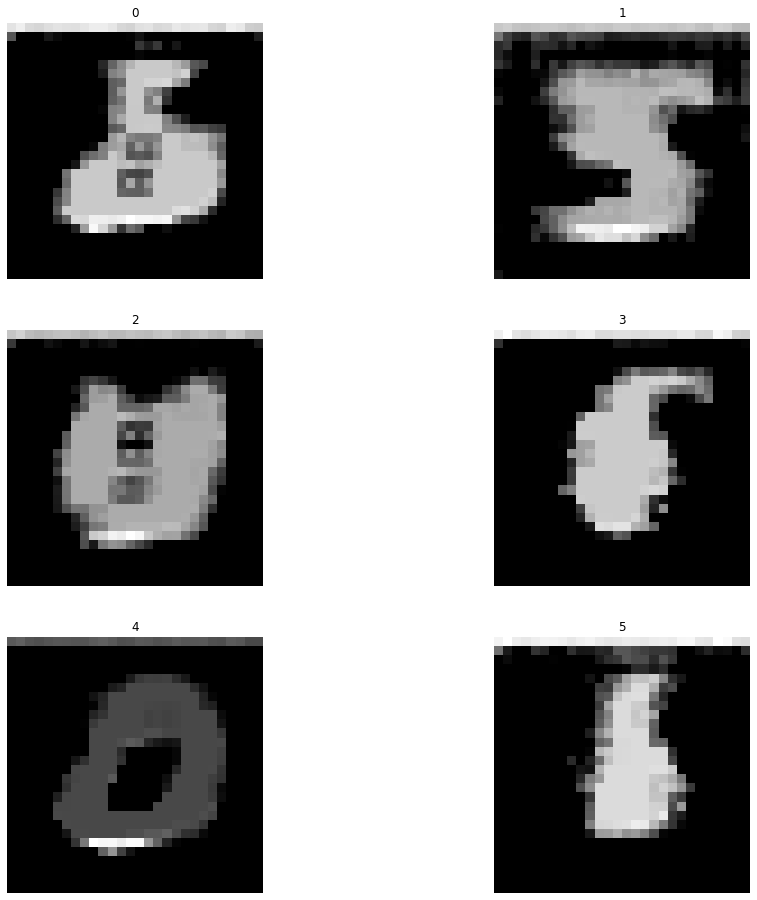

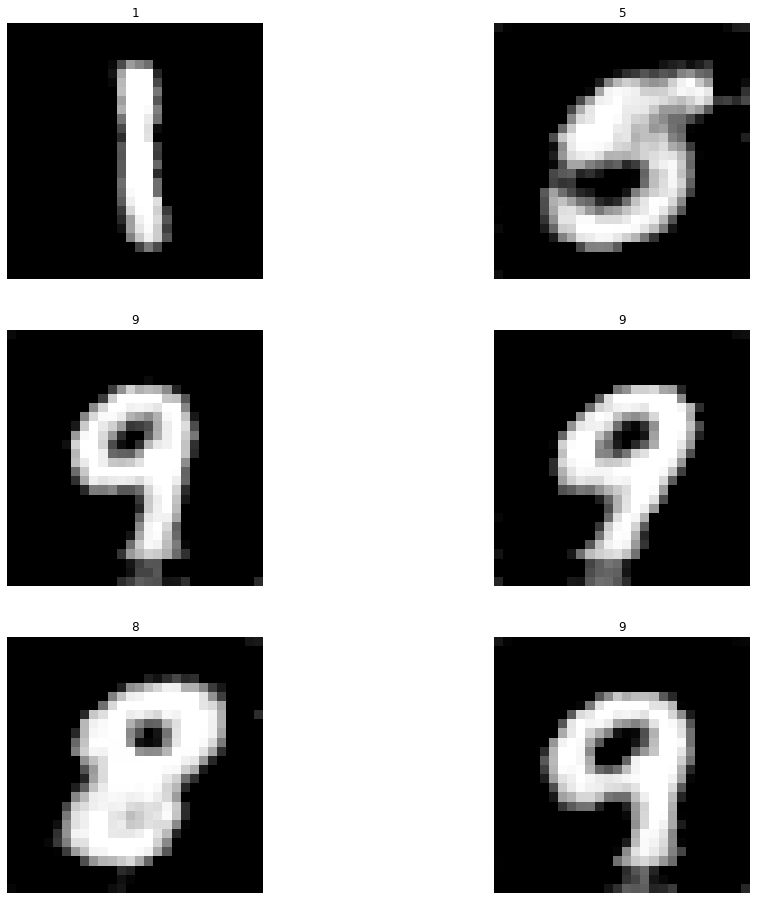

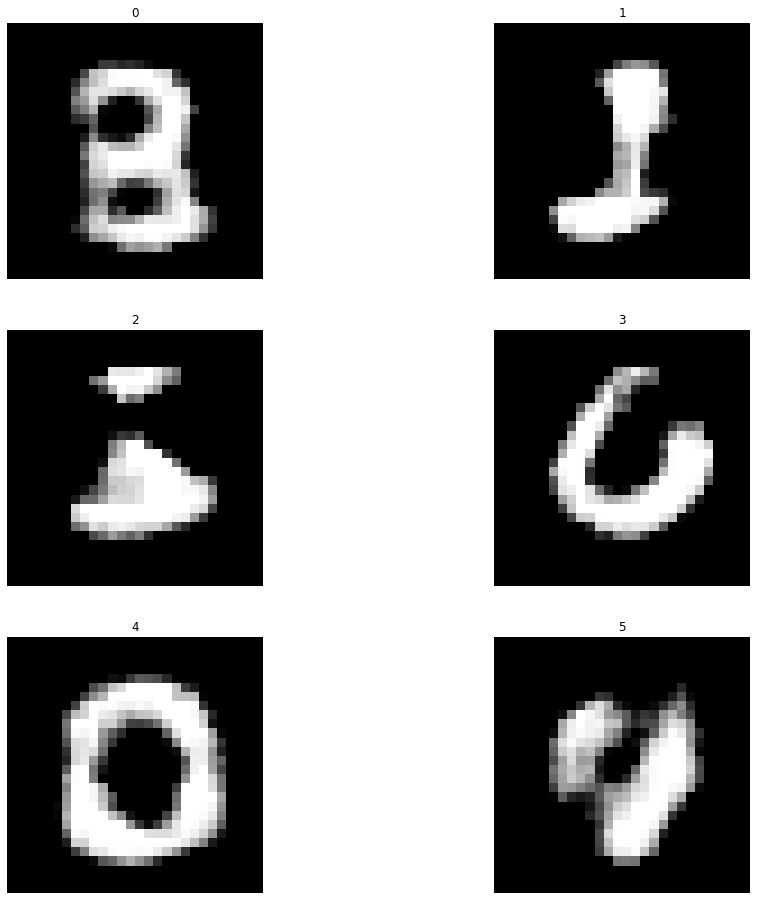

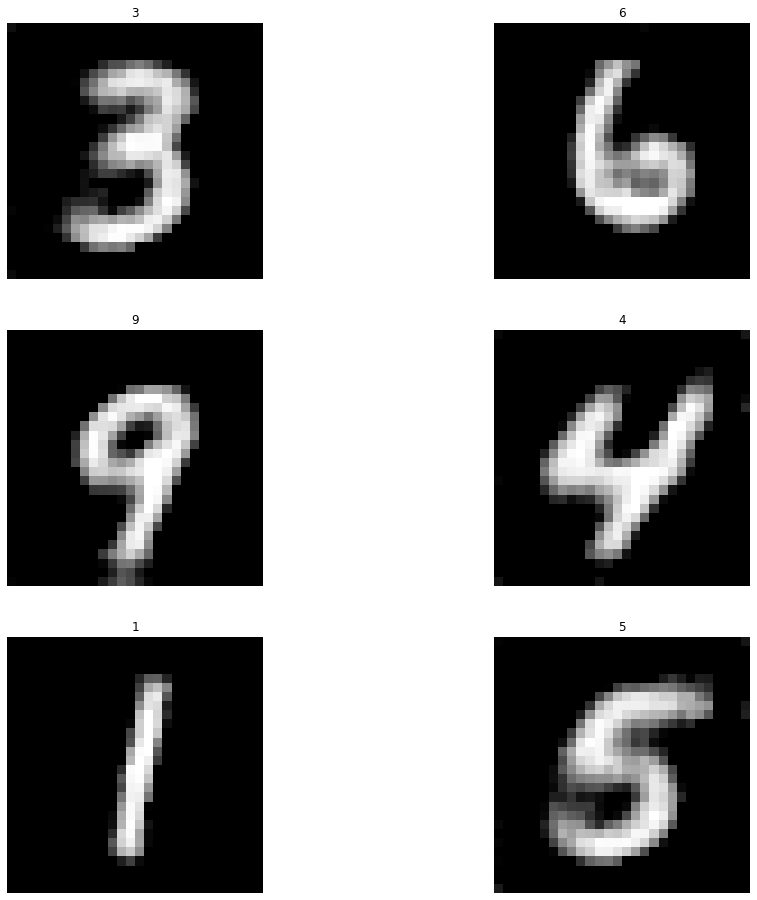

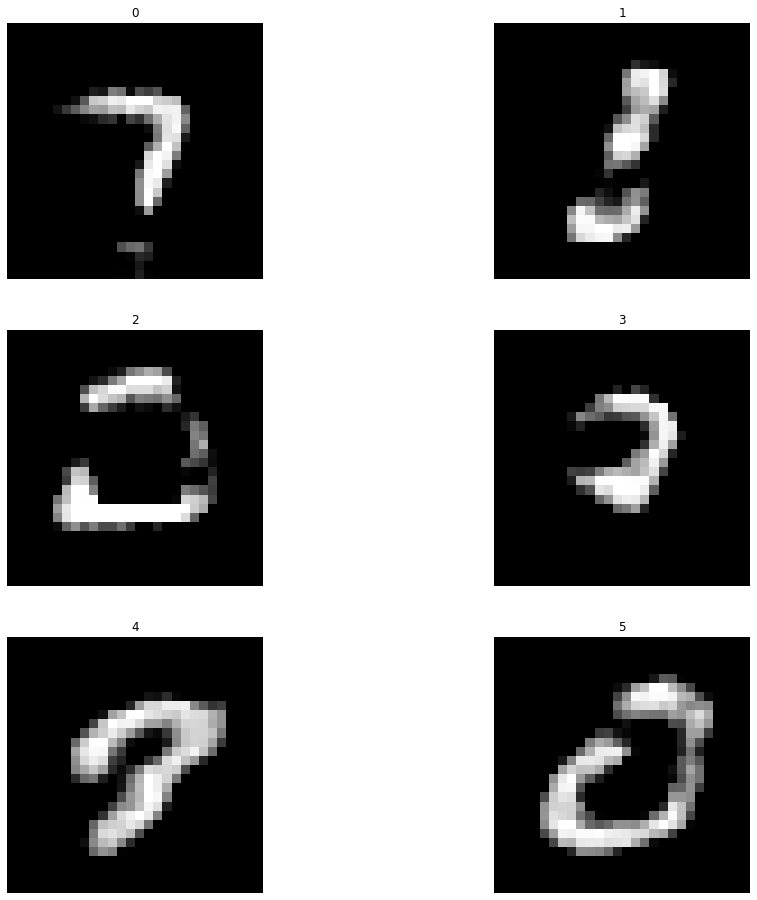

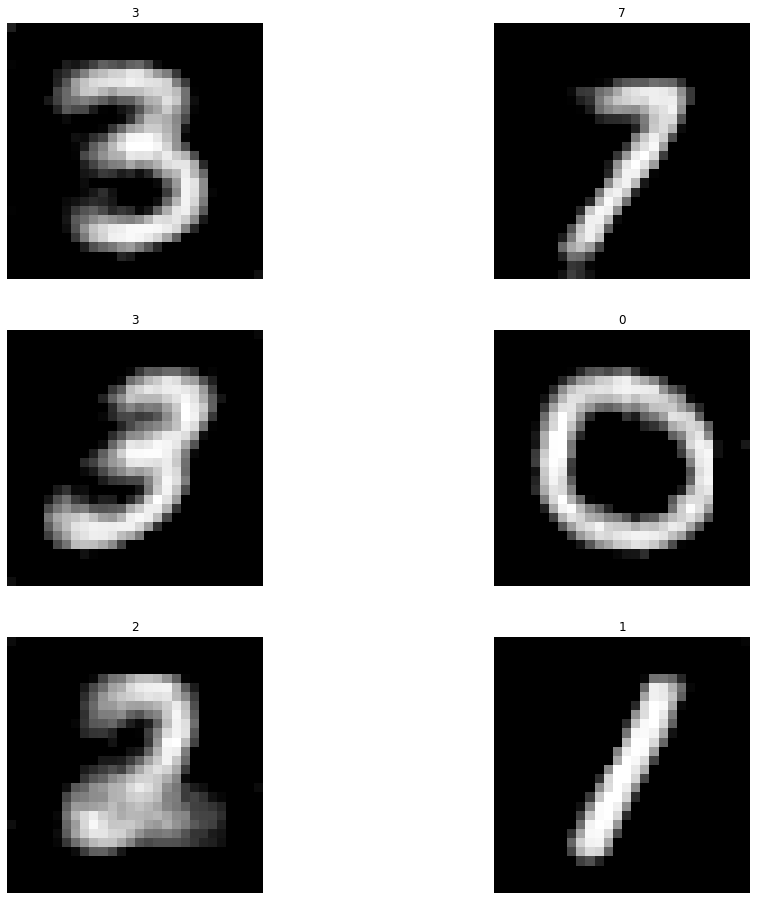

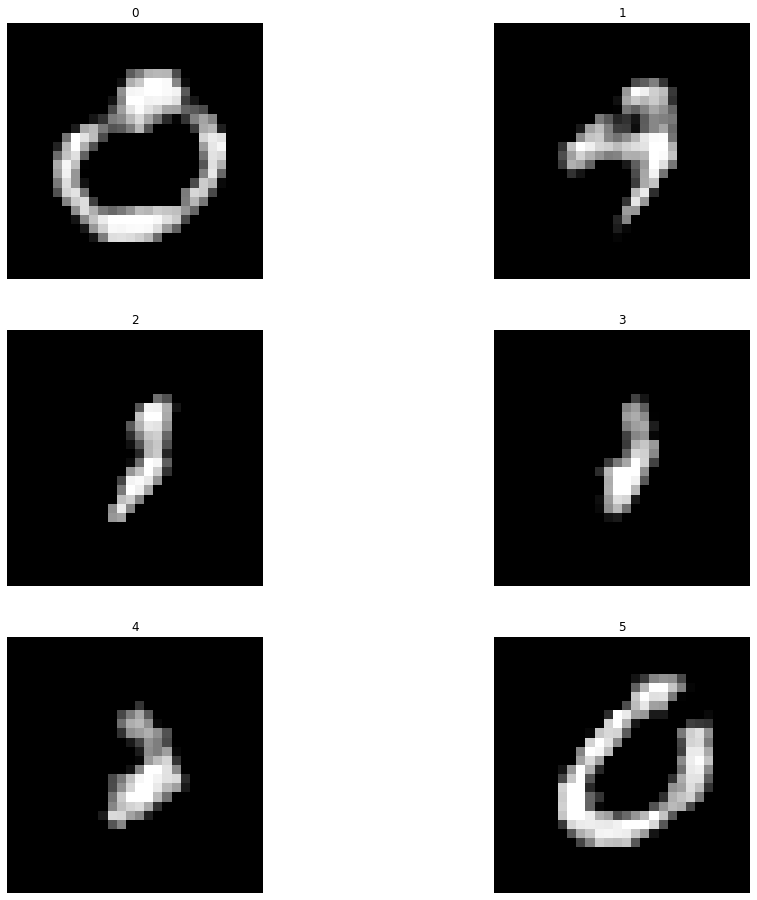

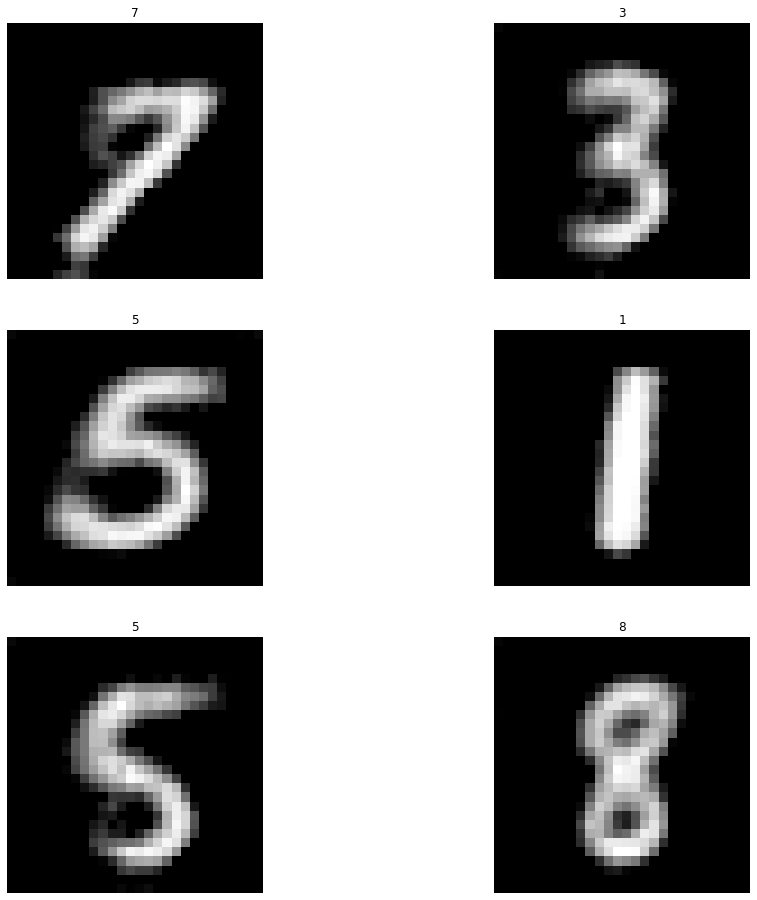

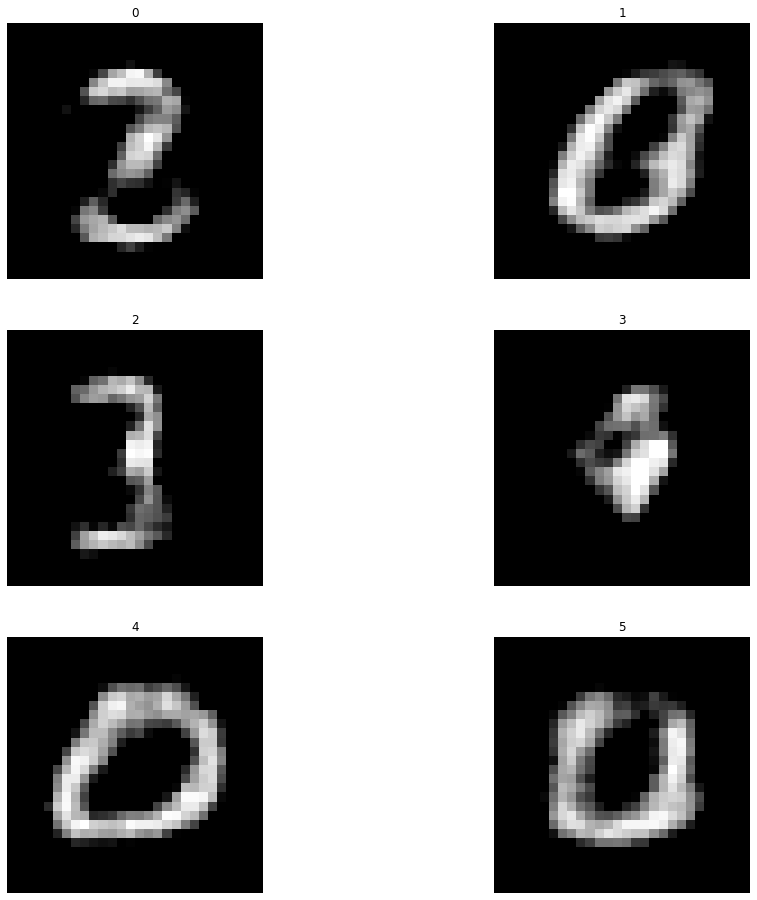

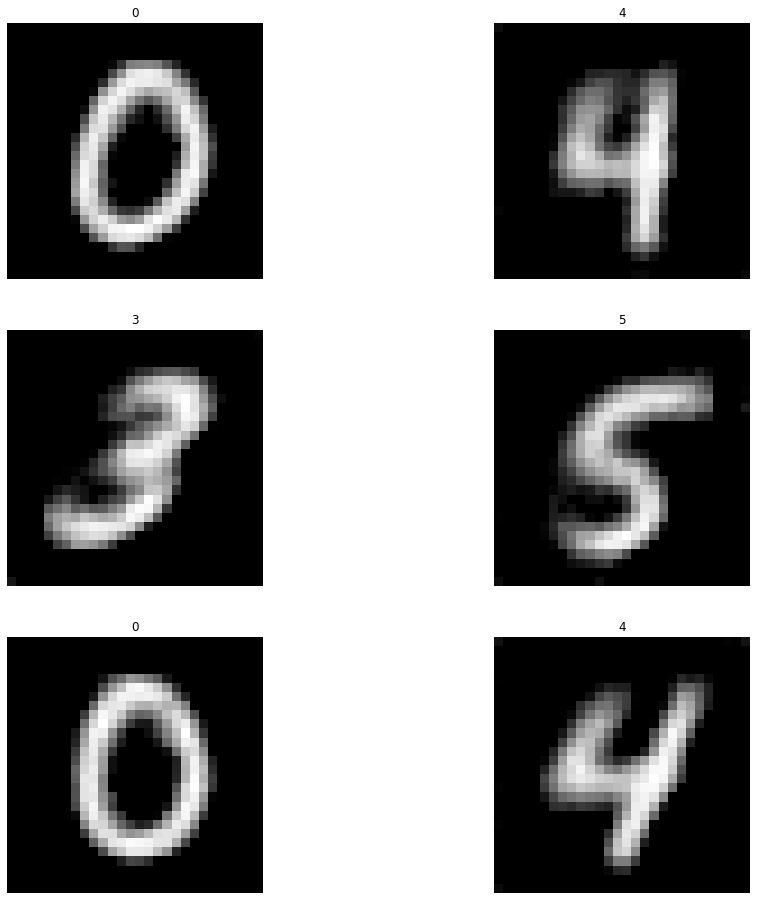

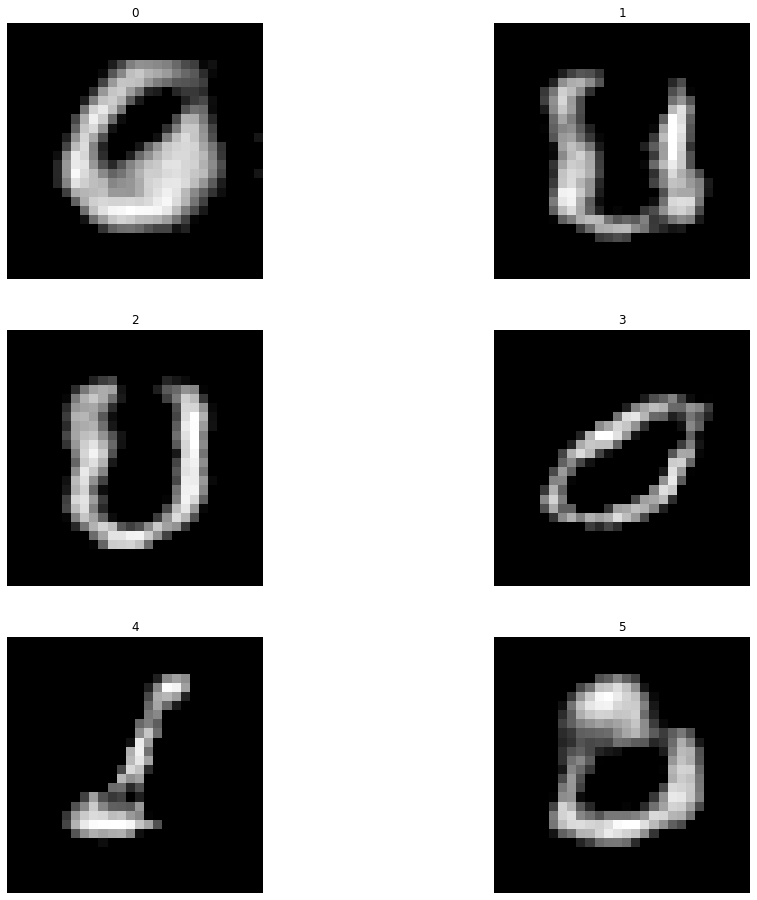

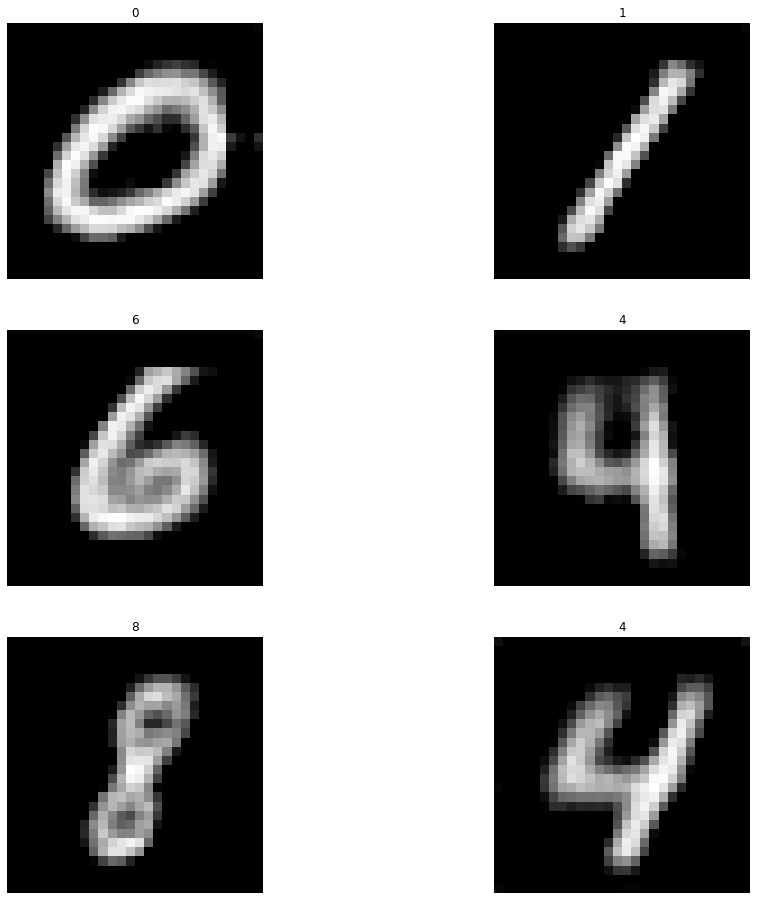

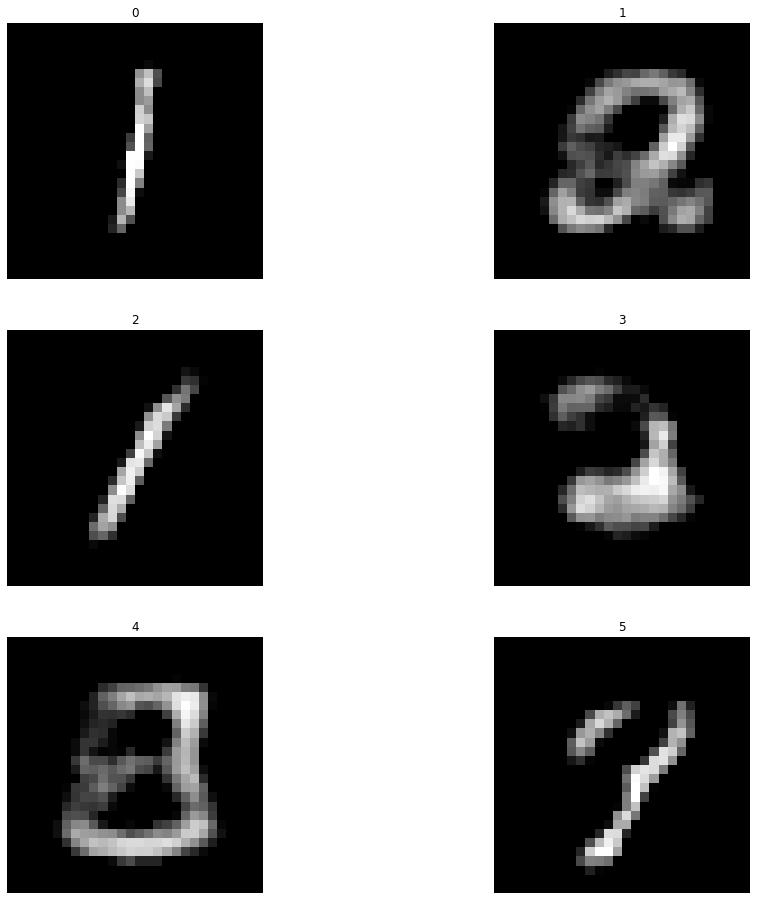

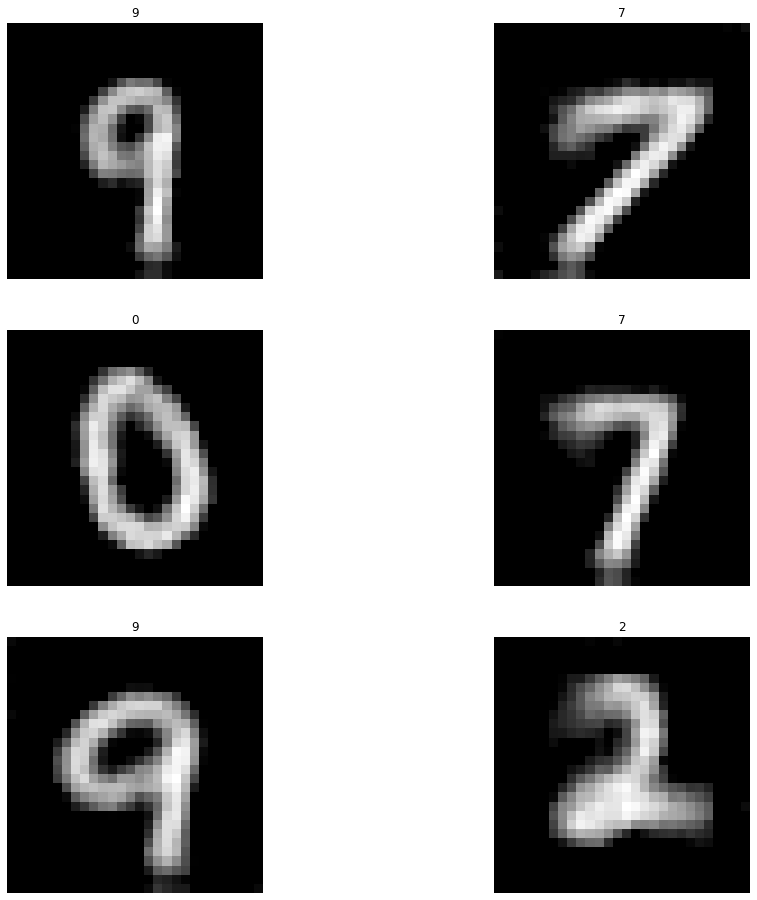

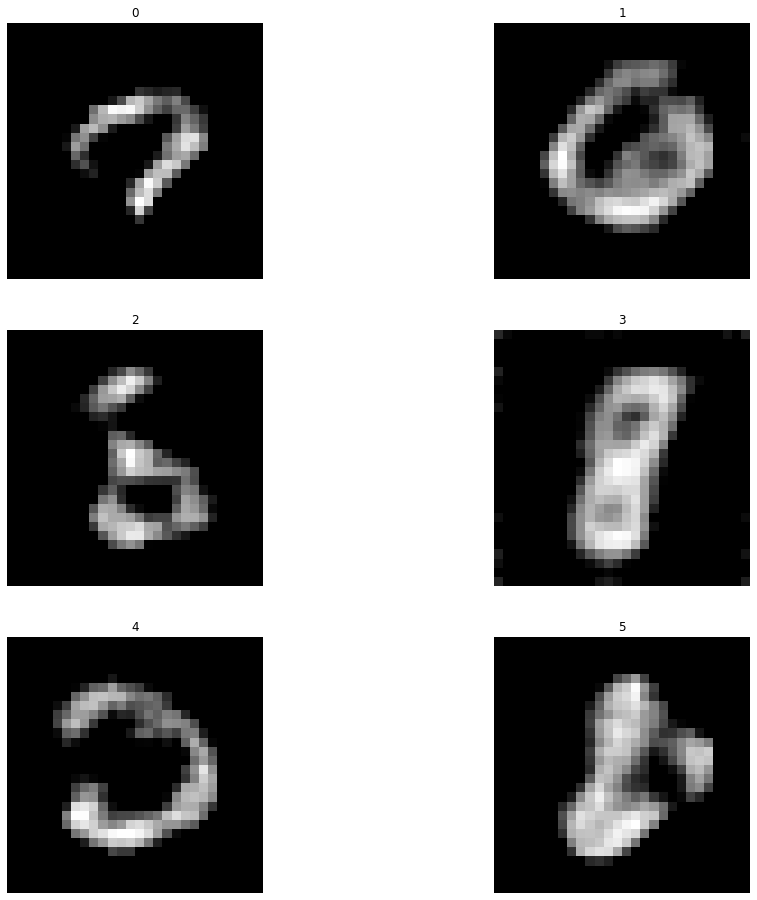

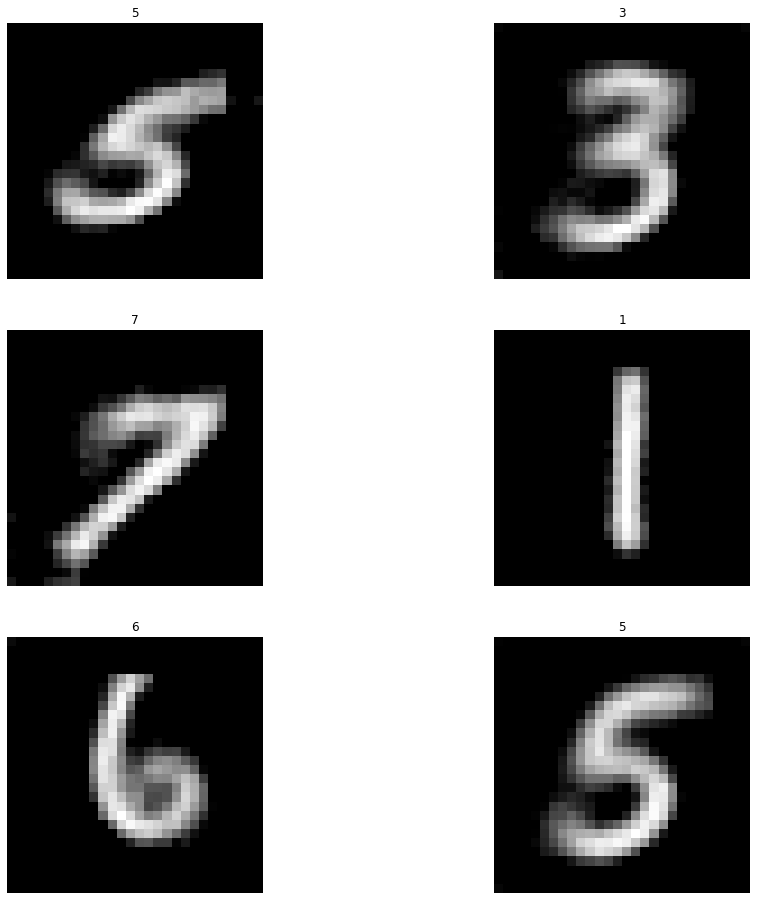

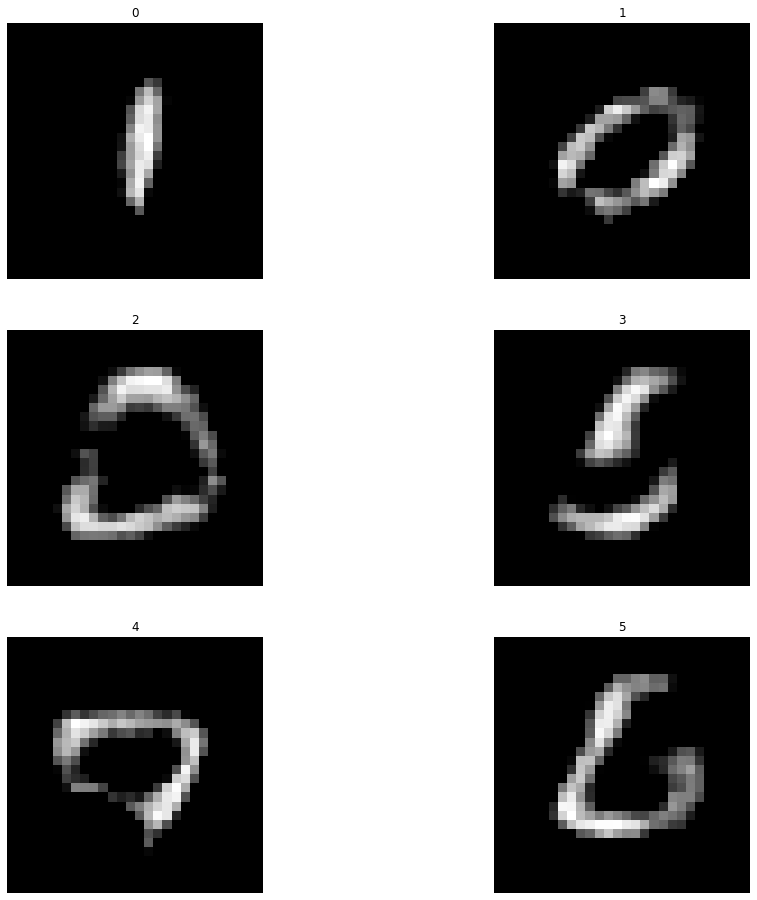

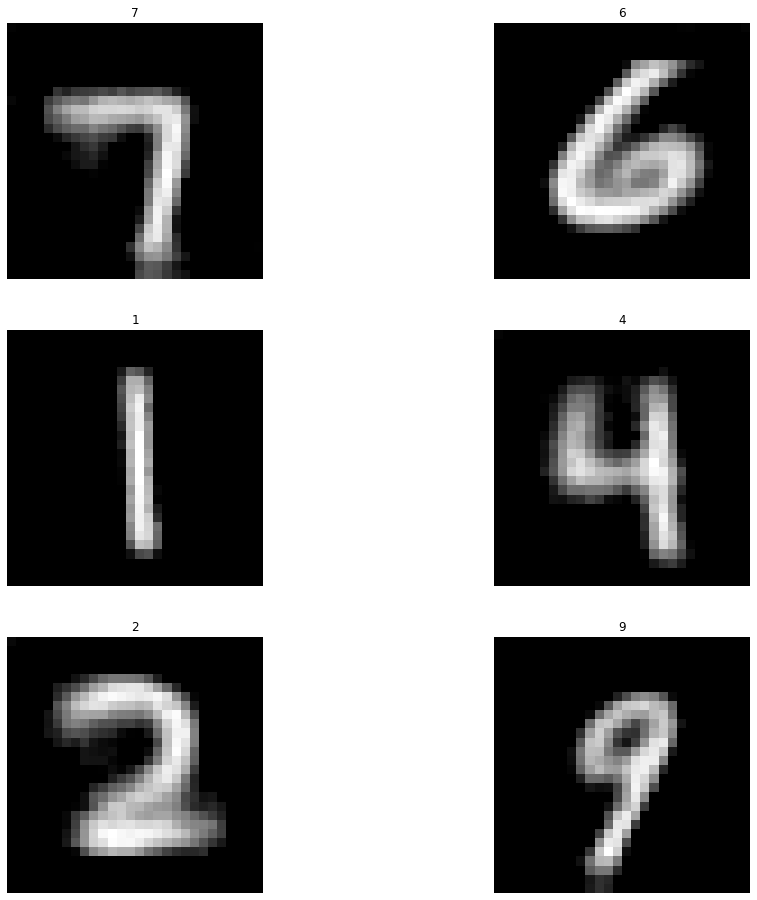

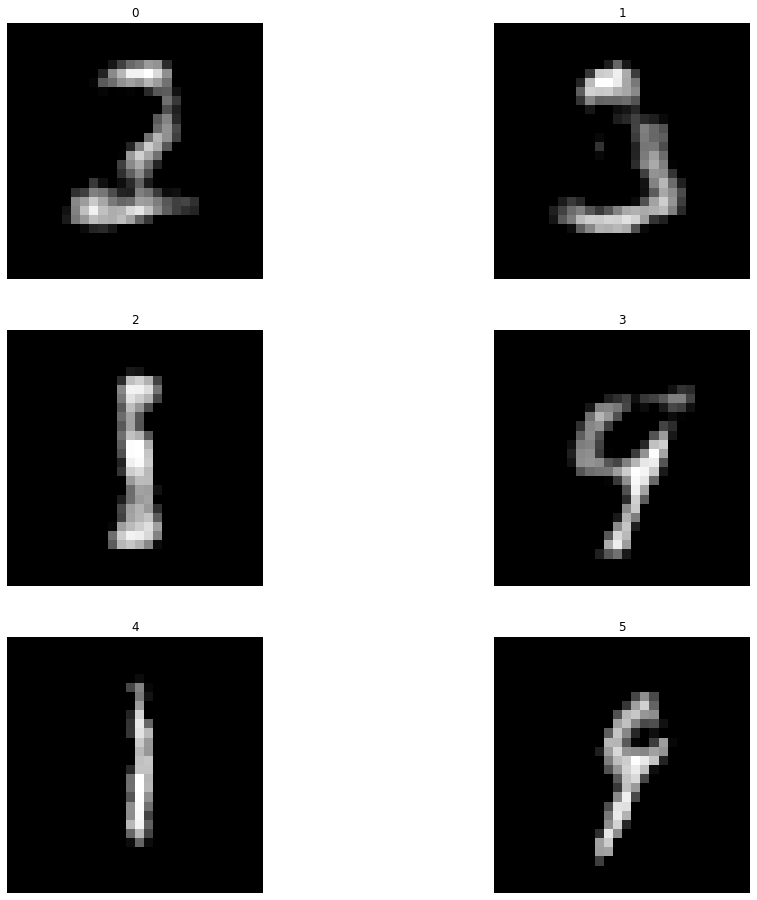

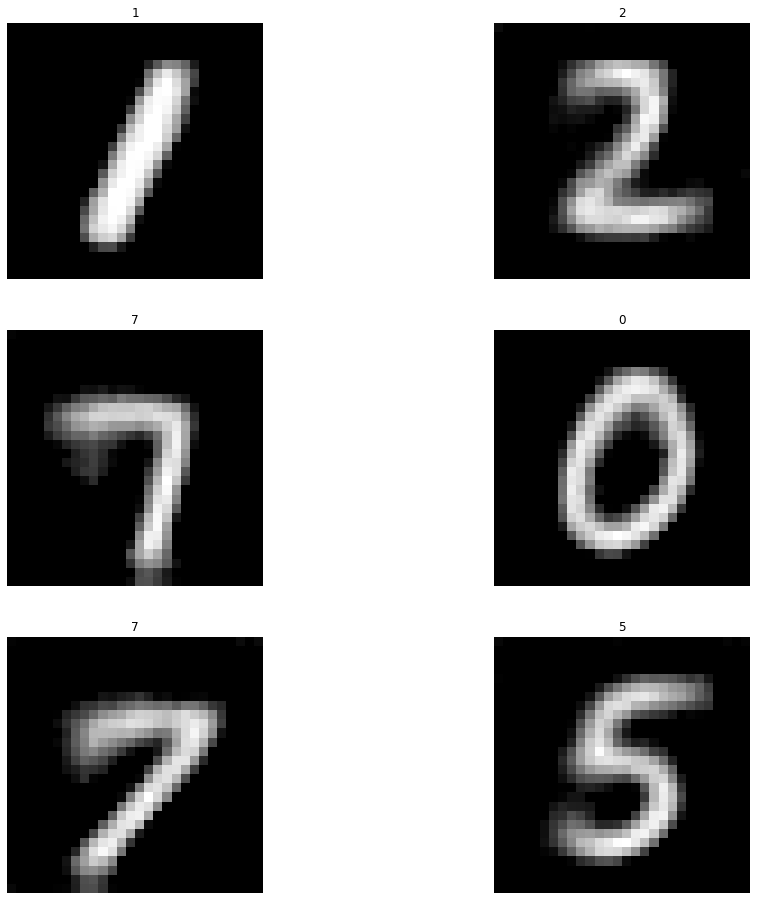

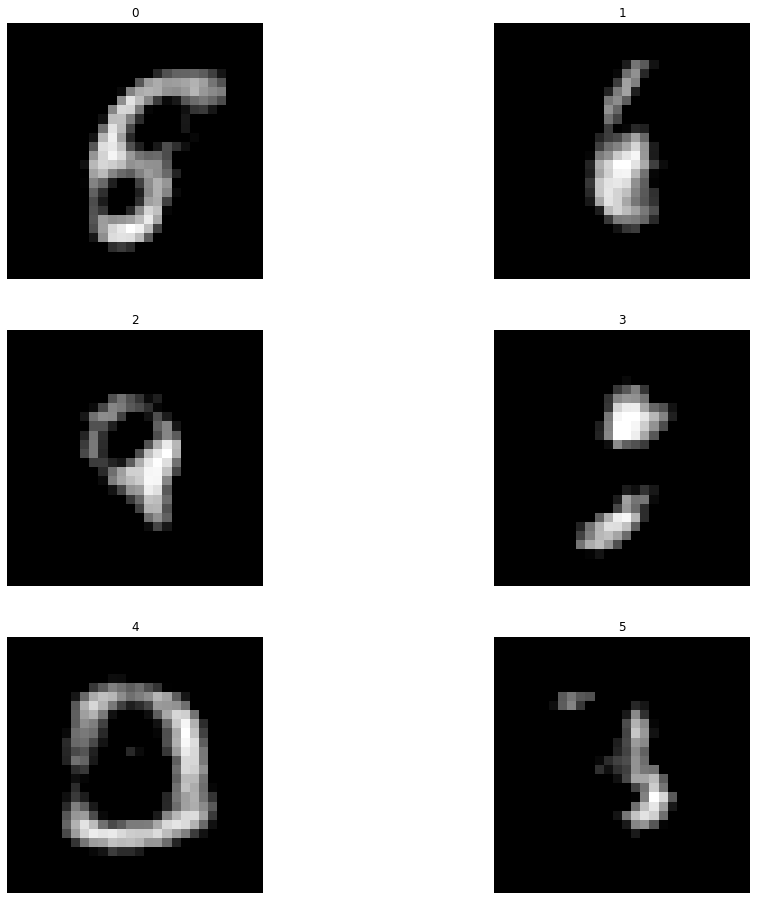

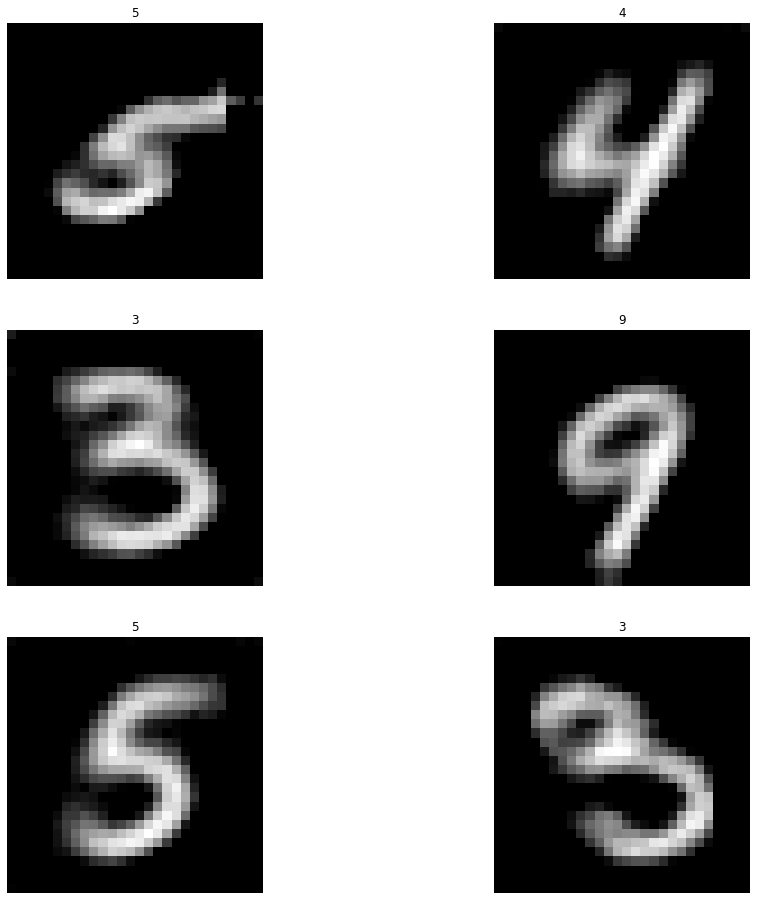

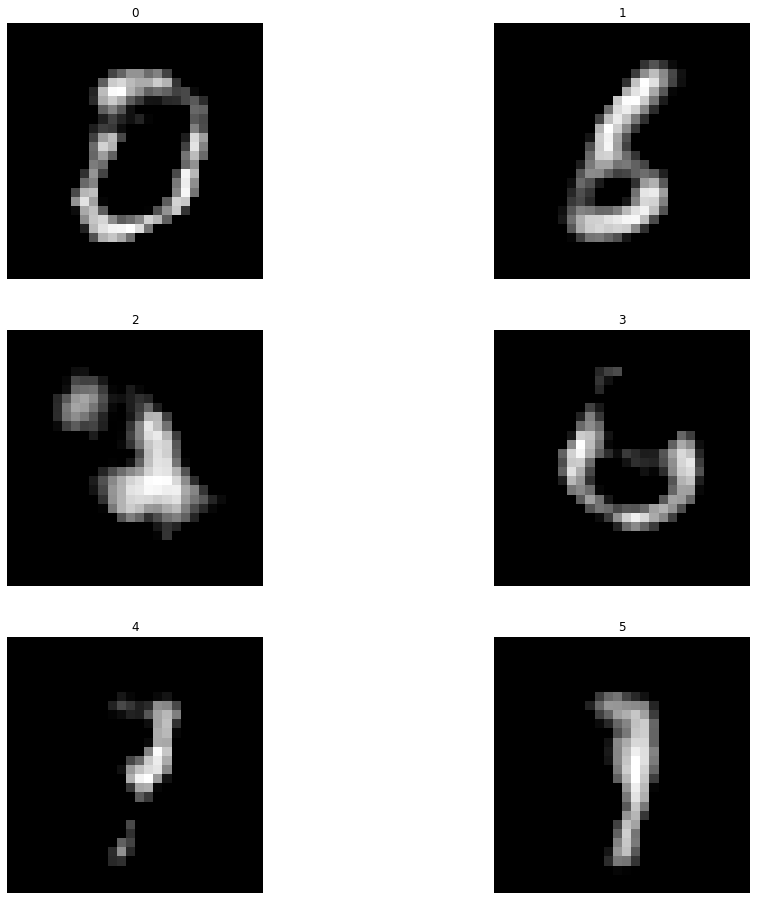

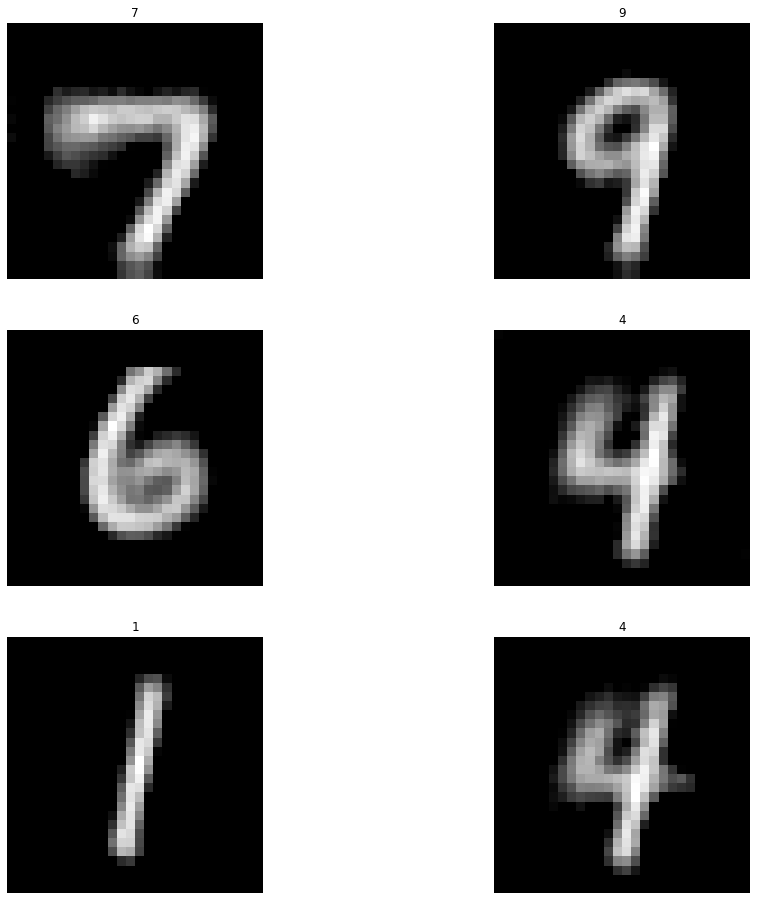

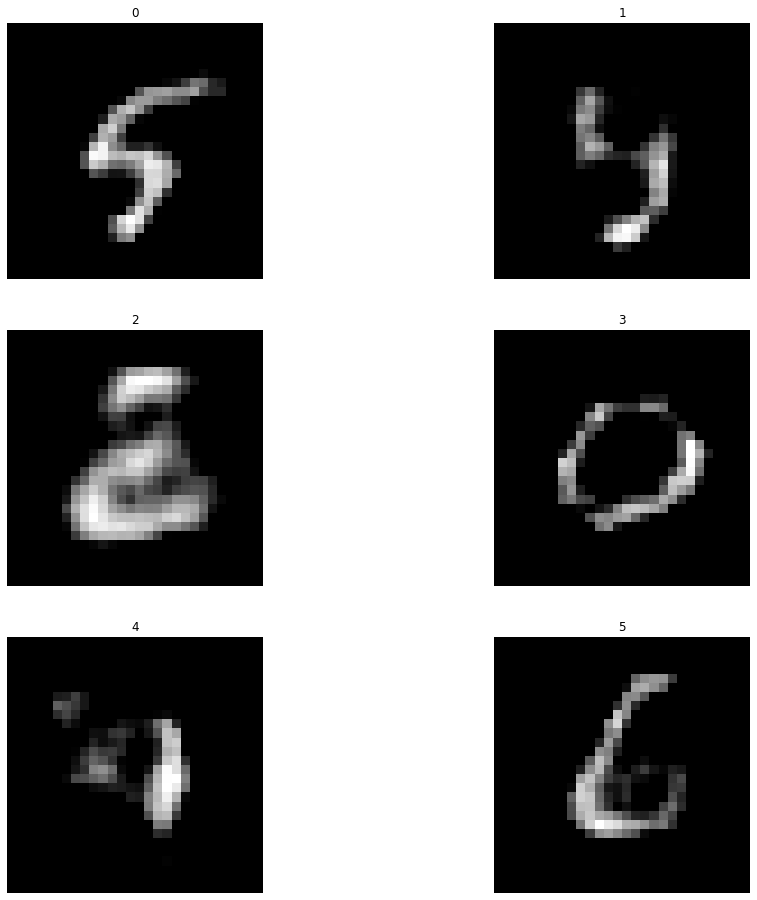

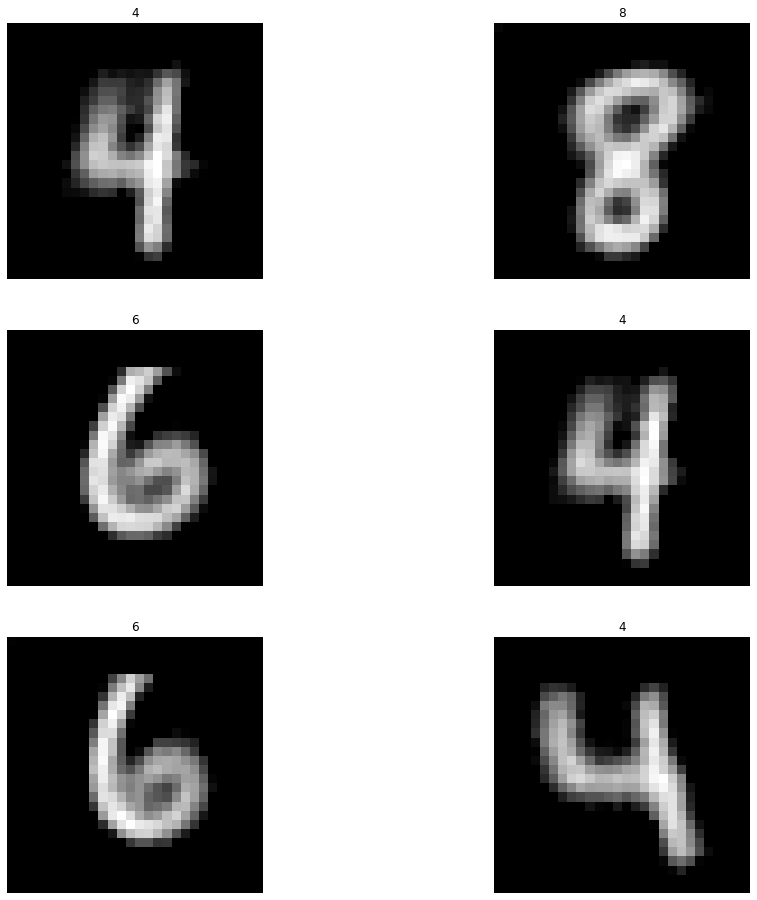

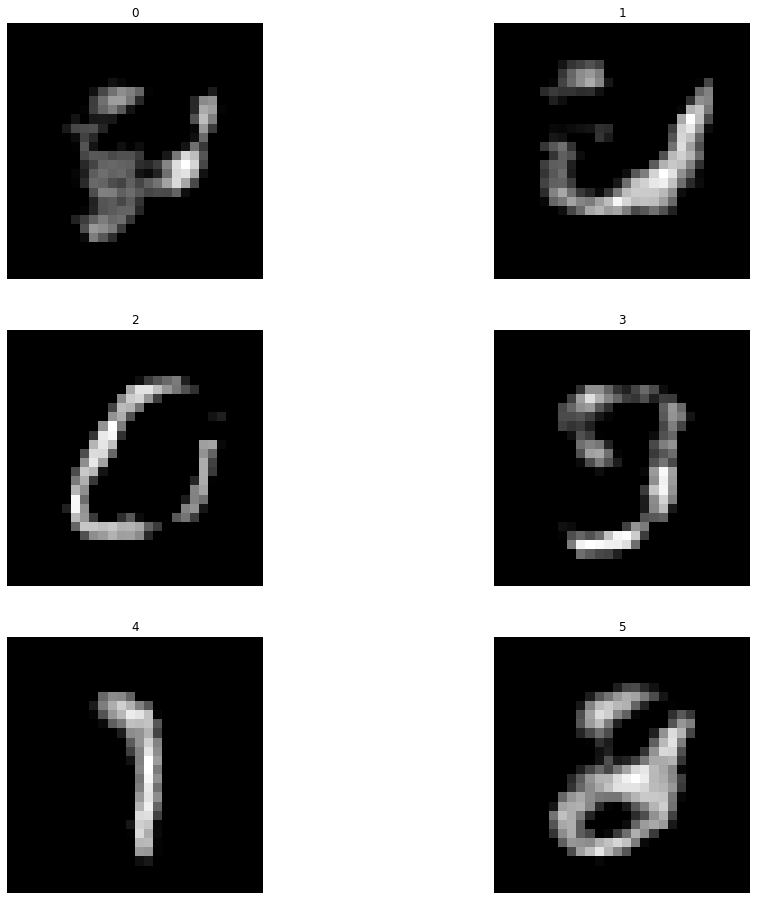

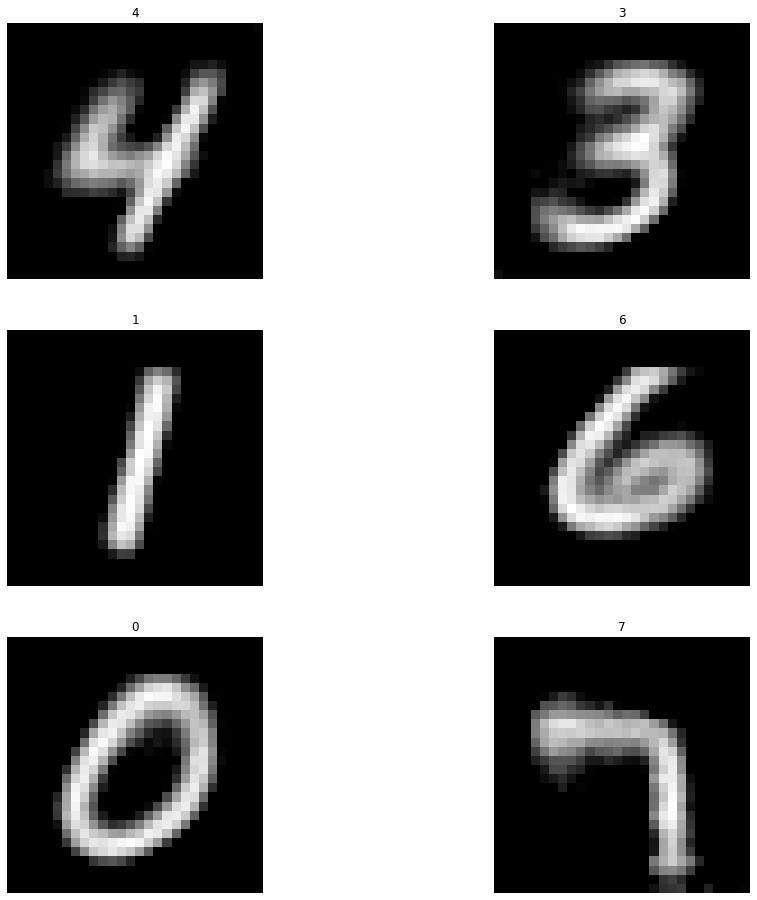

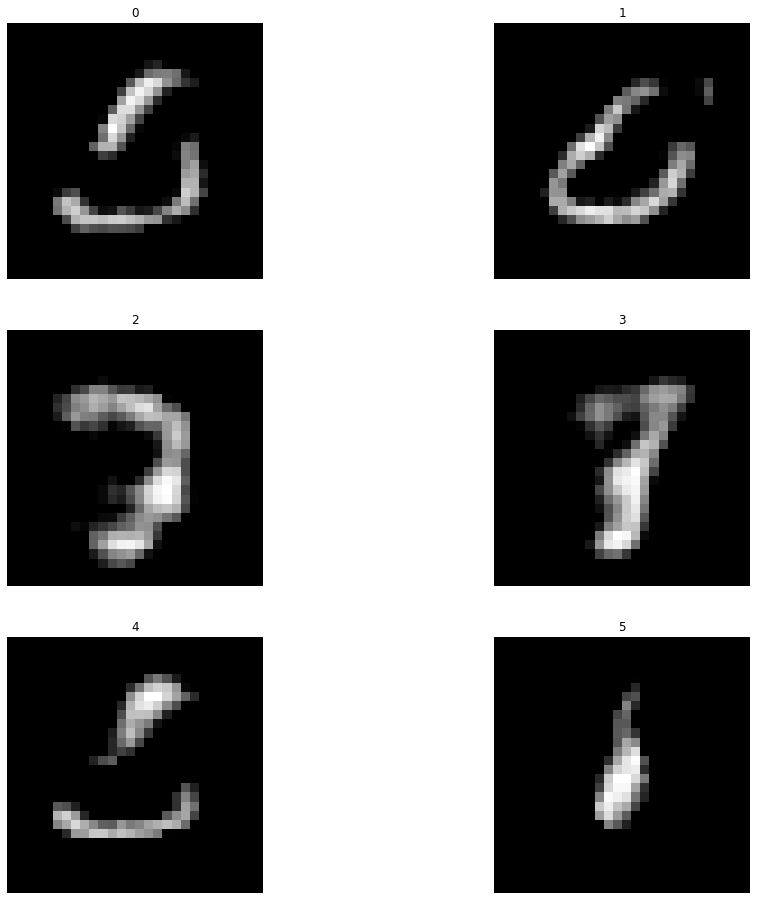

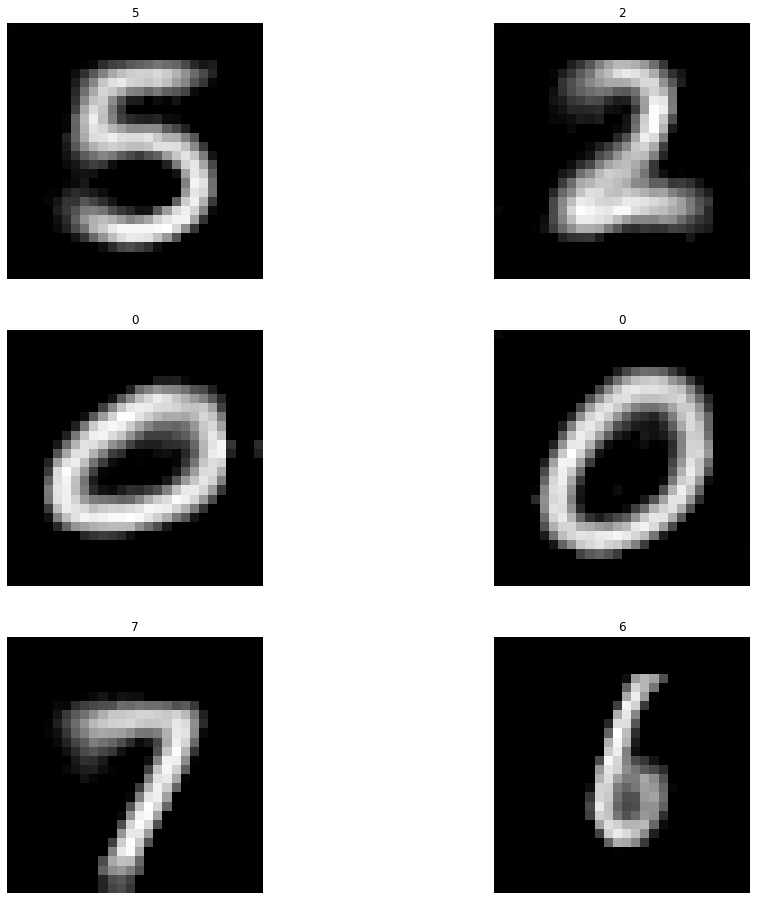

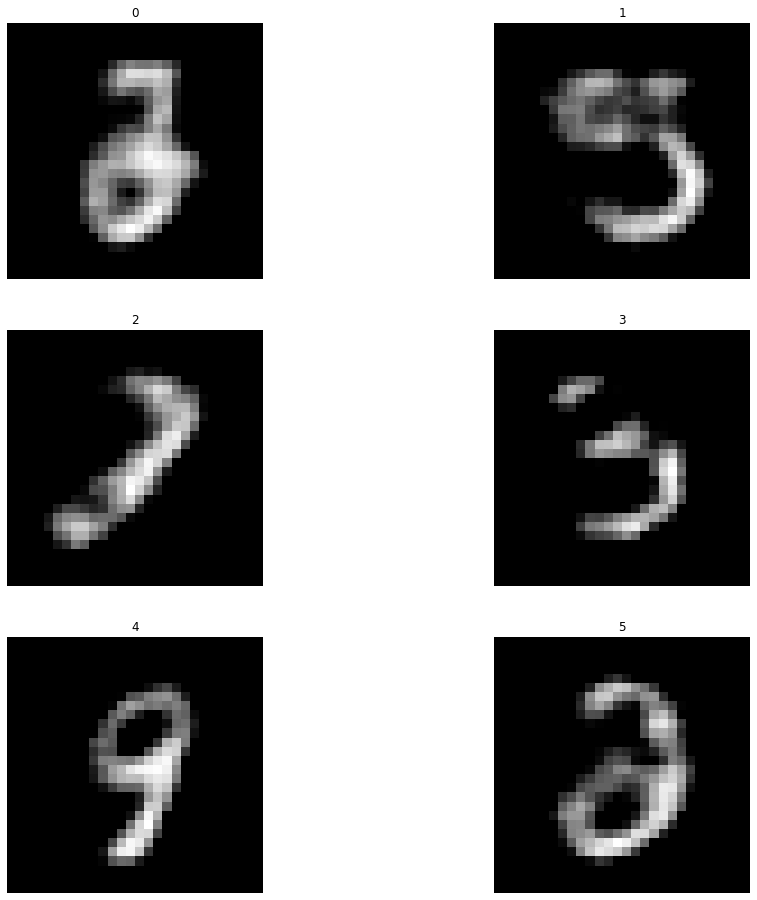

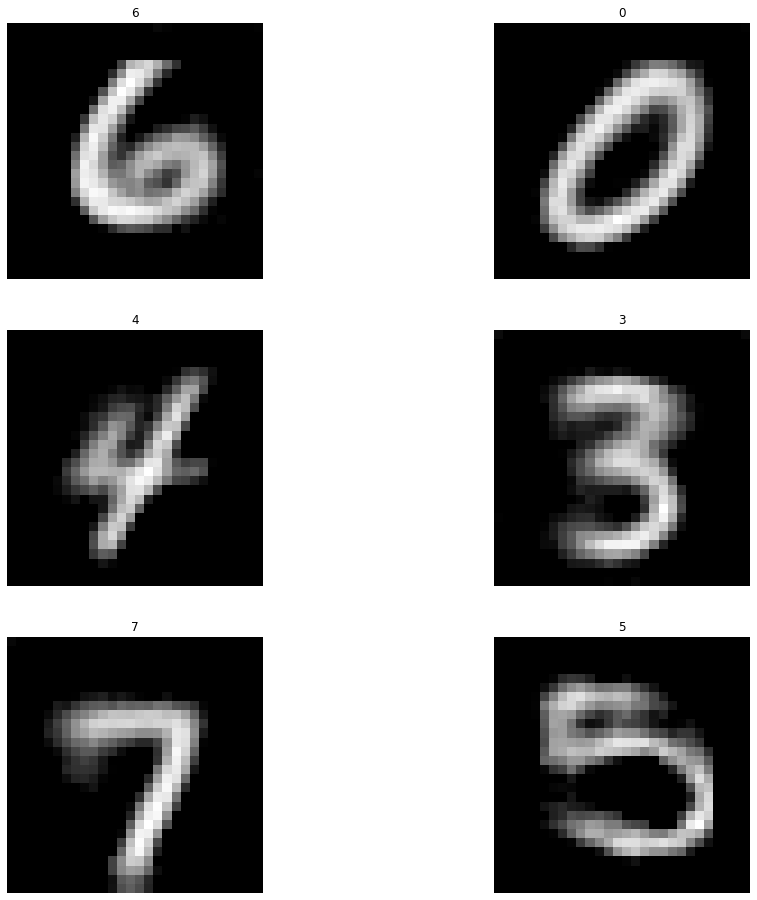

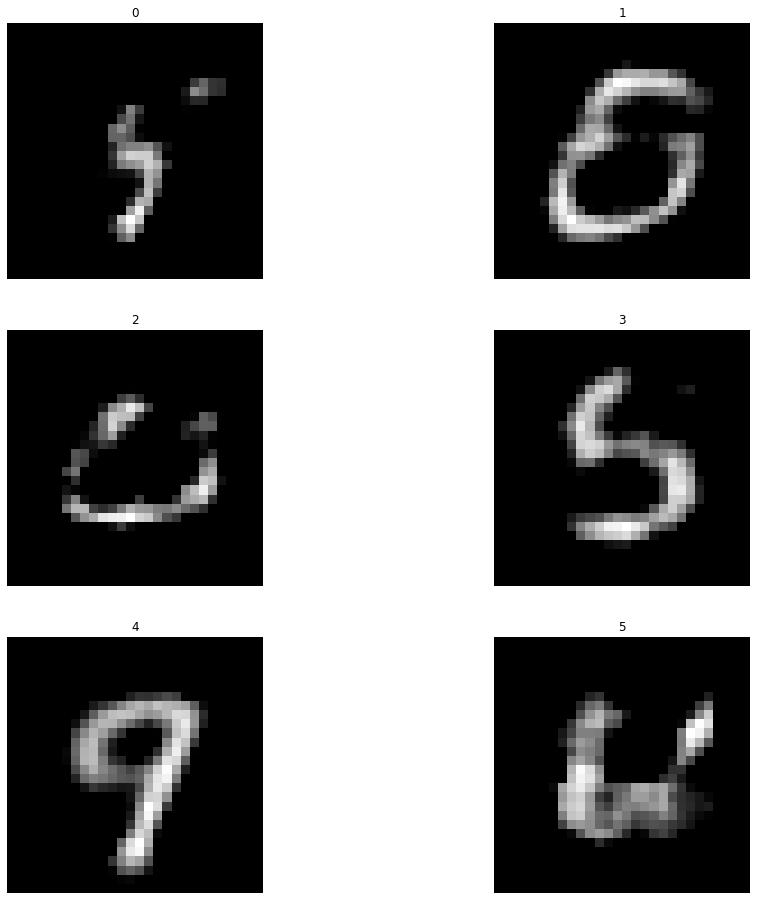

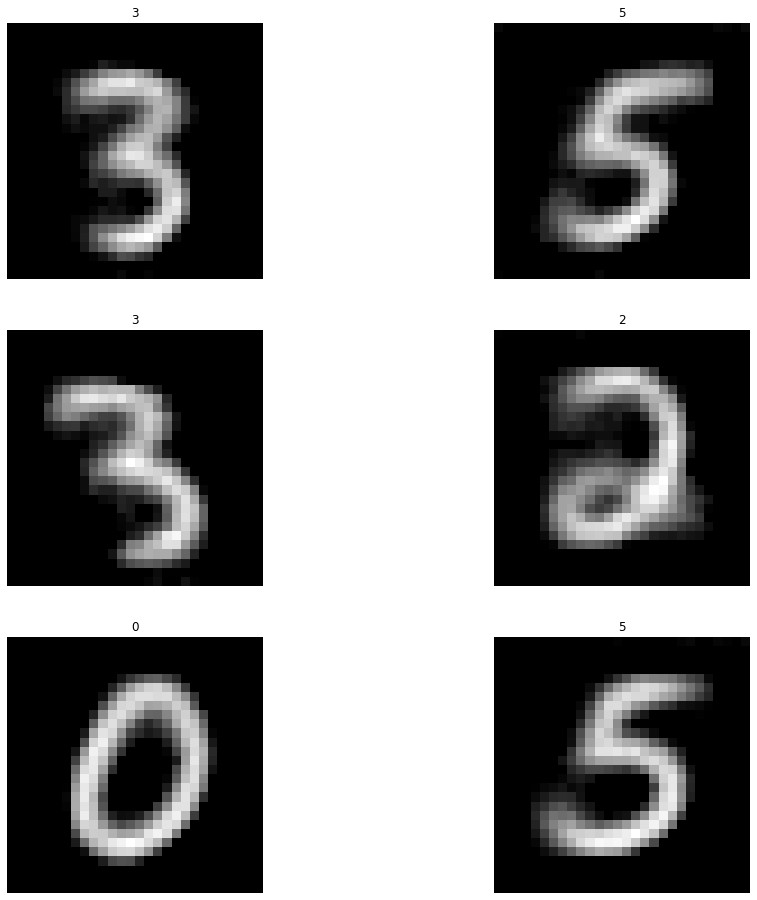

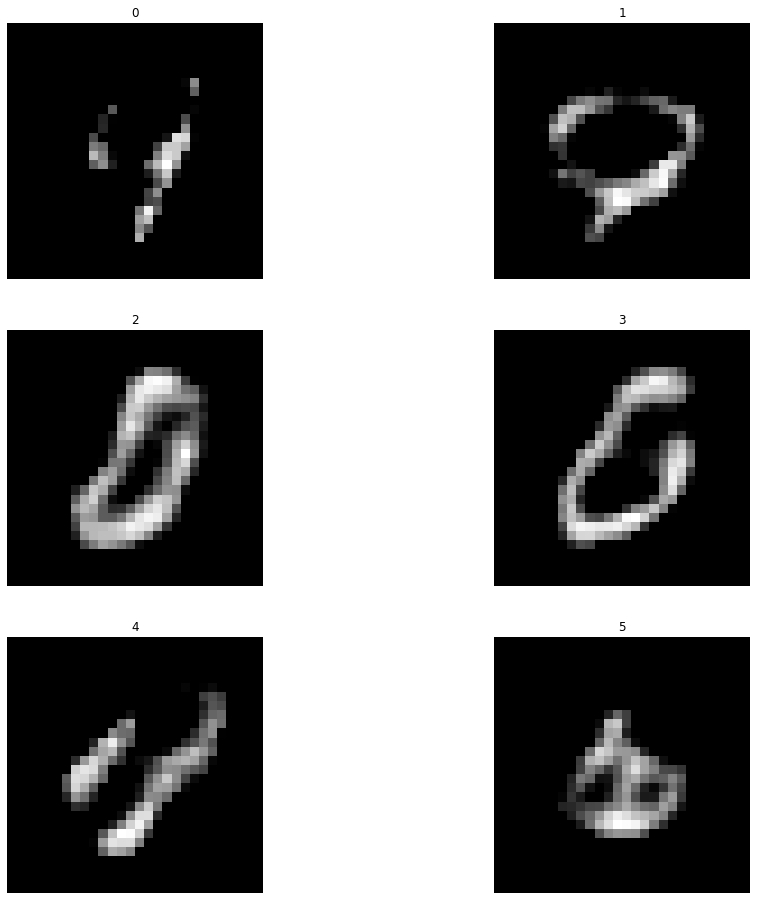

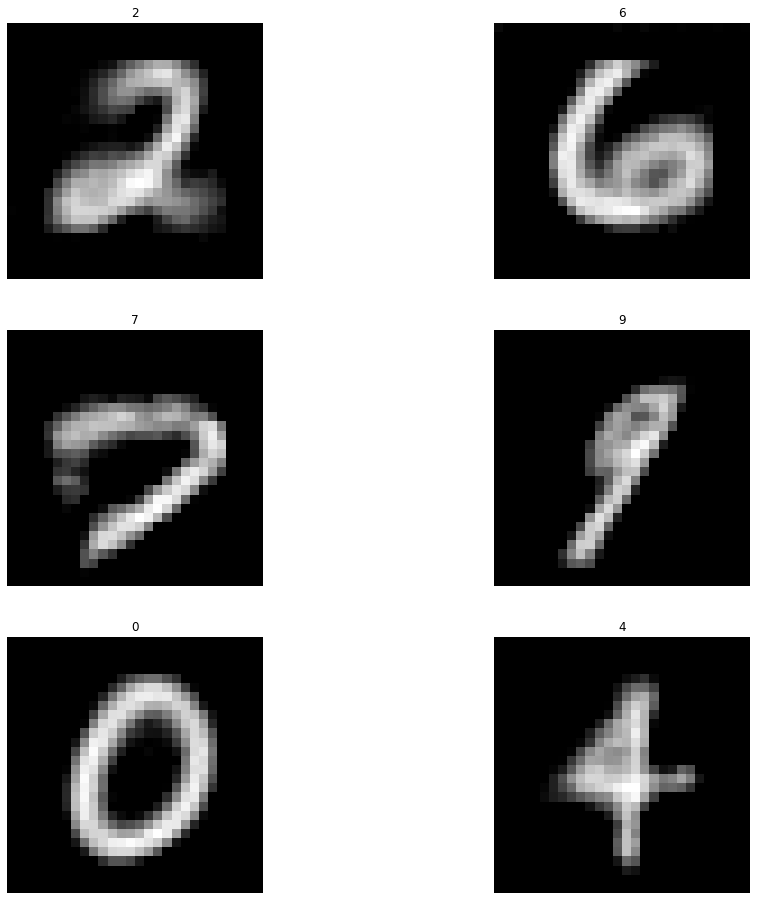

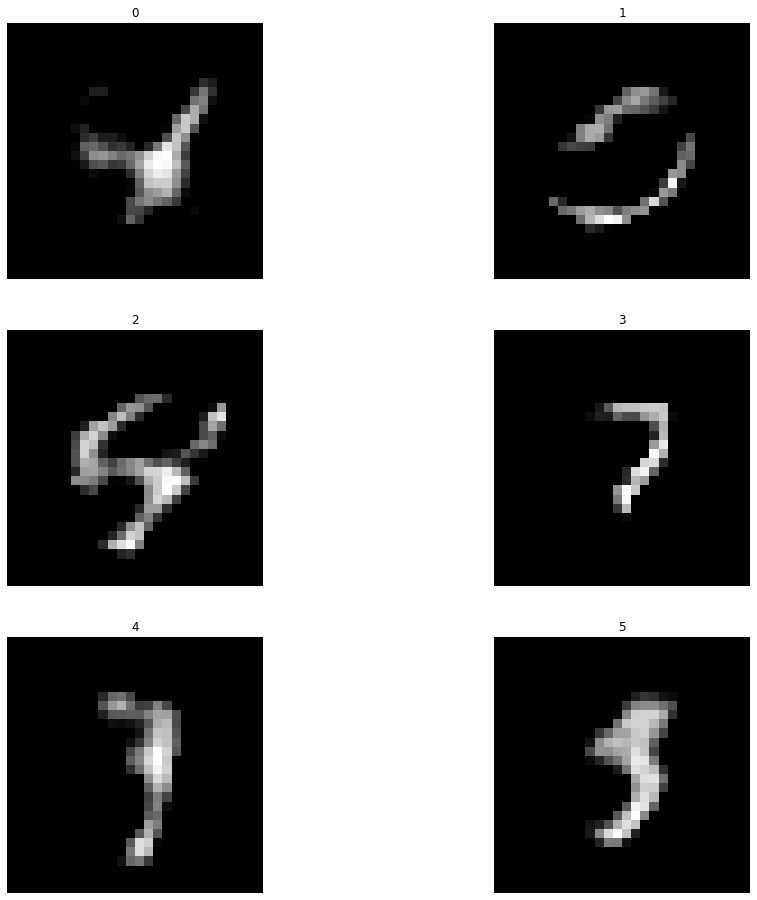

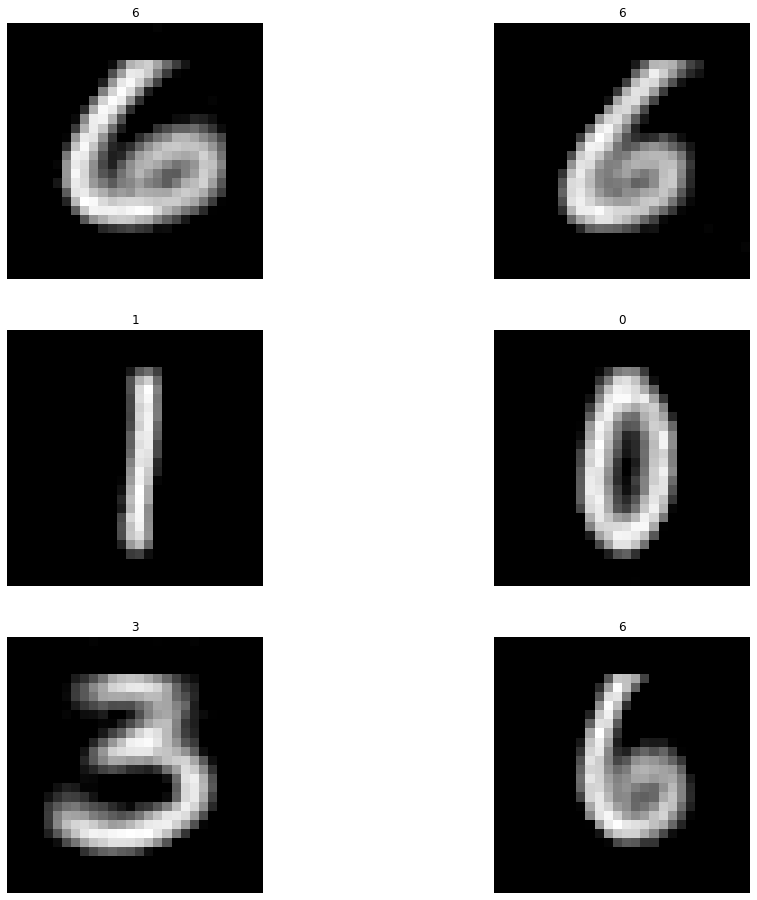

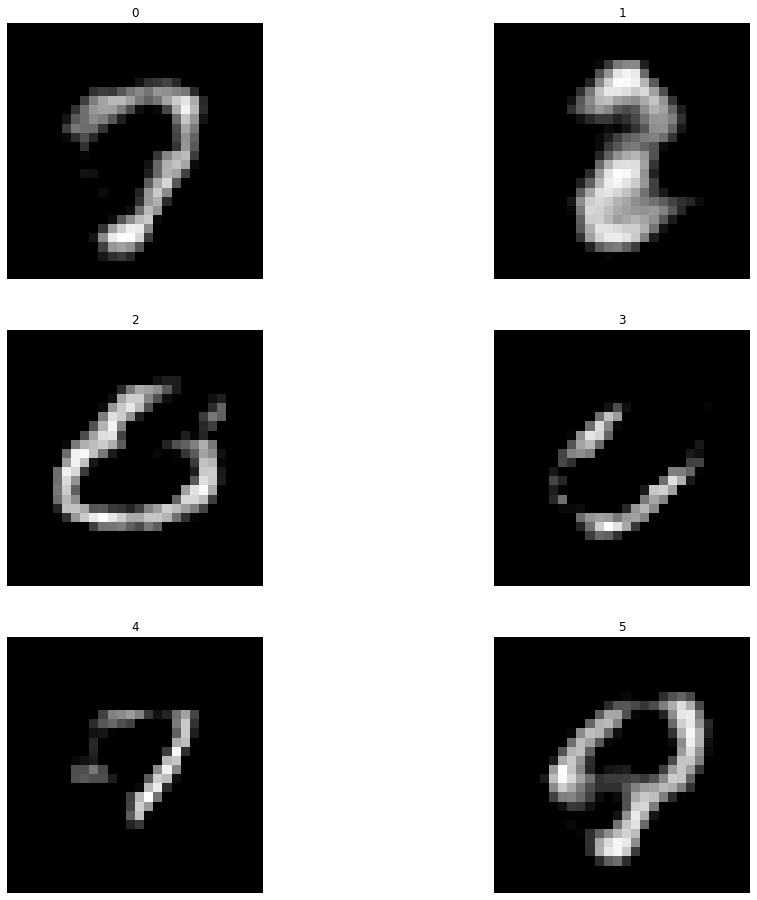

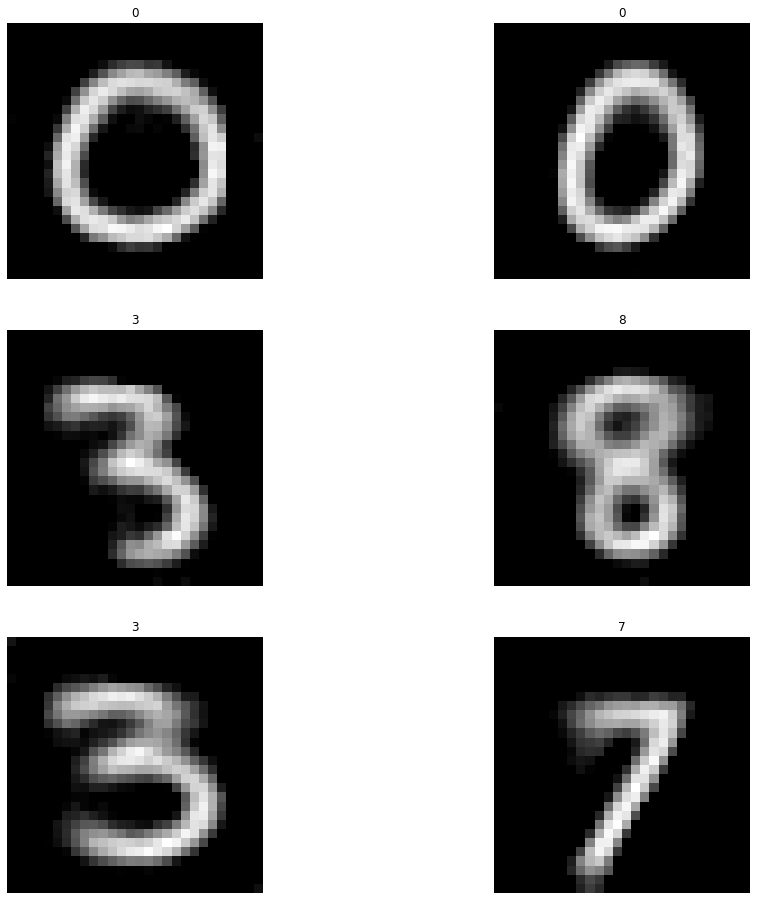

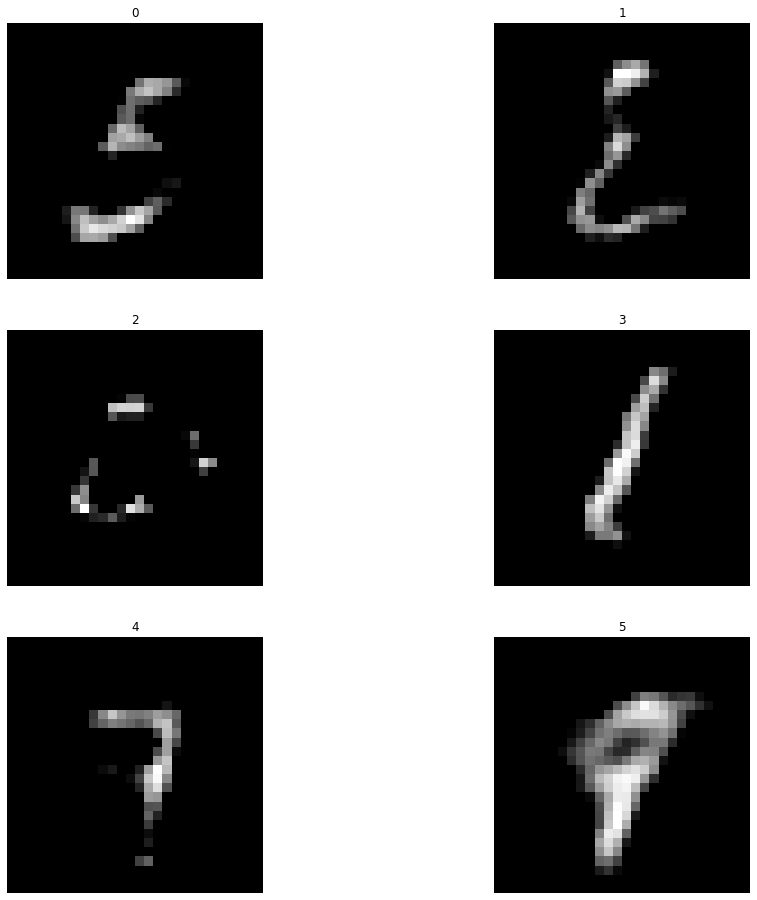

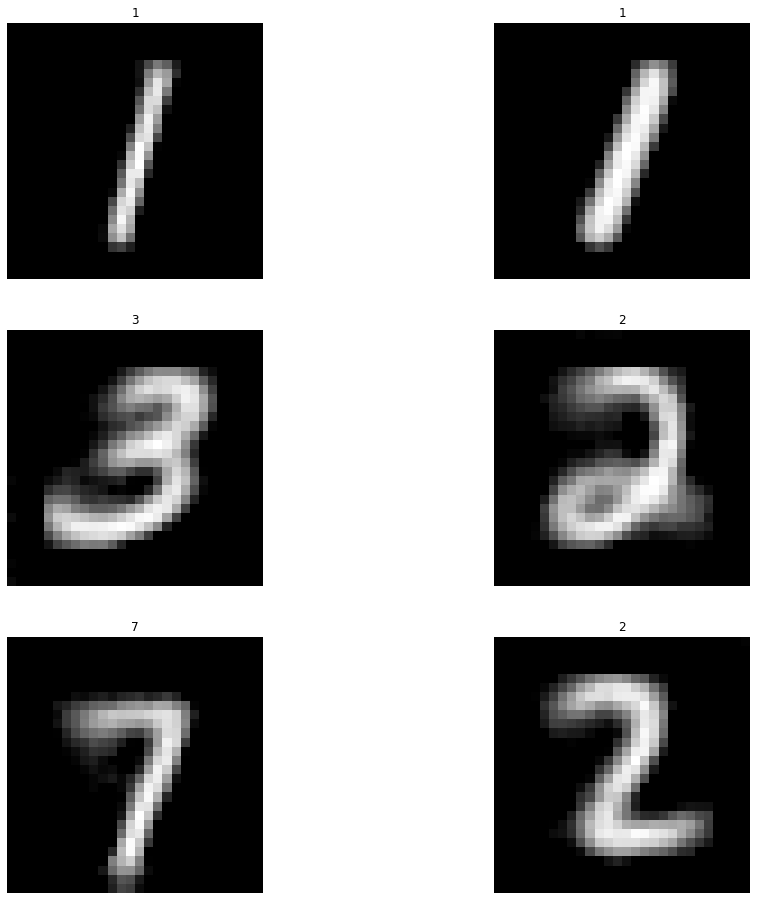

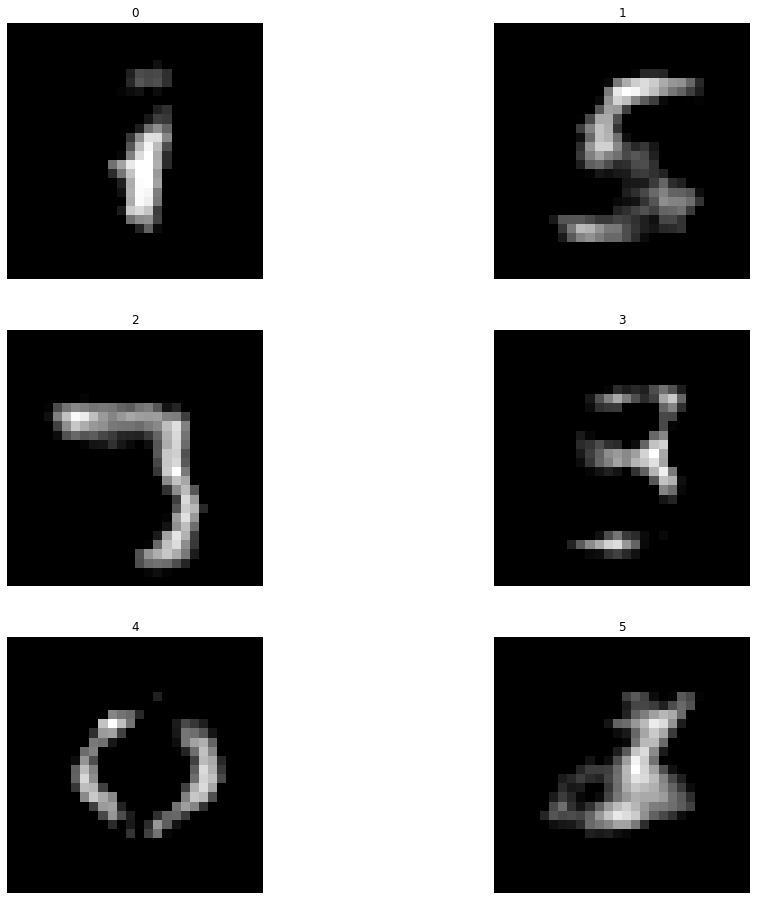

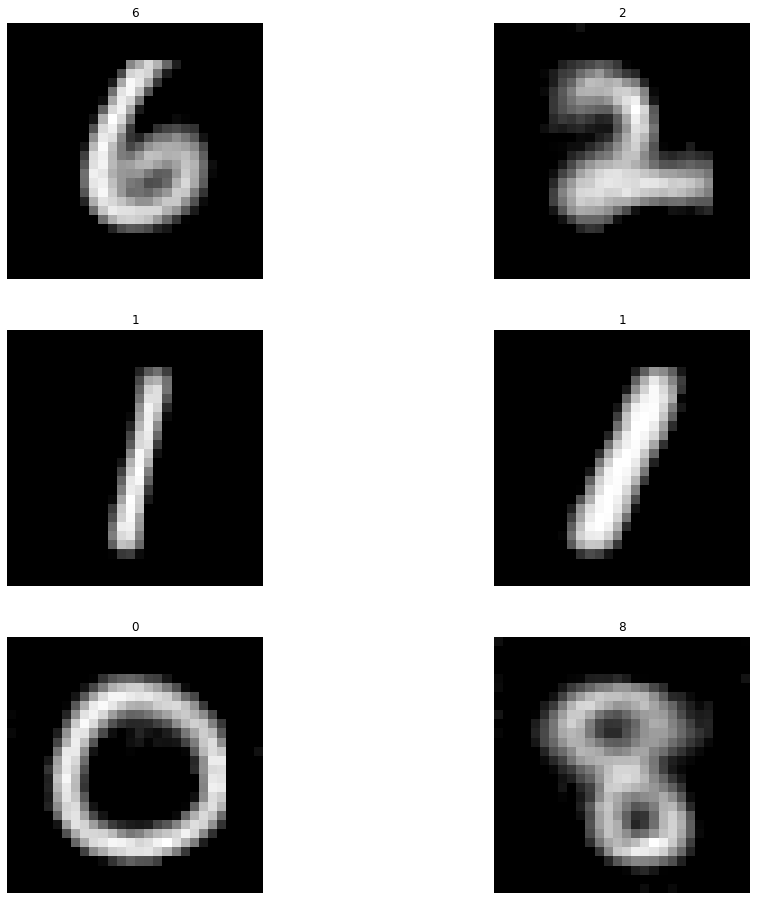

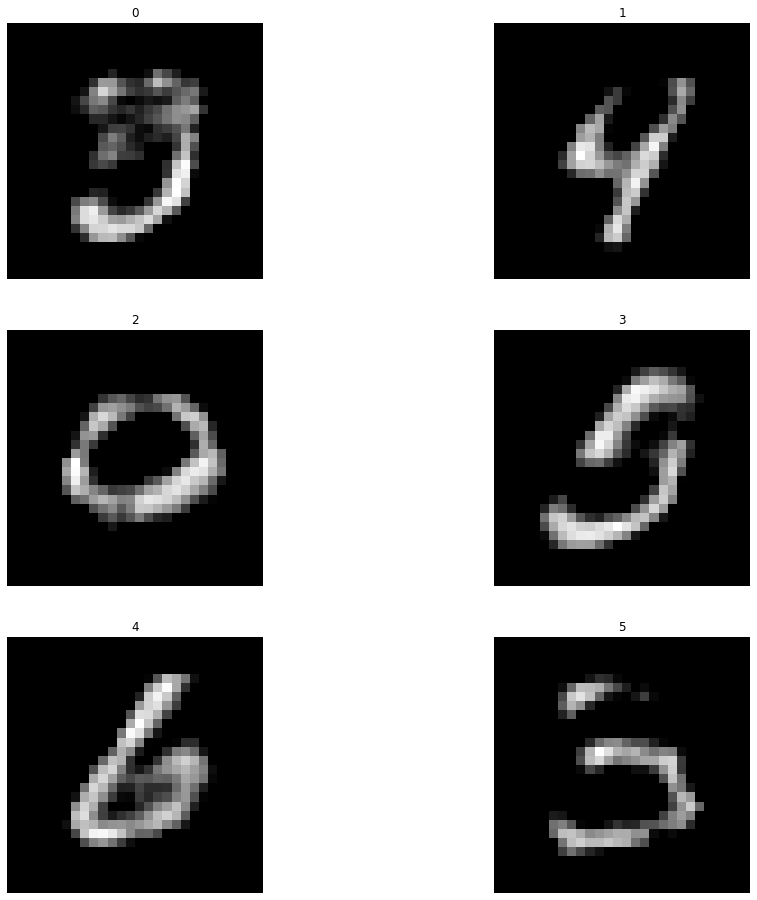

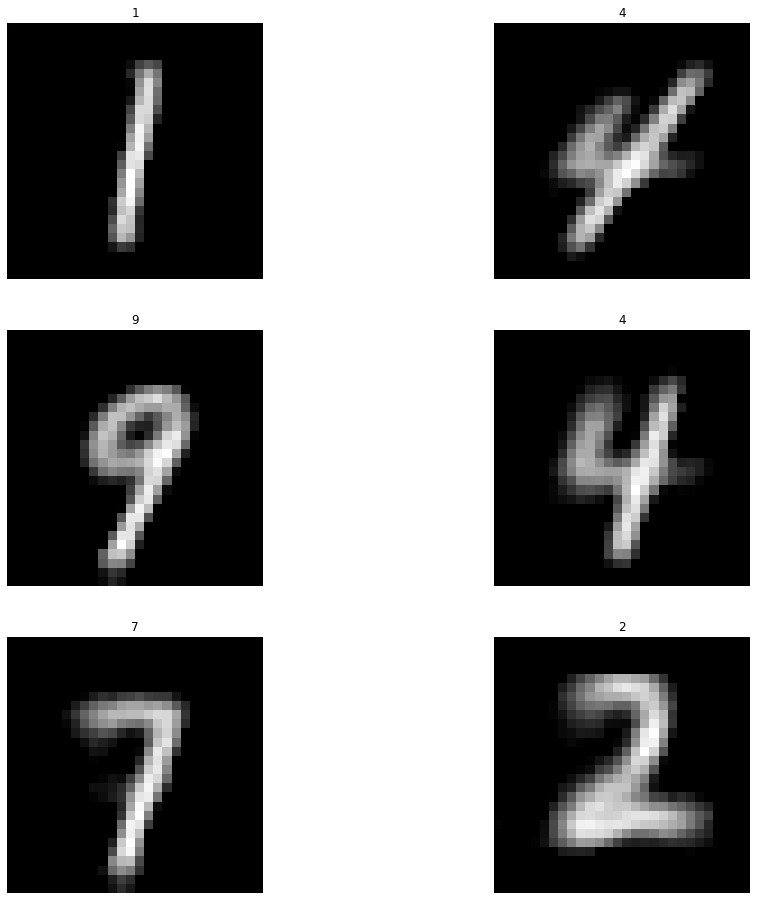

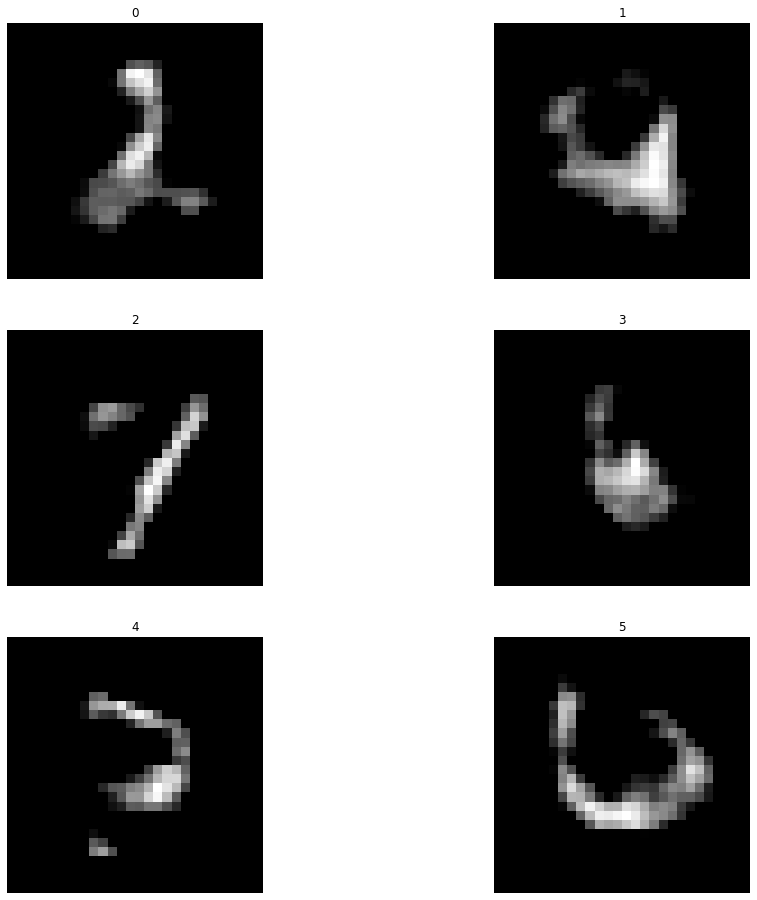

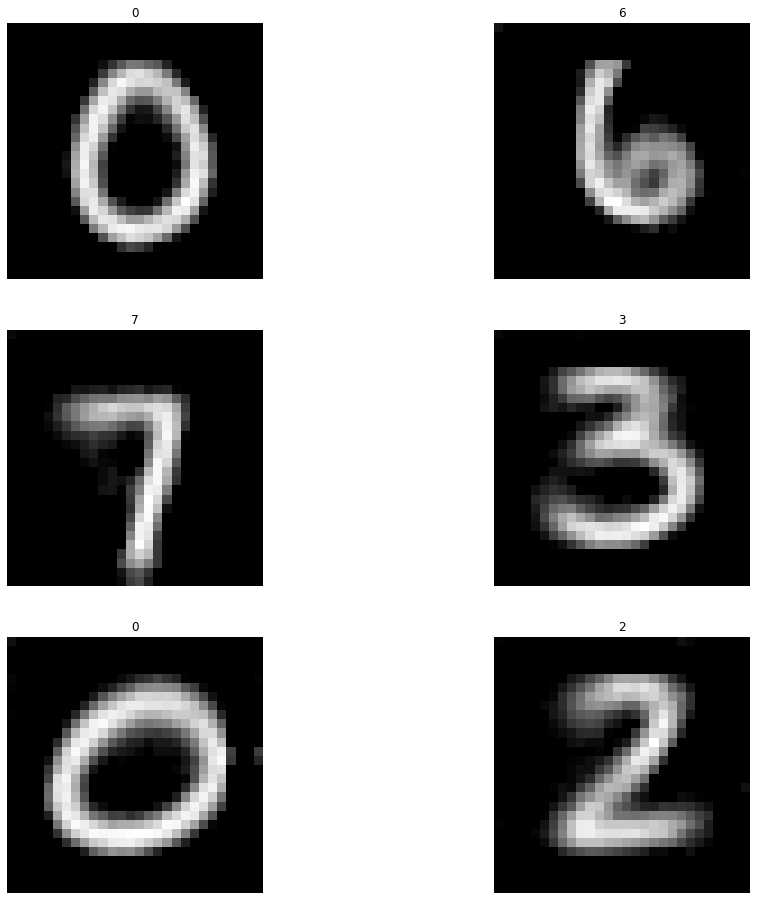

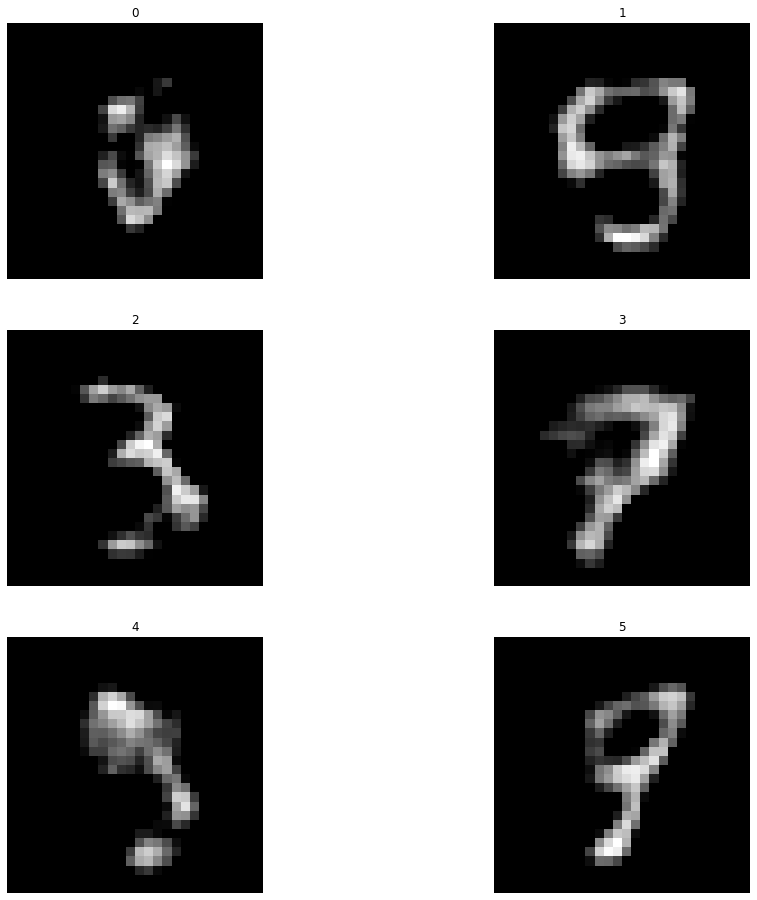

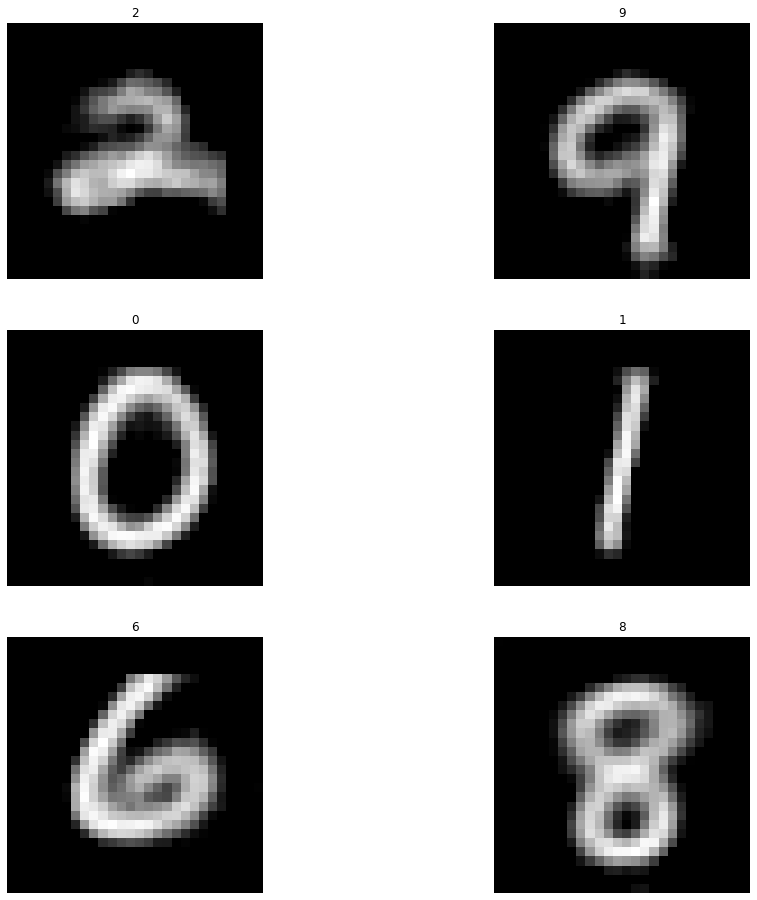

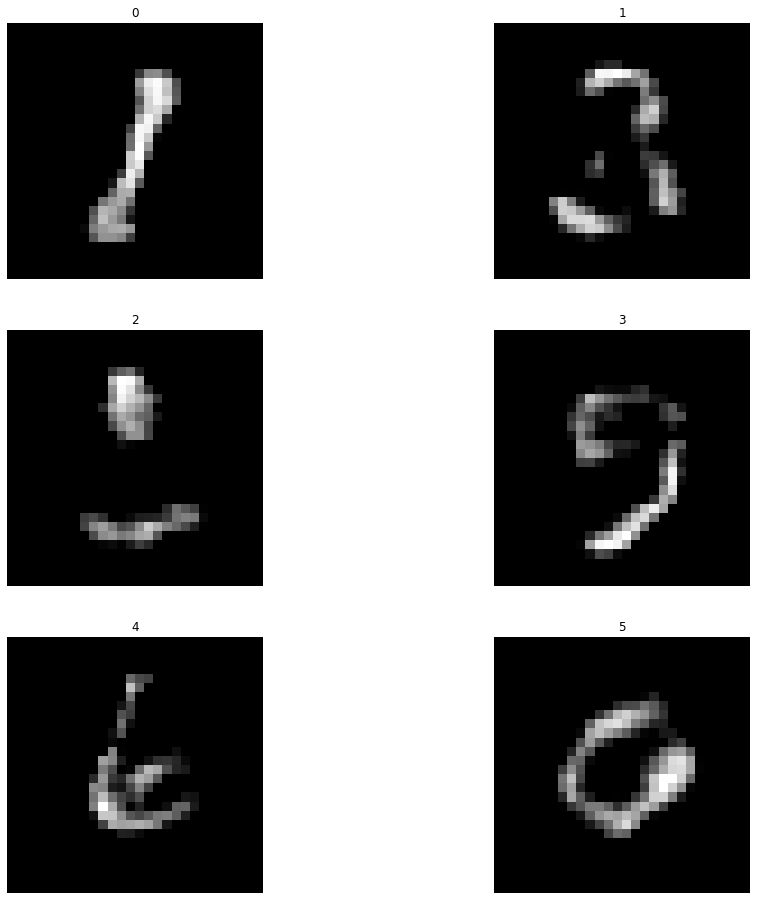

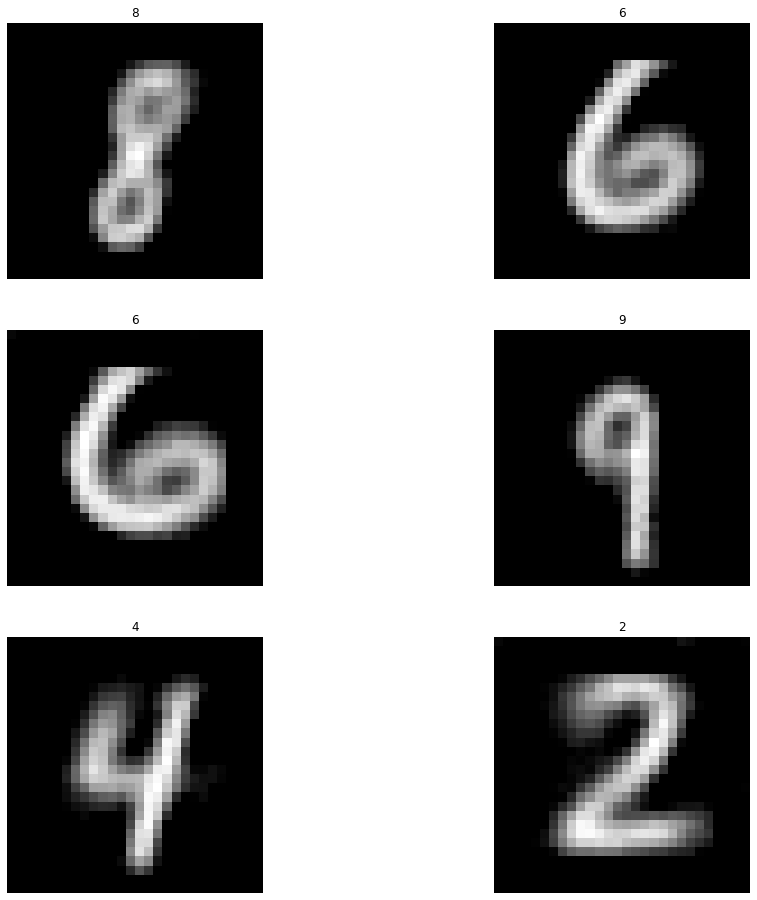

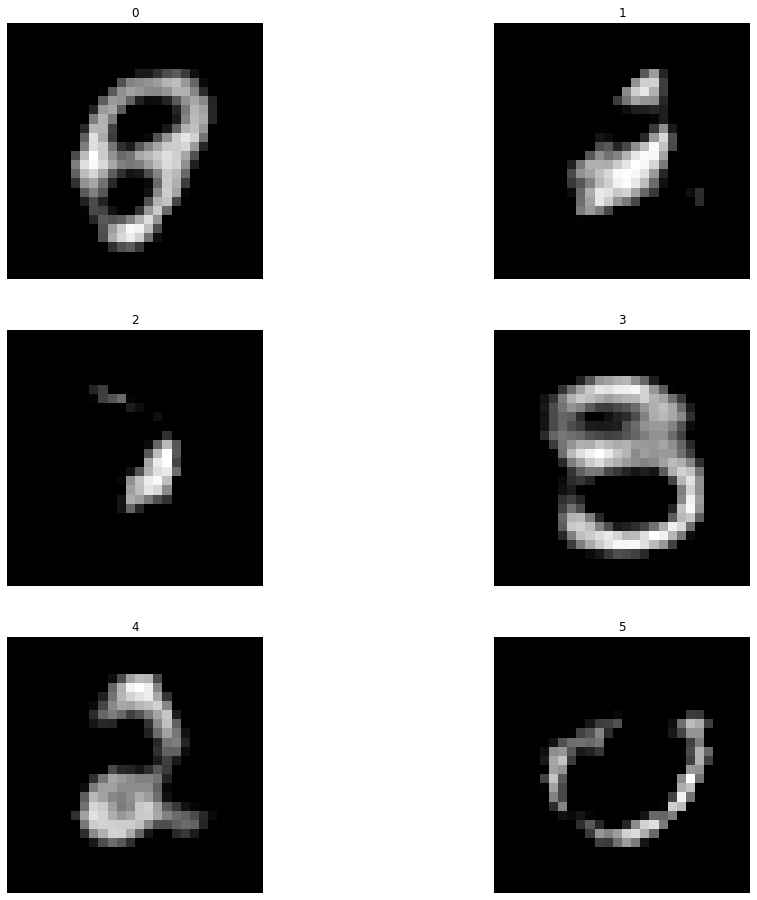

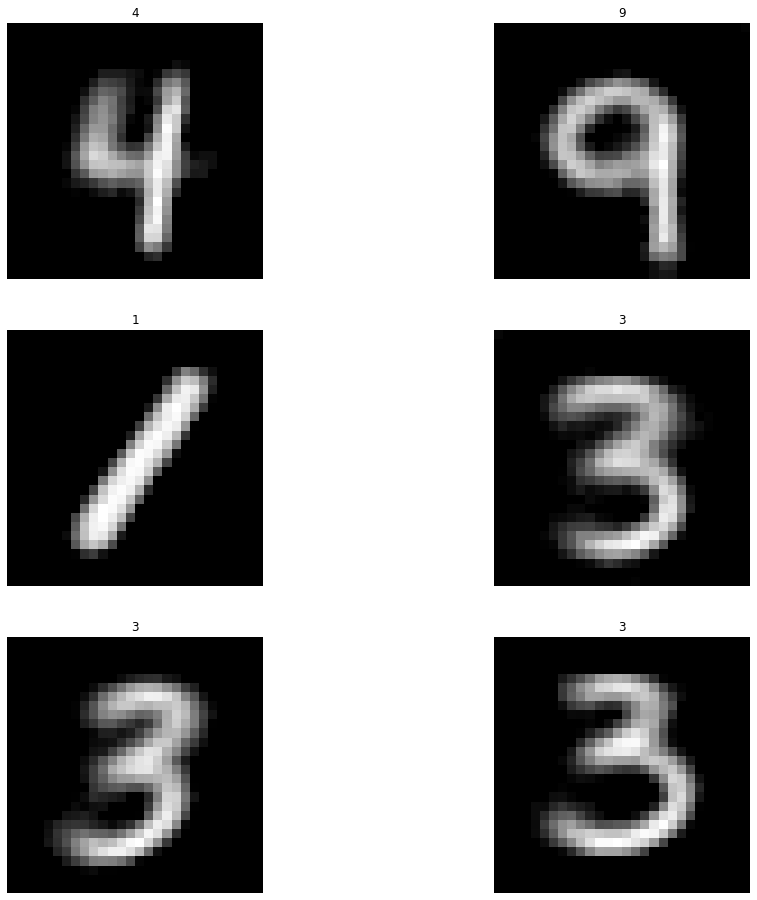

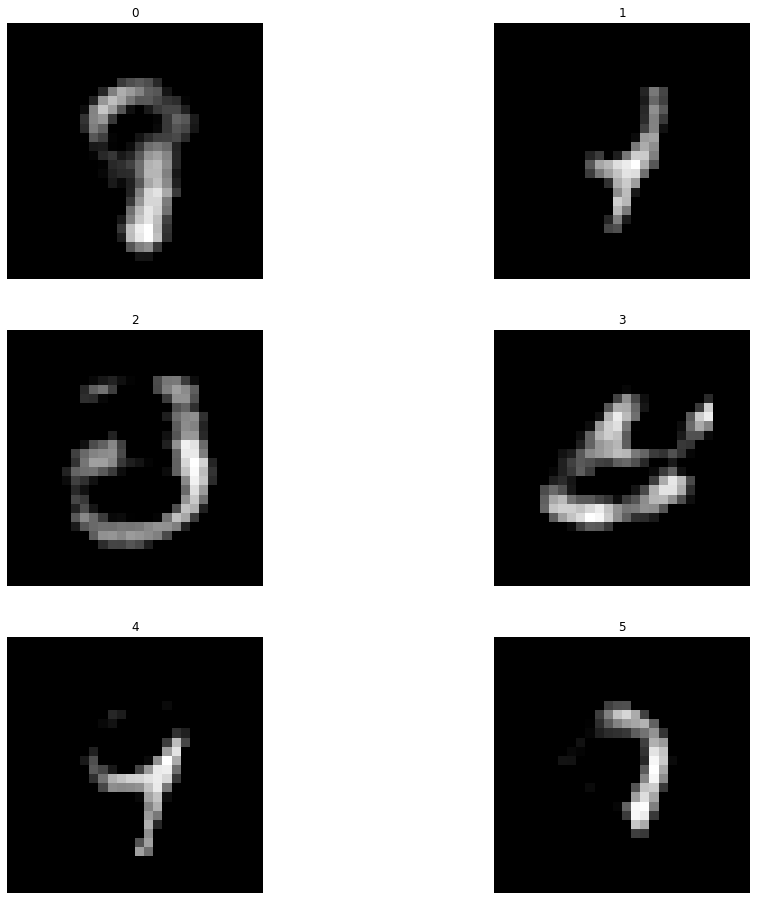

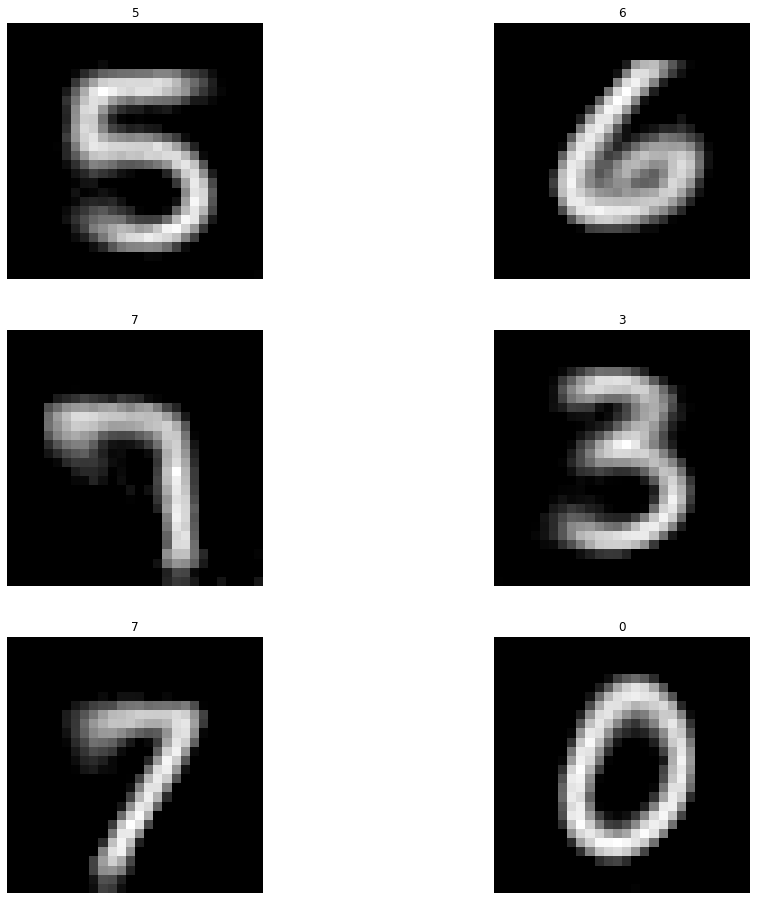

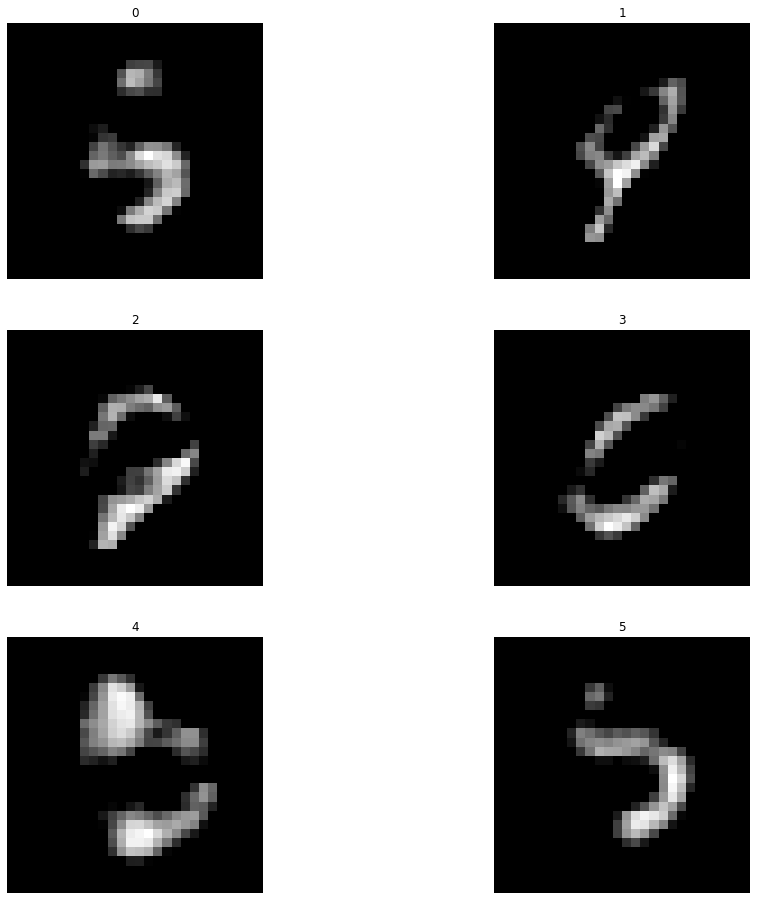

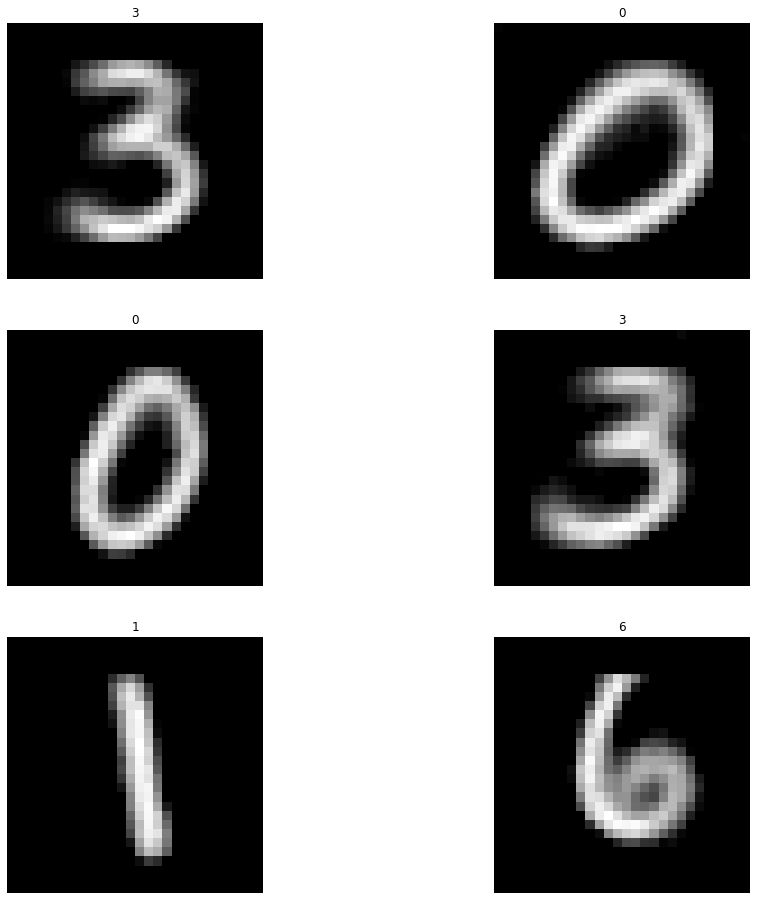

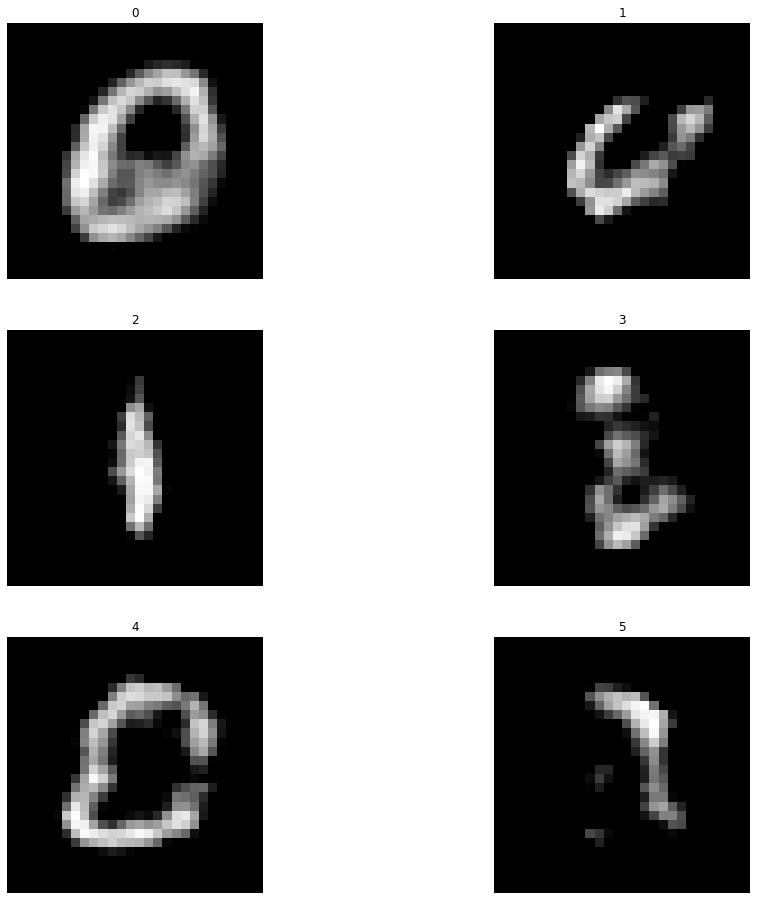

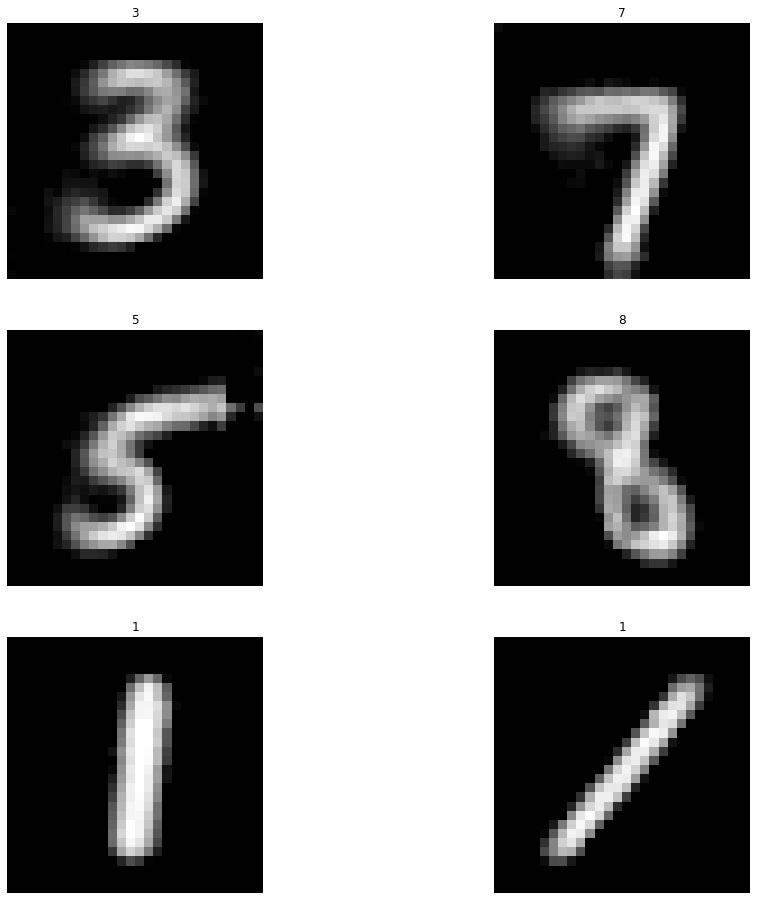

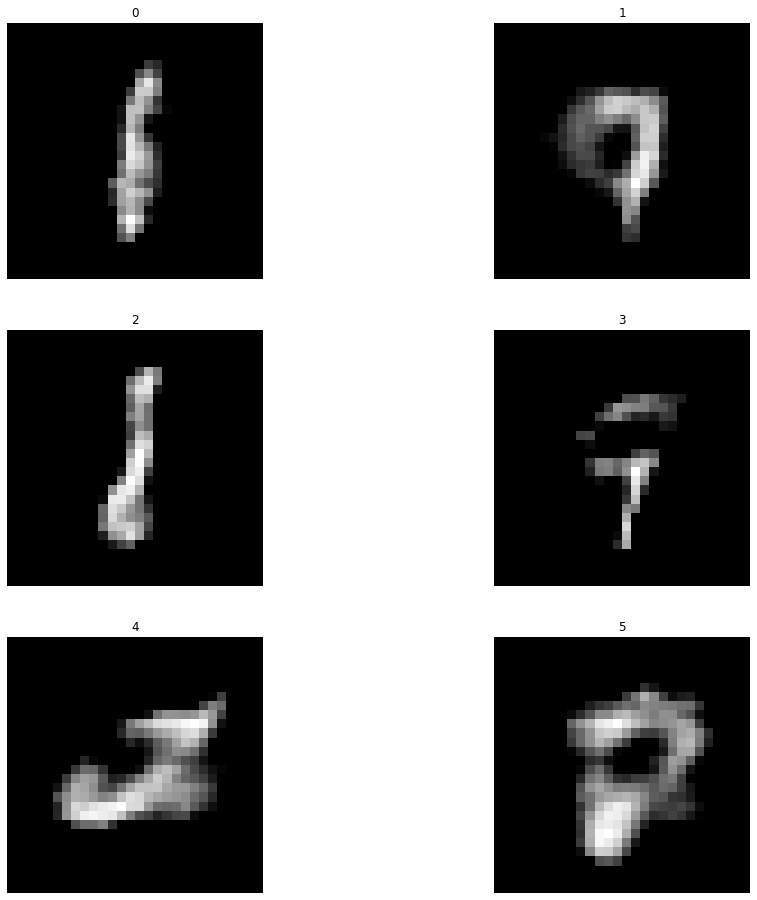

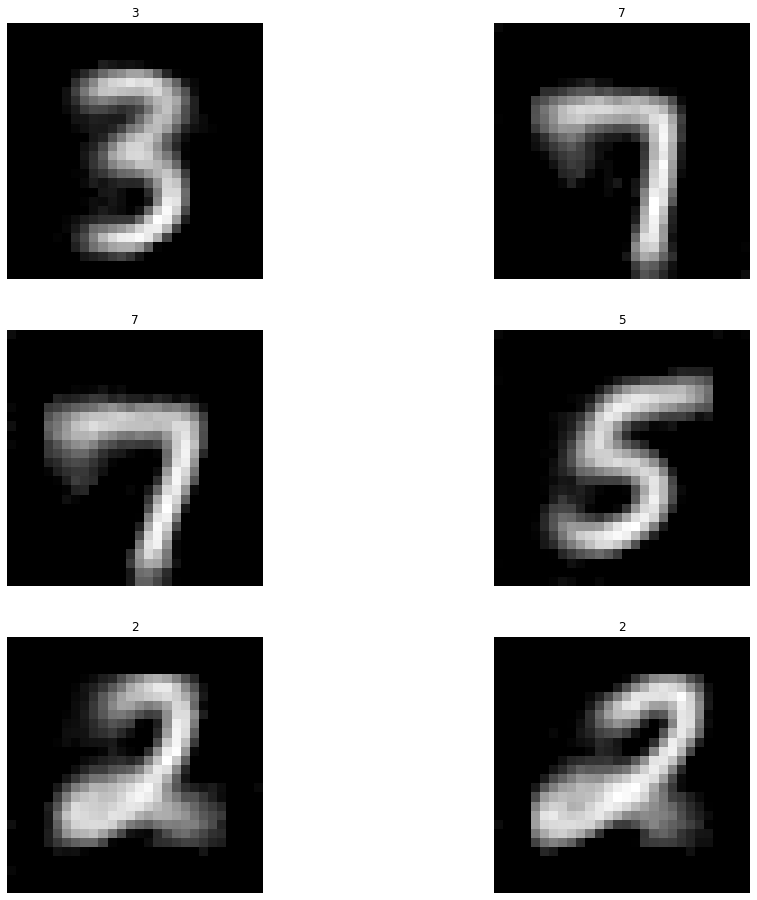

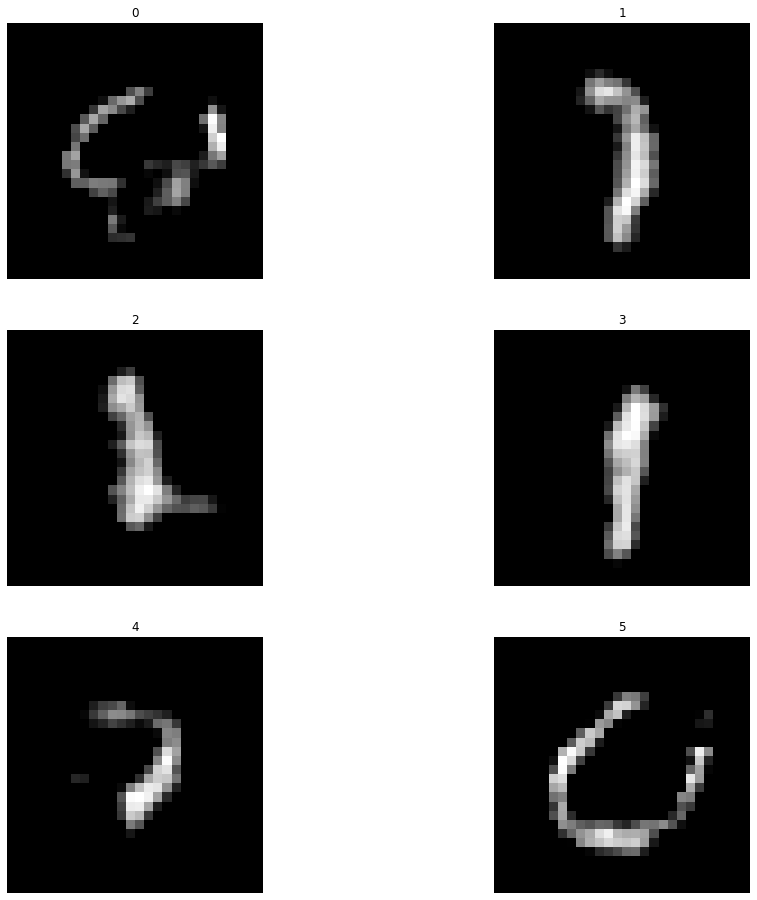

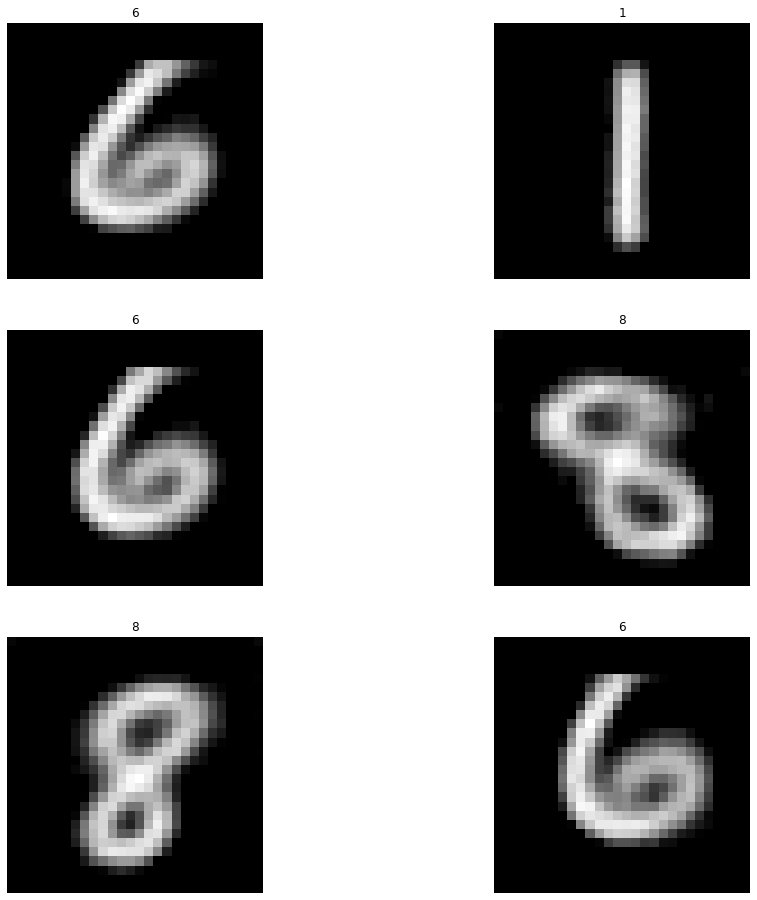

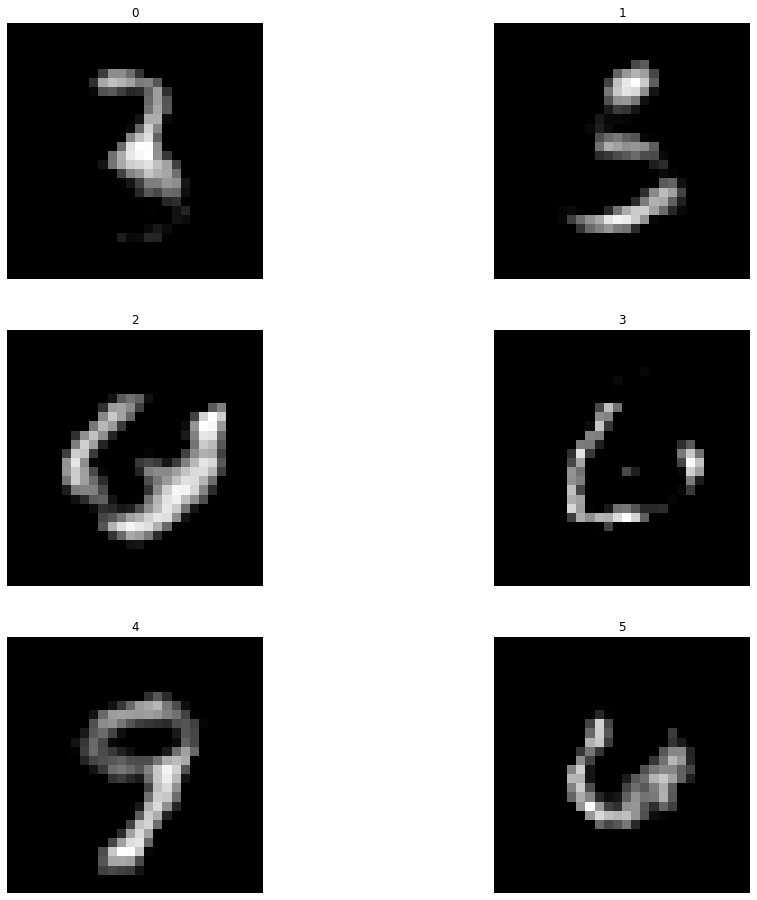

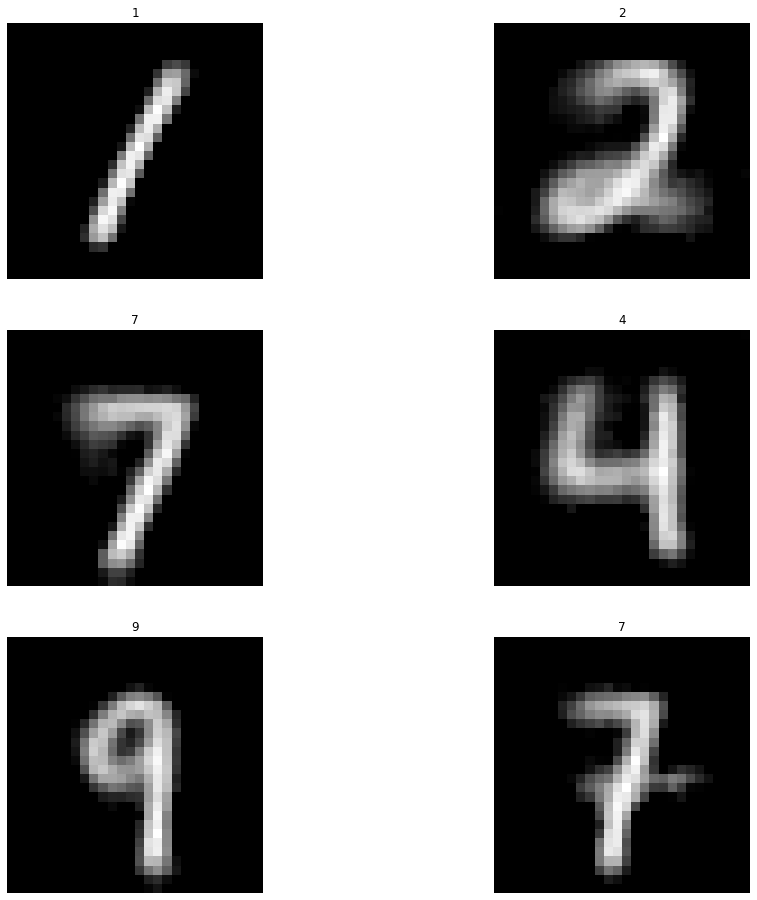

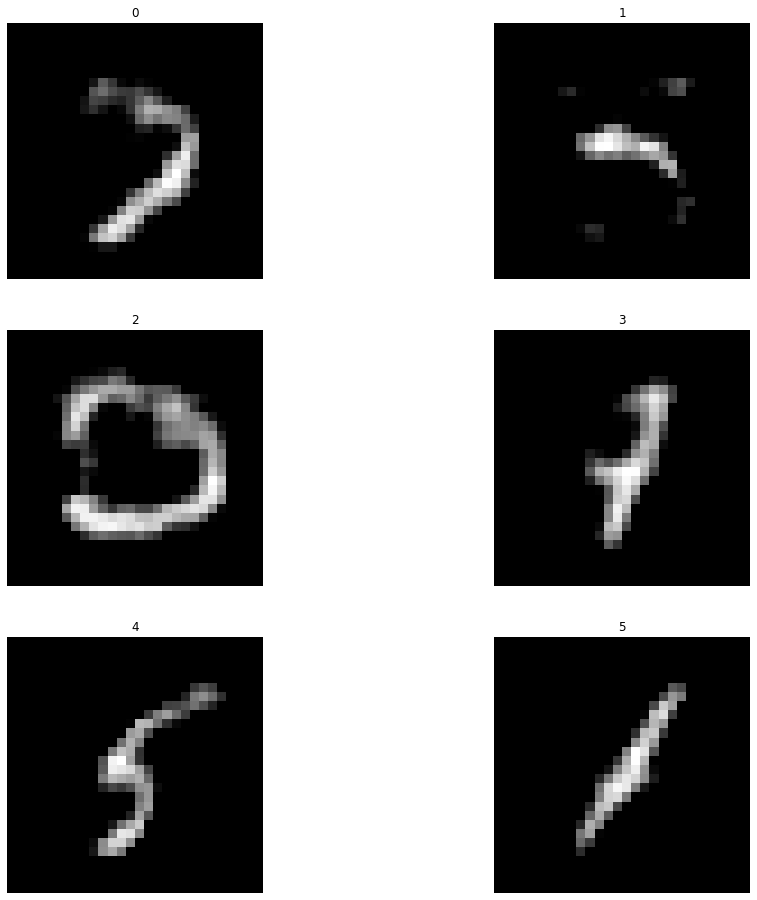

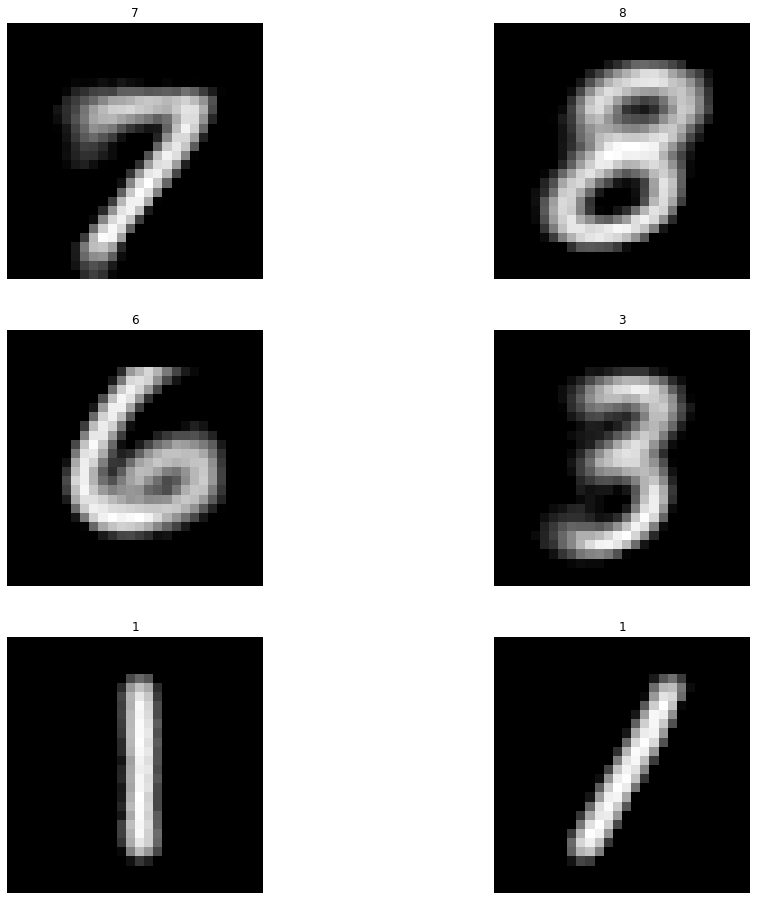

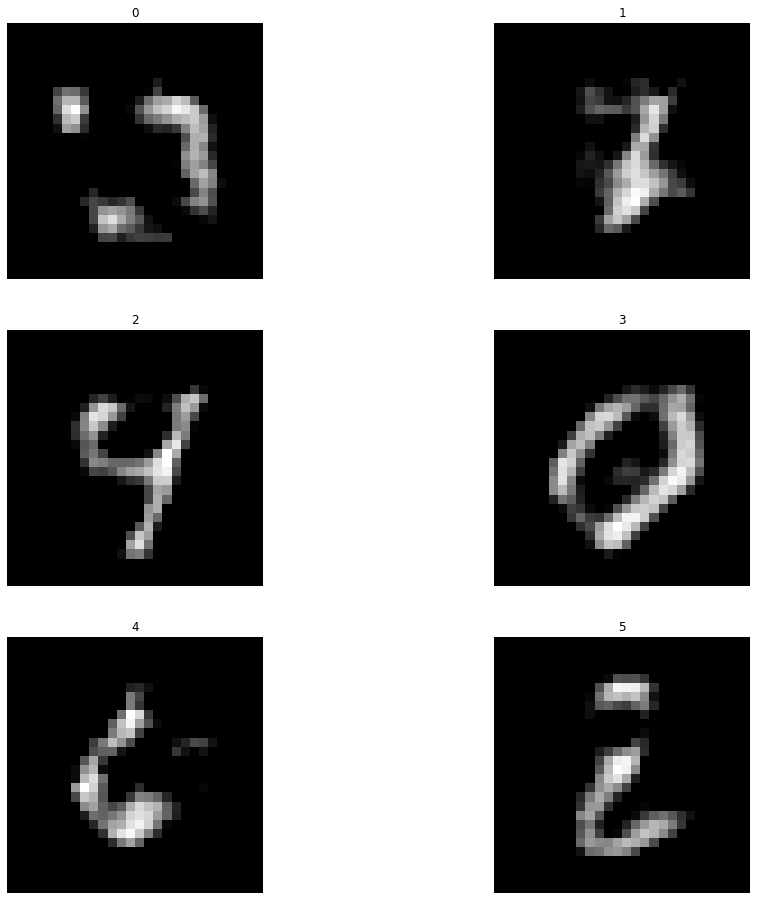

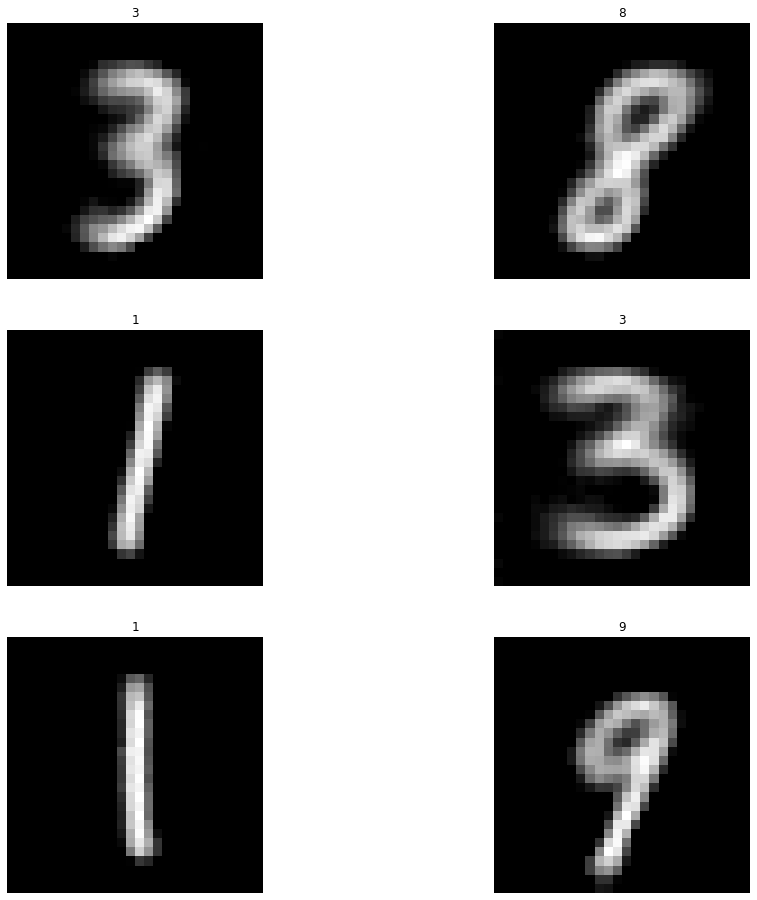

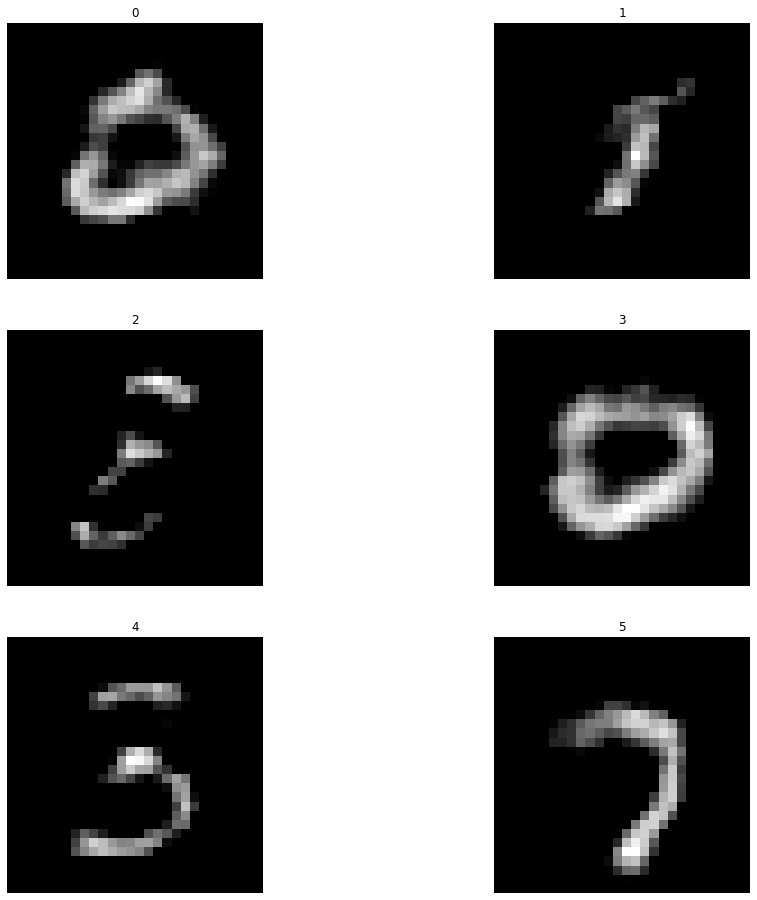

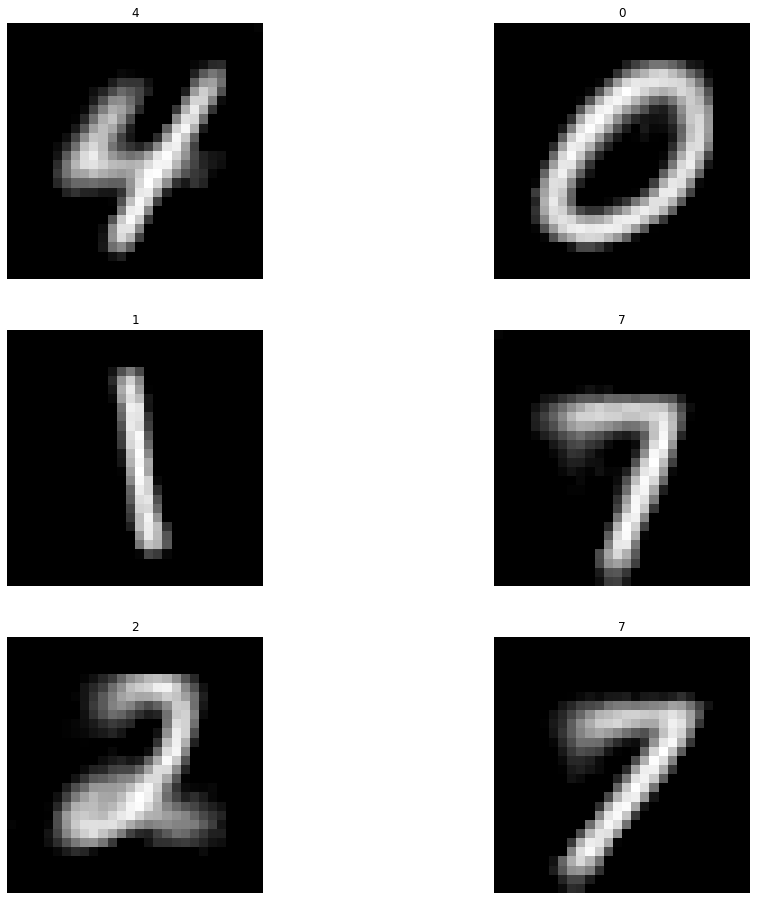

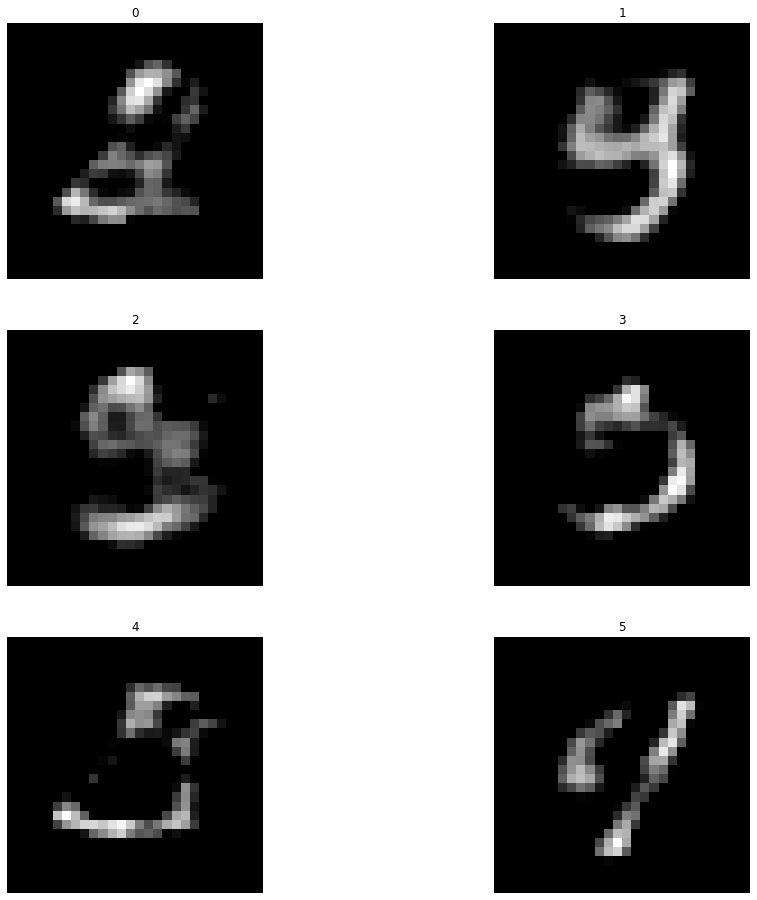

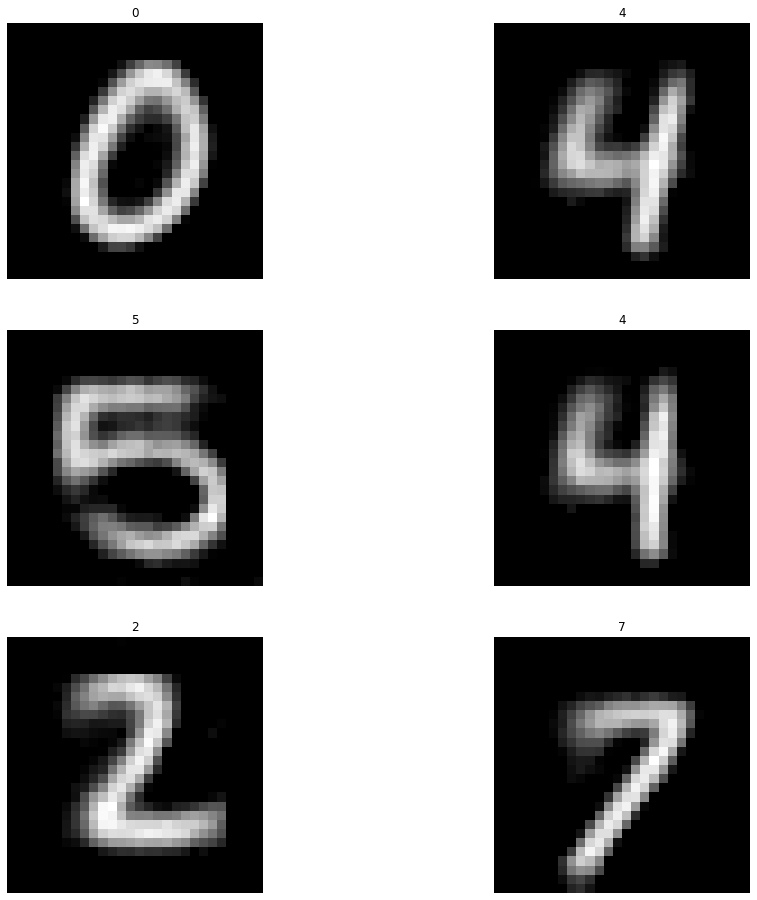

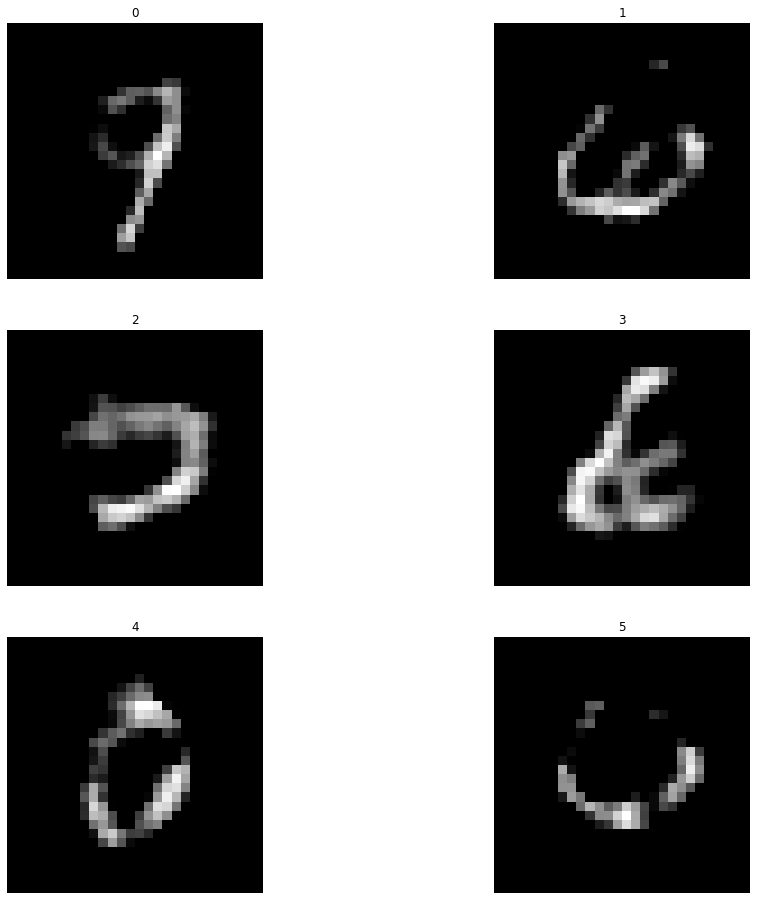

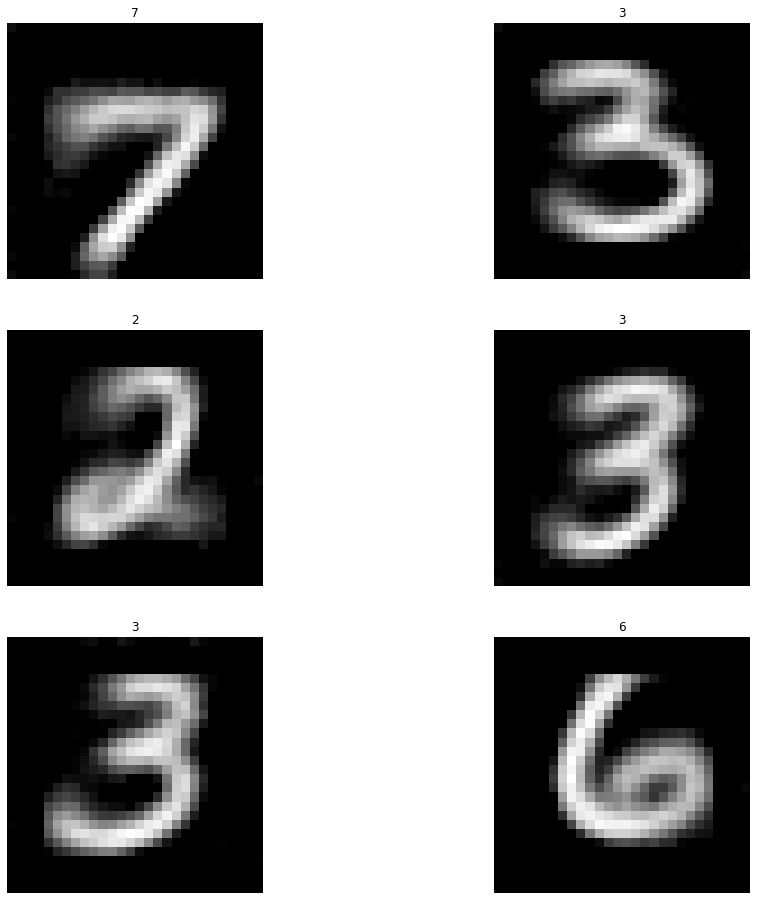

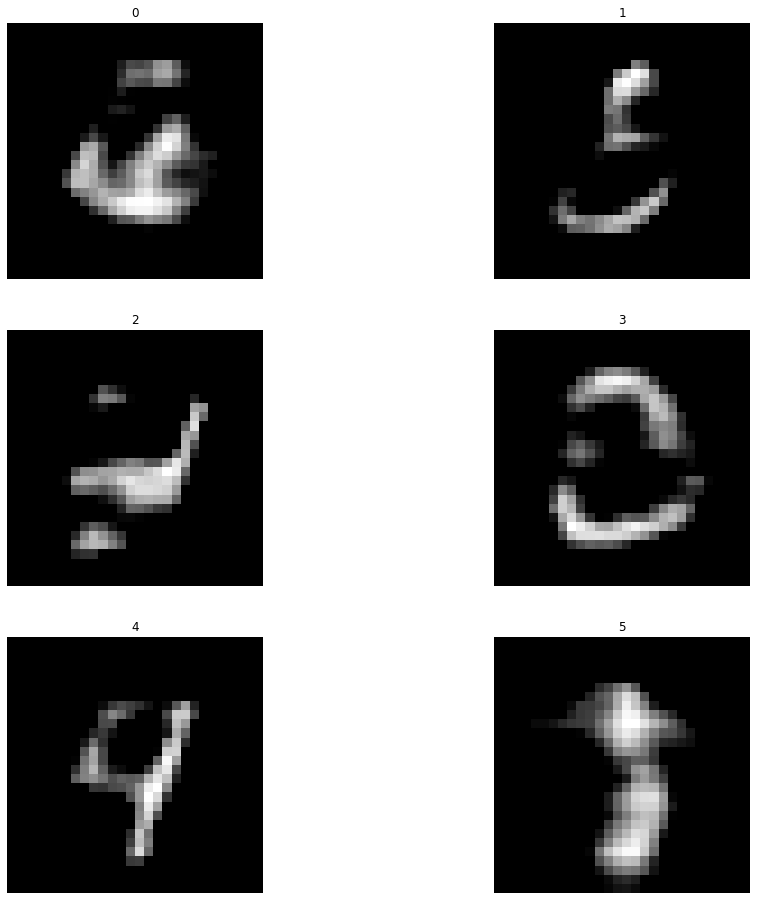

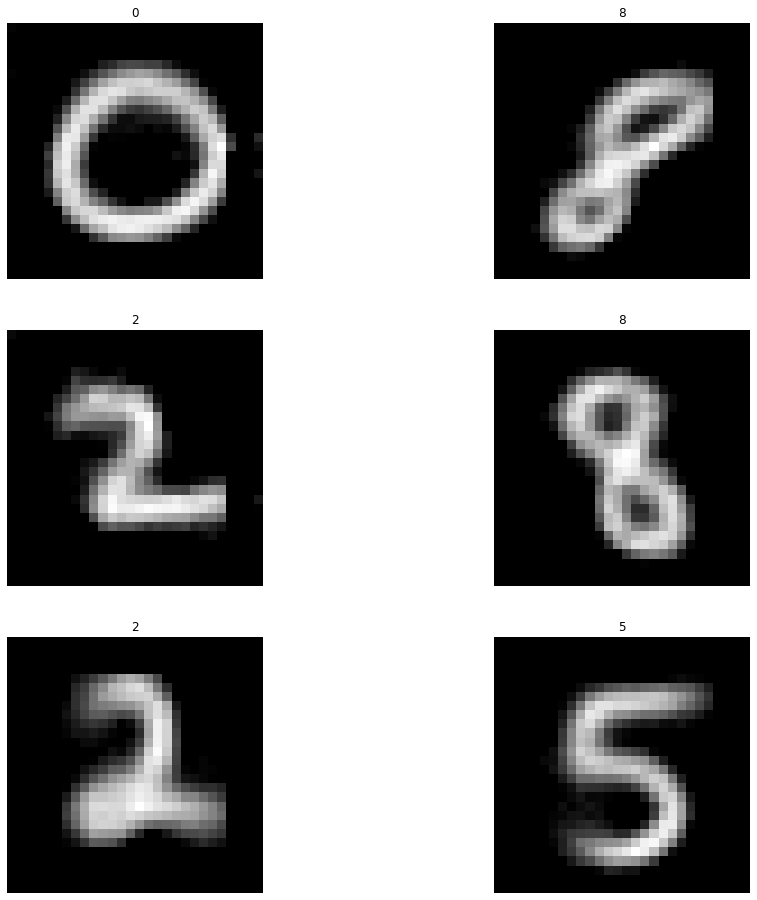

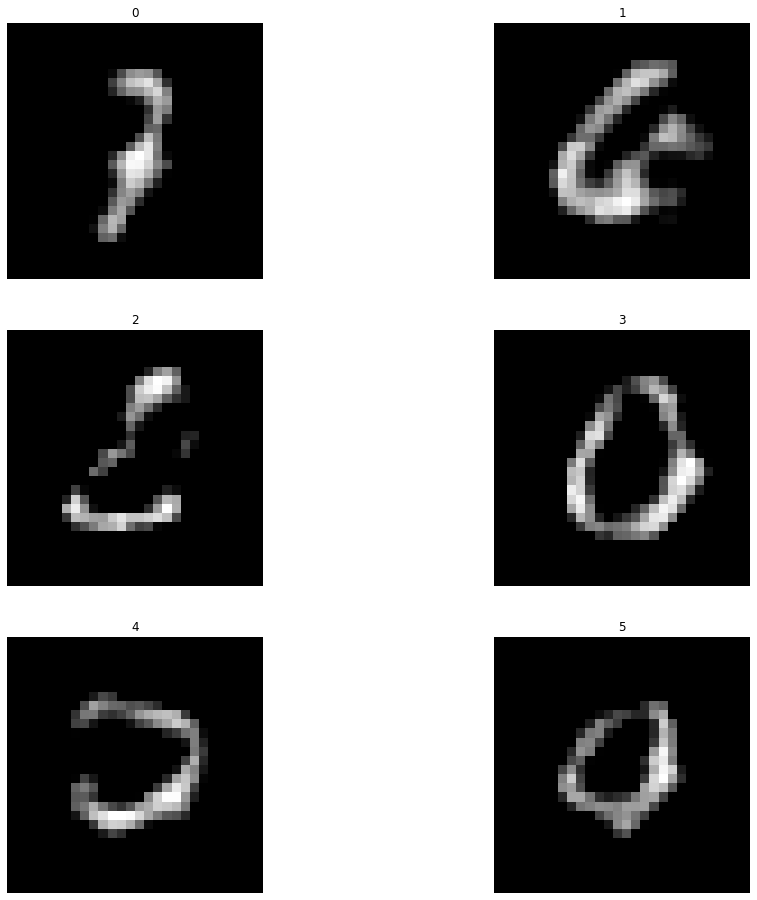

In [39]:
if __name__ == "__main__":
    train_loader, test_loader = load_data()
    print("dataloader created")
    model = Model().to(device)
    print("model created")
    if load_epoch > 0:
        model.load_state_dict(torch.load('./checkpoints/model_{}.pt'.format(load_epoch), map_location=torch.device('cpu')))
        print("model {} loaded".format(load_epoch))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    train_loss_list = []
    test_loss_list = []
    for i in range(load_epoch+1, max_epoch):
        model.train()
        train_total, train_kld, train_loss = train(i, model, train_loader, optimizer)
        with torch.no_grad():
            model.eval()
            test_total, test_kld, test_loss = test(i, model, test_loader)
            if generate:
                z = torch.randn(6, 32).to(device)
                y = torch.tensor([1,2,3,4,5,6]) - 1
                generate_image(i,z, y, model)   
        print("Epoch: {}/{} Train loss: {}, Train KLD: {}, Train Reconstruction Loss:{}".format(i, max_epoch,train_total, train_kld, train_loss))
        print("Epoch: {}/{} Test loss: {}, Test KLD: {}, Test Reconstruction Loss:{}".format(i, max_epoch, test_loss, test_kld, test_loss))

        save_model(model, i)
        train_loss_list.append([train_total, train_kld, train_loss])
        test_loss_list.append([test_total, test_kld, test_loss])
        np.save("train_loss", np.array(train_loss_list))
        np.save("test_loss", np.array(test_loss_list))

In [41]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    preds,z_mean, _ = vae.forward(data,labels)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [45]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(model, x_train, y_train)

Ploting Loss Curve

In [45]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        running_loss =+ loss.item() * images.size(0)

    loss_values.append(running_loss / len(train_dataset))

plt.plot(loss_values)